In [ ]:
!pip install fastapi
!pip install kaleido
!pip install python-multipart
!pip install uvicorn

In [ ]:
!pip install -q magnumnp

In [ ]:
import os
'''
from google.colab import drive
drive.mount('/content/drive/')
os.chdir('drive/Shareddrives/Ma Lab SPA/data/magnonics/magnumRAW')
savedir='drive/Shareddrives/Ma Lab SPA/data/magnonics/magnumRAW/'
'''
savedir='/content/'
from magnumnp import *
import torch
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from time import localtime, strftime, time
from datetime import datetime
from copy import deepcopy
from random import random,uniform
import pickle
from scipy.interpolate import interp1d
import os

2024-05-31 22:21:20  magnum.np:INFO magnum.np 1.1.6
INFO:magnum.np:magnum.np 1.1.6


In [ ]:
torch.cuda.is_available()

True

In [ ]:
a=lambda t: torch.Tensor()
print(a(7))
a(torch.Tensor(7))

tensor([  7.,  49., 343.])


ValueError: ignored

2024-02-27 19:13:56  magnum.np:INFO [State] running on device: cuda:0 (dtype = float64)
INFO:magnum.np:[State] running on device: cuda:0 (dtype = float64)
2024-02-27 19:13:56  magnum.np:INFO [Mesh] 120x300x1 (size= 2e-08 x 2e-08 x 7e-08)
INFO:magnum.np:[Mesh] 120x300x1 (size= 2e-08 x 2e-08 x 7e-08)


<class 'magnumnp.common.decorated_tensor.DecoratedTensor'>


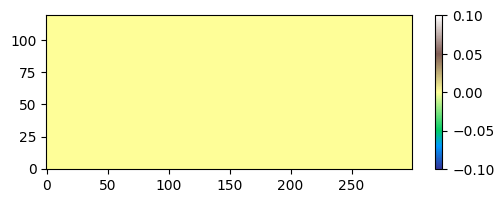

<Figure size 640x480 with 0 Axes>

In [ ]:
#@title Geometry Testing
#mesh = Mesh((100, 50, 1), (1e-9, 1e-9, 1e-9), origin = (0, 0, 0.))
nmesh=(120, 300, 1)
dmesh=(2E-8, 2e-8, 70e-9)
omesh=(0,0, 0.)
mesh=Mesh(nmesh,dmesh,origin=omesh)
state = State(mesh)
x,y,z = state.SpatialCoordinate()
state.material = {
  "Ms": 0.0002,
  "A": lambda t: 1.3e-11*(1+t)**2,
  "alpha": 0.02,
  "Mag":0.0
  }
#state.material['Ms'][80:,:,:,:]=(1-2E-4)/(1+np.exp(20E-9))*torch.exp(x[80:,:,:,None])+(1-2E-4*np.exp(20E-9))/(1-np.exp(20E-9))
state.material['Ms'][:,40:,:,:]=(0.0002*torch.exp((y[:,40:,:,None]-40e-9)*np.log(1/0.0002)/(10E-9)))
state.material['Ms'][:,:10,:,:]=(torch.exp((y[:,:10,:,None])*np.log(0.0002)/(10E-9)))
state.material['Ms'][80:,:,:,:]=(0.0002*torch.exp((x[80:,:,:,None]-80e-9)*np.log(1/0.0002)/(20E-9)))
state.material['Ms'][0:20,:,:,:]=(torch.exp((x[0:20,:,:,None])*np.log(0.0002)/(20E-9)))
state.material['Mag'][15:26,:,:,:]=10
state.material['jeMag']=0
state.material['jeMag'][15:26,:,:,:]=10
state.material['je']=0
#ha=3E-6
#ht=100E-9
#hyperNodes=[2E-6,2.78E-6,3.57E-6,4.36E-6]
#for hn in hyperNodes:
#    hyperbola1= (((x-hn+(ha/2-ht/2))**2 - (y-300*2E-8)**2 < ha**2)^((x-hn+(ha/2+ht/2))**2 - (y-300*2E-8)**2 < ha**2))*(x>(hn))
#    state.material['je'][hyperbola1]=3
#state.material['je']=0
#paraNodes=[2E-6,2.78E-6,3.57E-6,4.36E-6]
#for pn in paraNodes:
#    parabola1= ((x-pn-ht/2)<0)^((x-pn+ht/2)<0)
#    state.material['je'][parabola1]=3
#trap1=(-0.2071*x+7.0109E-6<y) & (0.2071*x-0.8357E-6<y) & (y>3.1E-6)
#trap2=(-0.2071*x+6.8357E-6>y) & (0.2071*x-1.0109E-6>y) & (y<2.9E-6)
#state.material['je'][trap1]=6
#state.material['je'][trap2]=6

disk = x**2 + y**2 < 10e-9**2
recta=(x<30E-9)*(x>20E-9)
rectb=x>20E-9
state.t=8
state.material["A"][disk] = 3.
print(type(state.material['A'][disk]))
state.m = torch.stack([-y,x,0*z], dim=-1)
state.m[~disk] = 0
g=geom(state)
rs=g.set_strip(length=40E-9,width=10E-9,center=(0, 0, 0.),angle=45)
state.m[rs] = 3.
state.m.normalize()
cent=20e-9
w=5e-9
th=10e-9
state.m=lambda t: torch.stack([t*(torch.arctan(((x-cent)+w/2)/th)-torch.arctan(((x-cent)-w/2)/th))/(2*np.arctan(w/2/th)),0*y,torch.log(((x-cent+w)**2+th**2)/((x-cent-w)**2+th**2))/(4*np.arctan(w/2/th))],dim=-1)
spud=1
plotState(state,var='je',dir=0,time=22)

In [ ]:
2.76E6/79

34936.70886075949

In [ ]:
#@title Functions
def plotState(st,var='A',colors='terrain',size='default',dir=0,time=0):
    if var=='m':
        if callable(st.m):
            datArr=st.m(time)
        else:
            datArr=st.m
    else:
        if callable(st.material[var]):
            datArr=st.material[var](time)
        else:
            datArr=st.material[var]
    y,x,z=list(range(len(datArr))),list(range(len(datArr[0]))),[]
    yl,xl=len(y),len(x)
    if size=='default':
        size=(xl/max(yl,xl)*5+0.9,yl/max(yl,xl)*5)
    plt.figure(figsize=size)
    for xv in range(len(datArr)):
        z.append([])
        datRow=datArr[xv]
        for yv in range(len(datRow)):
            z[-1].append(float(datRow[yv][0][dir]))
    mpb=plt.pcolormesh(x, y, z,cmap=colors,shading='nearest')
    plt.colorbar(mpb)
    plt.show()
    plt.clf()

class materials:
    def __init__(self,thickness=50E-9,init_pol=[0,-1,0]):
        self.d,self.p=thickness,init_pol
        self.dispersion={}
        #self.load_dispersion()
        return

    def set_yig(self):
        self.Ms=140E3#Sat Mag in A/m; this is the BULK value; the 50nm value is 110E3, the 100nm is 130E3. From https://doi.org/10.1016/B978-0-12-374293-3.00003-1
        self.A=3.5E-12#Exchg Const in J/m. From https://doi.org/10.1016/B978-0-12-374293-3.00003-1
        self.alpha=0.0002#Damping Constant
        self.Ku=0#uniaxial anisotropy constant in J/m^3 (~strength of contribution to local field from angle between magnetization and easy axis)
        self.Ku_axis=(1,1,1)#Easy axis
        self.Ku=0#uniaxial anisotropy constant in J/m^3 (~strength of contribution to local field from angle between magnetization and easy axis). YIG has cubic structure, so no linear anisotropy
        self.Kc1=-610#cubic anisotropy constant, first, J/m^3. No rotation is needed to give an easy axis of 111. From https://doi.org/10.1016/B978-0-12-374293-3.00003-1
        self.Kc2=-260#cubic anisotropy constant, second, J/m^3. From https://doi.org/10.1016/B978-0-12-374293-3.00003-1
        self.Kc_alpha=-3*np.pi/4
        self.Kc_beta=np.arctan(np.sqrt(2))
        self.Kc_gamma=3*np.pi/4
        self.gamma=3.5E4#gyromagnetic ratio in m A^-1 s^-1. From https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4748416/
        self.eta_damp=-0.10, # Amplitude factor of damping-like spin torque, unitless. Got it from https://www.nature.com/articles/nmat4812
        self.eta_field=0.10, # Amplitude factor of field-like spin torque, unitless. Assumed same as eta_field with opposite sign from https://www.nature.com/articles/nmat4812
        return

    def set_py(self):
        self.Ms=675E3#Sat Mag in A/m
        self.A=16E-12#Exchg Const in J/m
        self.alpha=0.007#Damping Constant
        self.Ku=0#uniaxial anisotropy constant in J/m^3 (for 75%Fe, 25%Ni; other ratios have nonzero Ku)
        self.Ku_axis=(0,1,0)#Easy axis (technically there is no easy/hard axis for 75-25 Py, but for slight deviations from this ration [111] is the easy axis)
        self.gamma=2.21E5#gyromagnetic ratio in T^-1s^-1
        self.eta_damp=-0.12, # Amplitude factor of damping-like spin torque, unitless. This is a material parameter which dosen't seem to have been really well measured yet
        self.eta_field=0.12, # Amplitude factor of field-like spin torque, unitless. This is a material parameter which dosen't seem to have been really well measured yet
        return

    def set_cofeb(self):
        self.Ms=1250E3#Sat Mag in A/m
        self.A=15E-12#Exchg Const in J/m
        self.alpha=0.004#Damping Constant
        self.Ku=28600#uniaxial anisotropy constant in J/m^3
        self.Ku_axis=(1,1,0)#Easy axis
        self.gamma=1.76E7#gyromagnetic ratio in T^-1s^-1
        self.eta_damp=-0.1, # Amplitude factor of damping-like spin torque, unitless. This is a material parameter which dosen't seem to have been really well measured yet
        self.eta_field=0.3, # Amplitude factor of field-like spin torque, unitless. This is a material parameter which dosen't seem to have been really well measured yet
        return

    def set_nonmagnetic(self):#Originally copper, but any nonmagnetic material will have the same properties
        self.Ms=5E8#Copper is nonmagnetic, and will not polarize no matter how strong of a field you apply to it. Unfortunately, large Ms also causes iteration time to increase exponentially for some reason. 1E8 yields ~10sec/time step, 1E7 ~2sec on CPU, ~50ms and ~0.5s on GPU respectively
        self.A=3.5E-17#Pure copper has no ferromagnetism due to the abscence of an unpaired electron, and therefore the exchange stiffness is zero.
        self.alpha=9#Again, as a nonmagnetic material, any spin waves impinging on copper see it as a brick wall
        self.Ku=0#Being nonmagnetic, copper will never posses anistotropy
        self.Ku_axis=(1,0,0)
        self.gamma=28E9
        self.eta_damp=0
        self.eta_field=0
        return

    def set_ggg(self):
        self.Ms=175.9E3
        self.gamma=1.8E8
        self.A=1.2E-15#Near as I can tell this has never been directly reported, but I did find a paper (https://doi.org/10.1103/PhysRevLett.114.227203) suggesting a nearest-neighbor Ising coefficient of J=0.107K for GGG. The exchange energy is then 0.107*kb. GGG in cubic phase has a lattice constant of 1.232E-9, so A=0.107*kb/(1.232E-9) J/m
        #Near as I can tell this has never been directly reported either, but I did find a paper (https://doi.org/10.1063/1.593724) measuring complex permeability in GGG. Based on dimensional analysis, the fact that dM/dt has units of A/ms, and that dM/dt=gamma*alpha*(MxMxH),
        #It must be that gamma*alpha=sA/kg=Im(mu_r)w/mu0Ms where mu0 is vacuum permeability, w is frequency, Ms is saturation magnetization, and gamma is gyromagnetic ratio. Plugging in to find the (dimensionless) alpha at a frequency of 2.96GHz and a coercive field of 240E3 A/m yields
        self.alpha=2.5E-3/(self.gamma*1.26E-6*self.Ms)*2.96E9*2*np.pi#This is about 1.165, so not great but not the absolute worst.
        self.Ku=0#GGG has isotropic cubic symmetry, and no intrinsic hard/soft axes.
        self.Ku_axis=(1/np.sqrt(3),1/np.sqrt(3),1/np.sqrt(3))
        self.eta_damp=-0.1, # Amplitude factor of damping-like spin torque, unitless. This is a material parameter which dosen't seem to have been really well measured yet
        self.eta_field=0.3, # Amplitude factor of field-like spin torque, unitless. This is a material parameter which dosen't seem to have been really well measured yet
        return

    def set_custom(self,Ms,A,alpha,Ku,Ku_axis,gamma,eta_damp,eta_field):
        self.Ms=Ms
        self.A=A
        self.alpha=alpha
        self.Ku=Ku
        self.Ku_axis=Ku_axis
        self.gamma=gamma
        self.eta_damp=eta_damp
        self.eta_field=eta_field
        return

    def matDict(self):
        return {'Ms':self.Ms,'A':self.A,'alpha':self.alpha,'Ku':self.Ku,'Ku_axis':self.Ku_axis,'gamma':self.gamma,'eta_damp':self.eta_damp,'eta_field':self.eta_field,'p':self.p,
                'd':self.d,'Kc1':self.Kc1,'Kc2':self.Kc2,'Kc_alpha':self.Kc_alpha,'Kc_beta':self.Kc_beta,'Kc_gamma':self.Kc_gamma}

    def load_dispersion(self,location='YIGDispersion/'):
        for lf in os.listdir(location):
            self.dispersion[lf.rstrip('.dat')]=[]
            f=open(location+lf,'r')
            allLines=f.readlines()
            f.close()
            x,y1,y2=[],[],[]
            for i in range(3,len(allLines)):
                vals=allLines[i].split('\t')
                for j in range(len(vals)):
                    if 'I' in vals[j]:
                        vals[j]='0.0'
                x.append(float(vals[0]))
                y1.append(float(vals[1]))
                y2.append(float(vals[2]))
            self.dispersion[lf.rstrip('.dat')].append(interp1d(y1,x,bounds_error=False,fill_value='extrapolate'))
            self.dispersion[lf.rstrip('.dat')].append(interp1d(y2,x,bounds_error=False,fill_value='extrapolate'))
        return

class geom:
    def __init__(self,state):
        self.state=state
        self.x,self.y,self.z = state.SpatialCoordinate()
        return

    def set_strip(self,length=np.inf,width=np.inf,depth=np.inf,center=(0,0,0),angle=0,ang_in_rad=False):
        if not ang_in_rad:
            angle=angle*np.pi/180
        r=(self.z<(center[2]+depth/2))*(self.z>center[2]-depth/2)
        if angle<np.pi/2 and angle>0:
            r*=self.y>(center[1]-width/2*np.sin(angle)+1/np.tan(angle-np.pi/2)*(self.x-center[0]+width/2*np.cos(angle)))
            r*=self.y<(center[1]+width/2*np.sin(angle)+1/np.tan(angle-np.pi/2)*(self.x-center[0]-width/2*np.cos(angle)))
            r*=self.y<(center[1]+length/2*np.sin(np.pi/2-angle)+1/np.tan(angle)*(self.x-center[0]+length/2*np.cos(np.pi/2-angle)))
            r*=self.y>(center[1]-length/2*np.sin(np.pi/2-angle)+1/np.tan(angle)*(self.x-center[0]-length/2*np.cos(np.pi/2-angle)))
        elif angle==np.pi/2:
            r*=(self.x<(center[0]+length/2))*(self.x>(center[0]-length/2))
            r*=(self.y<(center[1]+width/2))*(self.y>(center[1]-width/2))
        elif angle==0:
            r*=(self.x<(center[0]+width/2))*(self.x>(center[0]-width/2))
            r*=(self.y<(center[1]+length/2))*(self.y>(center[1]-length/2))
        return r

    def set_ellipse(self,center=(0,0,0),xsemiaxis=np.inf,ysemiaxis=np.inf,zsemiaxis=np.inf):
        return (self.x-center[0])**2/xsemiaxis**2+(self.y-center[1])**2/ysemiaxis**2+(self.z-center[2])**2/zsemiaxis**2<=1

def update_material(state,region,newMatDict):
    for key in state.material.keys():
        v=newMatDict[key]
        if not np.isscalar(v) and not callable(v):
            v=state.Tensor(v)
        state.material[key][region]=v
    return state

def writeReadme(svdir,nmesh,dmesh,omesh,eps,fieldsDict,tstart,tend,tstep,tsim_start,tsim_mid,tsim_end,extF=None,sotFreq=0,sotAmp=0,chgFreq=0,chgAmp=0,scalars_every=1,fields_every=1,yg=None):
    if not os.path.isdir(svdir):
        os.mkdir(svdir)
    rm=open(svdir+"README.txt",'w')
    rm.write('nmesh: '+str(nmesh)+'\n')
    rm.write('dmesh: '+str(dmesh)+'\n')
    rm.write('omesh: '+str(omesh)+'\n')
    rm.write('Fields used:\n')
    for fk in fieldsDict.keys():
        addi=''
        if fk=='external':
            addi='; external field in A/m is '+str(extF)
        rm.write('\t'+fk+addi+'\n')
    rm.write('Start time: '+str(tstart)+'; end time: '+str(tend)+'; time step: '+str(tstep)+'; termination tol: '+str(eps)+'\n')
    rm.write('Fields Recorded every: '+str(fields_every)+' iterations\n')
    rm.write('Scalars Recorded every: '+str(scalars_every)+' iterations\n')
    rm.write('SOT Frequency: '+str(sotFreq)+'\n')
    rm.write('SOT Amplitude: '+str(sotAmp)+'\n')
    rm.write('Charge Current Frequency: '+str(chgFreq)+'\n')
    rm.write('Charge Current Amplitude: '+str(chgAmp)+'\n')
    rm.write('Initialization/Relaxation time: '+str(tsim_mid-tsim_start)+'\n')
    rm.write('Simulation time: '+str(tsim_end-tsim_mid)+'\n')
    rm.write('Total time: '+str(tsim_end-tsim_start)+'\n')
    rm.write('YIG alpha: '+str(yg.alpha)+'\n')
    rm.close()
    return

class bls_integration:
    def __init__(self,equil_state):
        self.estate=equil_state
        self.ground_magnetization=np.array(self.estate.m)
        self.local_amplitude=np.zeros(np.shape(self.estate.m))
        self.local_freq=np.zeros(np.shape(self.estate.m))
        return

    def record_localAmp(self,state):
        inst_mag=np.array(state.m)
        inst_amp=abs(self.ground_magnetization-inst_mag)
        self.local_amplitude=np.where(inst_amp>self.local_amplitude,inst_amp,self.local_amplitude)
        return torch.from_numpy(self.local_amplitude)

    def record_localMag(self,state):
        lmscalar=np.linalg.norm(self.local_amplitude,axis=3)
        lmv=np.zeros(np.shape(self.estate.m))
        lmv[:,:,:,0]=lmscalar
        return torch.from_numpy(lmv)

def evo_current(state,tT,sotFreq,sotAmp,curFreq,curAmp,sotRegions=[],curRegions=[],sotPhase=0,curPhase=0,curDir=[0,1,0],onTime=0):
    t=tT.cpu()#Yank the time from the GPU to the CPU
    preamp=1
    if onTime>0:
        preamp=(2/np.pi)*np.arctan(t/onTime)
    new_jeSOT=preamp*sotAmp*np.sin(sotFreq*2*np.pi*t+sotPhase)
    new_jeCUR=preamp*curAmp*np.sin(curFreq*2*np.pi*t+curPhase)*np.array(curDir)/np.linalg.norm(curDir)
    for region in sotRegions:
        state.material['je'][region]=new_jeSOT.to("cuda:0")#The new SOT current tensor is currently on CPU. Move it to GPU and stamp it onto the materials dictionary
    for region in curRegions:
        state.material['j'][region]=new_jeCUR.to("cuda:0")
    return state

class lambda_stuff:
    def __init__(self,base_fields,extra_fields):
        self.base_fields=base_fields
        self.extra_fields=extra_fields
        return
    def create_lambda(self,x=None):
        return lambda state: state.m[x,0,0]

    def create_lambdaExternal(self,x=None):
        return lambda state: self.base_fields['external'].h(state)[x,0,0]

    def create_lambdaExchange(self,x=None):
        return lambda state: self.base_fields['exchange'].h(state)[x,0,0]

    def create_lambdaDemag(self,x=None):
        return lambda state: self.base_fields['demag'].h(state)[x,0,0]

    def create_lambdaTorque(self,x=None):
        return lambda state: self.extra_fields['torque'].h(state)[x,0,0]

    def create_lambdaAniso(self,x=None):
        return lambda state: self.base_fields['aniso'].h(state)[x,0,0]

def get_dispersion(f,field=80,extDir='x'):#x-dir=BVMSW
    modeFitFuncs={'z':{80:(lambda f: ((13/-2.1)*(f-2.1))*int())}}

def utf8len(s):
    return len(s.encode('utf-8'))

def pruneFile(fn):
    f=open(fn+'log.dat','r')
    lines=f.readlines()
    f.close()
    lines[0]=lines[0].lstrip('#')
    f=open(fn+'log.dat','w')
    f.writelines(lines)
    f.close()

def load_dispersion(fn,header=3):
    f=open(fn,'r')
    x,y=[],[]
    for i in range(header):
        f.readline()
    v=f.readline()
    while v!='':
        v=v.split()
        try:
            x.append(float(v[1]))
        except:
            x.append(0)
        y.append(max(float(v[0]),1))
        v=f.readline()
    y=2*np.pi/np.array(y)*1E-6
    return interp1d(x,y)

def rectangularWireFieldx(mur,w,h,x,z,x0=0,z0=0):
    """
    Computes the x-component of the magnetic field about a rectangular conductor carrying uniform volume current density.

    Arguments:
    mur: Scalar. Relative permeability of the surrounding material
    j: Scalar. Either current density or total current.
    w: Scalar. Width of the conductor (along x-axis)
    h: Scalar. Height of the conductor (along z-axis)
    x: Scalar or torch tensor,sig [xx,]. x-location of field evaluation
    z: Scalar or torch tensor,sig [zz,]. z-location of field evaluation
    x0: Scalar. x-location of center of the conductor
    z0: Scalar. z-location of center of the conductor
    currentDensity: Bool. True means j is already current density. False means j is total current
    """
    gm=1/(2*np.pi*mur)
    x=x-x0
    z=z-z0-h/2
    def hx(xt):
        return gm/2*(xt*torch.log(1+(h**2+2*z*h)/(xt**2+z**2))+2*(z+h)*torch.arctan(xt/(z+h))-2*z*torch.arctan(xt/z))
    return hx(x+w/2)-hx(x-w/2)

def rectangularWireFieldz(mur,w,h,x,z,x0=0,z0=0):
    """
    Computes thez-component of the magnetic field about a rectangular conductor carrying uniform volume current density.

    Arguments:
    mur: Scalar. Relative permeability of the surrounding material
    j: Scalar. Either current density or total current.
    w: Scalar. Width of the conductor (along x-axis)
    h: Scalar. Height of the conductor (along z-axis)
    x: Scalar or torch tensor,sig [xx,]. x-location of field evaluation
    z: Scalar or torch tensor,sig [zz,]. z-location of field evaluation
    x0: Scalar. x-location of center of the conductor
    z0: Scalar. z-location of center of the conductor
    currentDensity: Bool. True means j is already current density. False means j is total current
    """
    gm=1/(2*np.pi*mur)
    x=x-x0
    z=z-z0-h/2
    def hz(xt):
        return gm/2*(z*torch.log(1+(xt**2)/(z**2))-(z+h)*torch.log(1+(xt**2)/(z+h)**2)-2*xt*(torch.arctan((z+h)/xt)-torch.arctan(z/xt)))
    return hz(x+w/2)-hz(x-w/2)


def run_sequence(fd=['x','y','z'],field_dirs=[np.array((1,0,0)),np.array((0,1,0)),np.array((0,0,1))],fieldBiasLis=[7E3,7E3,80E3], excitationTypeLis= ['SOT','uStrip','Both'],numElectrodesLis=[1],electrodesSpacingLis=[None],configLis=['ap','p'],sotFreqLis=[2E9],
                 constantPLis=['constantP',],nx=1400,ny=1,nz=1,dx=1E-8,dy=5E-8,dz=50E-9,pbcx=1,pbcy=60,pbcz=0,currentLis=[2E-3,],wireHeightLis=[15E-9,],wireWidthLis=[100E-9,],dampLength=200,imagex=list(range(400,1000)),scalars_every=5,num_fields=10,tstep=1E-12,tendFactor=22,tonFactor=7,
                 record_scalar_fields=[],record_vector_fields=[],nameFormat=['excitationType','sotFreq','_','numElectrodes','config','_','fieldDir','_','constantP','_','defaultTag'],wvlensFunc=None,simParamOverride=None,overrideEtaDamp=None,overrideEtaField=None,saveTo='',
                 use_aniso=True):
    """
    Runs a sequence of simulations.

    Arguments:
    fd: List of strings. Must have same length as field_dirs. Direction of external bias field. field_dirs gives actual direction; this is just what to call it in the nameDict
    field_dirs: List of 3-element arrays. Should all be unit vectors. Direction of external bias field.
    fieldBiasLis: List of scalars. Bias field strengths in A/m
    excitationTypeLis: List of strings. Excitation type. May be 'SOT', 'uStrip', or 'Both'
    numElectrodesLis: List of integers. How many electrodes to use.
    electrodesSpacingLis: List of scalars or None. Must have same length as numElectrodesLis. If scalars, is the spacing between electrodes in nm. If None, then spacing will be based on wavelength, which is determined by wvlensFunc
    configLis: List of strings. The electrode configuration. 'p'=current in neighboring electrodes is parallel, 'ap'=current flows antiparallel
    sotFreqLis: List of scalars. The frequency of SOT or uStrip excitation, in Hz. Called "sot"FreqLis for legacy reasons
    constantPLis: List of strings. Whether current or power should be kept constant for mutliple electrodes. If 'constantI', then current in each electrode will be the same. if 'constantP', then the current in each electrode will be currentLis[i]/sqrt(numElectrodes) so that total power is equal to that of a single electrode carrying that current
    nx: Integer. Number of cells in the x-direction (in-plane perpendicular to the electrodes)
    ny: Integer. Number of cells in the y-direction (in-plane parallel to the electrodes)
    nz: Integer. Number of cells in the z-direction (out-of-plane).
    dx: Scalar. Physical length per cell in the x-direction, in meters. For purposes of fields with length-decaying amplitudes, the "location" of a cell is at its center in x,y,z
    dx: Scalar. Physical length per cell in the y-direction, in meters.
    dz: Scalar. Physical length per cell in the z-direction, in meters.
    pbcx: Integer. Periodicity in the x-direction. This many copies will be appended along the x-direction on both ends. A value of 0 means no periodicity and pinned boundary conditions
    pbcy: Integer. Periodicity in the y-direction. This many copies will be appended along the y-direction on both ends.
    pbcz: Integer. Periodicity in the z-direction. This many copies will be appended along the z-direction on both ends.
    currentLis: List of scalars. The current amplitude in A.
    wireHeightLis: List of scalars. Must have same length as wireWidthLis. The height (z-direction) of the electrode(s) in m
    wireWidthLis: List of scalars. Must have same length as wireHeightLis. The width (x-direction) of the electrode(s) in m
    dampLength: Integer. The width of the damping region, in cells.
    imagex: Array of integers. At which locations in the x-direction to record magnetization each time scalars are recorded. Locations are given in cells, and are always at y=z=0
    scalars_every: Integer. Scalars will be recorded once each time this many time steps have ellapsed.
    num_fields: Integer. How many field snapshots to output during the simulation. Field snapshots include magnetization and effective field components everywhere
    tstep: Scalar. Length of one timestep, in seconds
    tendFactor: Scalar. Simulation will end after time reaches tendFactor/sotFreq, e.g. after this many complete oscillation cycles.
    tonFactor: Scalar. Excitation is ramped up from zero to full magnitude over a period of time equal to tonFactor/sotFreq, e.g. over the course of this many oscillation cycles
    record_scalar_fields: List of two-tuples, each having a string and an integer. Whether to record effective field components, and where to record them. Effective field component record_scalar_fields[i][0] will be recorded at cell (x=record_scalar_fields[i][1],y=0,z=0)
    record_vector_fields: List of strings. These effective field components will be included in the vector output snapshots
    nameFormat: List of strings. What the ouput datafiles should be called. Keyword strings will be replaced with the corresponding values from the current simulation; see the entries in nameDict for all keyword strings. Non-keyword strings will be inserted as written in the order they appear in the output file name
    wvlensFunc: Callable. Accepts the bias field vector and frequency, and returns the wavelength in meters
    simParamOverride: Callable. Allows the user to manually control simParams if desired. If not None, accepts current simulation's d[k],fielddir,fieldBias,excitationType,numElectrodes,config,sotFreq,current,constantP,wireWidth as arguments, and returns an override value for nx,ny,nz,dx,dy,dz,pbcx,pbcy,pbcz,dampLength,imagex,scalars_every,num_fields,tstep,tendFactor,tonFactor,record_scalar_fields,record_vector_fields
    """
    did_already=[]
    set_log_level(0)
    if wvlensFunc==None:
        wvlensFunc=lambda field,freq: 731E-9
    nameDict={'excitationType':'','sotFreq':'','numElectrodes':'','config':'','fieldDir':'','constantP':'','wireWidth':'','current':'','fieldBias':'','electrodesSpacing':'','wireHeight':''}
    nameDictKeys=list(nameDict.keys())
    if len(numElectrodesLis)>len(electrodesSpacingLis):
        electrodesSpacingLis=electrodesSpacingLis+[electrodesSpacingLis[-1],]*(len(numElectrodesLis)-len(electrodesSpacingLis))
    elif len(electrodesSpacingLis)>len(numElectrodesLis):
        numElectrodesLis=numElectrodesLis+[numElectrodesLis[-1],]*(len(electrodesSpacingLis)-len(numElectrodesLis))
    for k in range(len(fd)):
        nameDict['fieldDir']='F'+fd[k]
        fielddir=field_dirs[k]
        for fieldBias in fieldBiasLis:
            nameDict['fieldBias']='bias'+str(round(fieldBias*1E-3,1)).replace('.','p')
            for excitationType in excitationTypeLis:
                nameDict['excitationType']=excitationType
                for numElectrodes,electrodesSpacing in zip(numElectrodesLis,electrodesSpacingLis):
                    nameDict['numElectrodes']=str(numElectrodes)
                    if numElectrodes==1:
                        useconfigs=['ap']
                    else:
                        useconfigs=configLis
                    for config in useconfigs:
                        nameDict['config']=config
                        for sotFreq in sotFreqLis:
                            nameDict['sotFreq']=str(round(sotFreq*1E-9,2)).replace('.','p')
                            for current in currentLis:
                                nameDict['current']=str(round(current*1E3,1)).replace('.','p')
                                for constantP in constantPLis:
                                    nameDict['constantP']=constantP
                                    for wireWidth,wireHeight in zip(wireWidthLis,wireHeightLis):
                                        nameDict['wireWidth']=str(int(wireWidth*1E9))
                                        nameDict['wireHeight']=str(int(wireHeight*1E9))
                                        tsim_start=datetime.now()
                                        Timer.enable()
                                        tag=''
                                        for ss in nameFormat:
                                            if ss in nameDictKeys:
                                                tag+=nameDict[ss]
                                            else:
                                                tag+=ss
                                        svdir=saveTo+tag+"_data/"
                                        print(svdir)
                                        if svdir in did_already:
                                            print("Detecting repetition. Throwing error.")
                                            int('a')
                                        else:
                                            did_already.append(svdir)
                                        if not os.path.exists(svdir):
                                            os.mkdir(svdir)
                                        if callable(simParamOverride):
                                            nx,ny,nz,dx,dy,dz,pbcx,pbcy,pbcz,dampLength,imagex,scalars_every,num_fields,tstep,tendFactor,tonFactor,record_scalar_fields,record_vector_fields=simParamOverride(fd[k],fielddir,fieldBias,excitationType,numElectrodes,config,sotFreq,current,constantP,wireWidth)
                                        nmesh=(nx, ny, nz)
                                        dmesh=(dx, dy, dz)
                                        omesh=(0,0, 0.)
                                        cellsPerWire=int(round(max(wireWidth/dmesh[0],1),0))#Number of cells required to make a wire of the appropriate thickness, rounded to integer
                                        cellsPerWlen=int(round(max(wvlensFunc(fielddir*fieldBias,sotFreq)/dmesh[0],1),0))#Number of cells in one wavelength, rounded to integer
                                        if electrodesSpacing is None:
                                            if config=='ap':#If antiparallel
                                                wireSpacing=int(np.ceil(cellsPerWlen/2))#Electrode spacing is 1/2 wavelength. Round up.
                                                nameDict['electrodesSpacing']=str(int(wvlensFunc(fielddir*fieldBias,sotFreq)/2*1E9))
                                            else:#If parallel
                                                wireSpacing=cellsPerWlen#Electrode spacing is 1 wavelength
                                                nameDict['electrodesSpacing']=str(int(wvlensFunc(fielddir*fieldBias,sotFreq)*1E9))
                                        else:
                                            nameDict['electrodesSpacing']=str(int(electrodesSpacing))
                                            wireSpacing=int(round(max(electrodesSpacing/dmesh[0],1),0))
                                        mesh = Mesh(nmesh,dmesh,omesh,pbc=(pbcx,pbcy,0))
                                        eps,tstart,tend,t_on = 1e-15,0,tendFactor/sotFreq,tonFactor/sotFreq
                                        sotAmp=current/(wireWidth*wireHeight)/np.sqrt(numElectrodes)**int(constantP=='constantP')
                                        curAmp=current/np.sqrt(numElectrodes)**int(constantP=='constantP')
                                        state = State(mesh)
                                        x,y,z=state.SpatialCoordinate()
                                        fielddir=field_dirs[k]
                                        x0s,z0=[],wireHeight+dmesh[0]/2
                                        stripXs,stripZs=[],[]
                                        windowFunc=lambda t: (torch.kaiser_window(int(t_on/tstep)*2,periodic=False,beta=10.0)[int(t/tstep*int(t<=t_on)*int(t<=t_on))]*int(t<=t_on)+1*int(t>t_on))*torch.sin(sotFreq*2*np.pi*t)#Time dependence of the excitation, with turn-on period
                                        if excitationType.lower()=='ustrip' or excitationType.lower()=='both':
                                            signs=[1]
                                            for ne in range(numElectrodes):
                                                x0s.append(int(nmesh[0]/2)*dmesh[0]-np.floor(numElectrodes/2)*wireSpacing*dmesh[0]+ne*wireSpacing*dmesh[0])#Get center line of each wire; = center of sample - 1/2*(total number of wire spacings)+ne*wireSpacings
                                                stripXs.append(rectangularWireFieldx(1,wireWidth,wireHeight,x,-dmesh[0]/2,x0=x0s[-1],z0=wireHeight/2))
                                                stripZs.append(rectangularWireFieldz(1,wireWidth,wireHeight,x,-dmesh[0]/2,x0=x0s[-1],z0=wireHeight/2))
                                                signs.append((-1*signs[-1])**int(config=='ap'))#Get sign of each wire. Only alternates in antiparallel configuration
                                            #extF=lambda t: torch.stack([0*x+fieldBias*fielddir[0],0*y+fieldBias*fielddir[1],fieldBias*fielddir[2]+0*z],dim=-1)+sum([torch.stack([signs[j]*curAmp*windowFunc(t)/(2*np.pi*((z-z0)**2+(x-x0s[j])**2))*(z-z0),0*y,-1*signs[j]*curAmp*windowFunc(t)/(2*np.pi*((z-z0)**2+(x-x0s[j])**2))*(x-x0s[j])],dim=-1) for j in range(len(x0s))])#Add excitation fields to the bias field
                                            extF=lambda t: torch.stack([0*x+fieldBias*fielddir[0],0*y+fieldBias*fielddir[1],fieldBias*fielddir[2]+0*z],dim=-1)+sum([torch.stack([signs[j]*sotAmp*windowFunc(t)*stripXs[j],0*y,signs[j]*sotAmp*windowFunc(t)*stripZs[j]],dim=-1) for j in range(len(x0s))])#Add excitation fields to the bias field
                                        else:
                                            extF=lambda t: torch.stack([0*x+fieldBias*fielddir[0],0*y+fieldBias*fielddir[1],fieldBias*fielddir[2]+0*z],dim=-1)#Just have the bias field
                                        recordF=[fieldBias*fielddir[0],fieldBias*fielddir[1],fieldBias*fielddir[2]]
                                        #Base material is yig
                                        yg=materials(thickness=wireHeight,init_pol=[-1,0,0])
                                        yg.set_yig()
                                        print('YIG alpha: '+str(yg.alpha))
                                        if overrideEtaDamp is not None:
                                            yg.eta_damp=overrideEtaDamp
                                        if overrideEtaField is not None:
                                            yg.eta_field=overrideEtaField
                                        state.material=yg.matDict()
                                        state.m = state.Constant([0,0,1])
                                        A=(1-2E-4)/(dampLength*dmesh[0])**2
                                        c=2E-4
                                        state.material['alpha'][0:dampLength,:,:,:]=A*(x[0:dampLength,:,:,None]-dampLength*dmesh[0])**2+c#Extra Damping on ends
                                        state.material['alpha'][(nmesh[0]-dampLength):,:,:,:]=A*(x[(nmesh[0]-dampLength):,:,:,None]-(nmesh[0]-dampLength)*dmesh[0])**2+c#Extra Damping on ends

                                        # initialize field terms
                                        base_fields={'external':ExternalField(extF),'exchange':ExchangeField(),'demag':DemagField(20)}
                                        if use_aniso:
                                            base_fields['aniso']=CubicAnisotropyField()
                                        keepFields=['m',]#Which fields to include in output plots
                                        extra_fields={}
                                        if excitationType.lower()=='sot' or excitationType.lower()=='both':
                                            state.material['jeMag']=0
                                            for ne in range(numElectrodes):
                                                leftExtent=int(np.floor(nmesh[0]/2)-np.floor(numElectrodes/2)*wireSpacing+ne*wireSpacing-np.floor(cellsPerWire/2))#The left extent of this SOT region is the center of the sample-1/2*(number of wire spacings)+ne*(wire spacing)-1/2*(cells per wire), rounded down
                                                state.material['jeMag'][leftExtent:leftExtent+cellsPerWire,:,:,:]=sotAmp*(-1)**(ne*int(config=='ap'))#Right extent is the left extent plus cells per wire
                                            state.material['je']=lambda t: state.material['jeMag']*windowFunc(t)#Apply windowFunc to the magnitude
                                            extra_fields['torque']=SpinOrbitTorque()
                                        base_fields_lis=[base_fields[key] for key in base_fields.keys()]
                                        extra_fields_lis=[extra_fields[key] for key in extra_fields.keys()]

                                        # relax without external field and without nonmagnetic layers
                                        minimizer = MinimizerBB(base_fields_lis)
                                        minimizer.minimize(state)
                                        # perform integration with external field
                                        state.t = tstart
                                        llg = LLGSolver(base_fields_lis+extra_fields_lis,atol=1E-3)
                                        record_scalars=[]
                                        record_scalars+=['t']
                                        ls=lambda_stuff(base_fields,extra_fields)
                                        for capture_x in imagex:
                                            record_scalars.append(('m['+str(capture_x)+',0,0]',ls.create_lambda(capture_x)))
                                        for rvf in record_vector_fields:
                                            if rvf=='external':
                                                keepFields.append(base_fields['external'].h)
                                            elif rvf=='exchange':
                                                keepFields.append(base_fields['exchange'].h)
                                            elif rvf=='aniso':
                                                keepFields.append(base_fields['aniso'].h)
                                            elif rvf=='demag':
                                                keepFields.append(base_fields['demag'].h)
                                            elif rvf=='torque' and 'torque' in extra_fields.keys():
                                                keepFields.append(extra_fields['torque'].h)
                                        for rsfpair in record_scalar_fields:
                                            rsf,recordx=rsfpair
                                            if rsf=='external':
                                                for capture_x in recordx:
                                                    record_scalars.append(('external['+str(capture_x)+',0,0]',ls.create_lambdaExternal(capture_x)))
                                            elif rsf=='exchange':
                                                for capture_x in recordx:
                                                    record_scalars.append(('exchange['+str(capture_x)+',0,0]',ls.create_lambdaExchange(capture_x)))
                                            elif rsf=='demag':
                                                for capture_x in recordx:
                                                    record_scalars.append(('demag['+str(capture_x)+',0,0]',ls.create_lambdaDemag(capture_x)))
                                            elif rsf=='aniso':
                                                for capture_x in recordx:
                                                    record_scalars.append(('aniso['+str(capture_x)+',0,0]',ls.create_lambdaAniso(capture_x)))
                                            elif rsf=='torque' and 'torque' in extra_fields.keys():
                                                for capture_x in recordx:
                                                    record_scalars.append(('torque['+str(capture_x)+',0,0]',ls.create_lambdaTorque(capture_x)))
                                        logger = Logger(svdir,scalars=record_scalars,fields=keepFields,fields_every=int(tend/tstep/num_fields),scalars_every=scalars_every)
                                        tsim_mid=datetime.now()
                                        timingFlags=[tend*0.1*i for i in range(1,10)]+[tend+1]
                                        while state.t < tend-eps:
                                            if state.t>timingFlags[0]:
                                                print(str((11-len(timingFlags))*10)+'% time ellapsed')
                                                timingFlags.pop(0)
                                            logger << state
                                            llg.step(state, tstep)
                                        Timer.print_report()
                                        tsim_end=datetime.now()
                                        writeReadme(svdir,nmesh,dmesh,omesh,eps,(base_fields | extra_fields),tstart,tend,tstep,tsim_start,tsim_mid,tsim_end,extF=recordF,
                                                    chgFreq=sotFreq*int((excitationType=='uStrip' or excitationType=='Both')),chgAmp=sotAmp*int((excitationType=='uStrip' or excitationType=='Both')),
                                                    sotAmp=sotAmp*int((excitationType=='SOT' or excitationType=='Both')),sotFreq=sotFreq*int((excitationType=='SOT' or excitationType=='Both')),
                                                    scalars_every=scalars_every,fields_every=int(tend/tstep/num_fields),yg=yg)
                                        pruneFile(svdir)
def sPO_template(fd,fielddir,fieldBias,excitationType,numElectrodes,config,sotFreq,current,constantP,wireWidth):
    nx,ny,nz=1400,1,1
    dx,dy,dz=1E-8,5E-8,26E-9
    pbcx,pbcy,pbcz=1,60,0
    dampLength=200
    imagex=list(range(400,1000))
    scalars_every,num_fields=5,10
    tstep,tendFactor,tonFactor=1E-12,22,7
    record_scalar_fields,record_vector_fields=[],[]
    return nx,ny,nz,dx,dy,dz,pbcx,pbcy,pbcz,dampLength,imagex,scalars_every,num_fields,tstep,tendFactor,tonFactor,record_scalar_fields,record_vector_fields

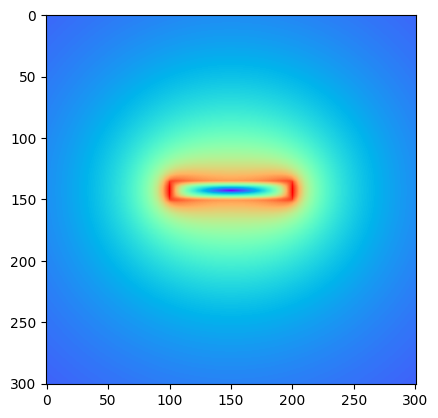

tensor(58.1176)

In [ ]:
xvt=torch.tensor(range(-150,151))*1E-9
X,Z=torch.meshgrid(xvt,xvt, indexing='ij')
Hx,Hz=rectangularWireField(12,1000,100E-9,15E-9,X,Z,x0=0,z0=-7e-9,currentDensity=True)
plt.imshow(0.5E12*torch.transpose(torch.sqrt(Hz**2+Hx**2),0,1),cmap='rainbow')
plt.show()
torch.mean(0.5E12*torch.transpose(torch.sqrt(Hz**2),0,1))

In [ ]:
def sPO1(fd,fielddir,fieldBias,excitationType,numElectrodes,config,sotFreq,current,constantP,wireWidth):
    nx,ny,nz=1600,1,1
    dy,dz=5E-8,50E-9
    curWvlen=wvlensFun1(fielddir*fieldBias,sotFreq)
    dx=min(1E-7,curWvlen/14)
    tstep=1E-4*dx
    pbcx,pbcy,pbcz=1,60,0
    dampLength=200
    imagex=list(range(400,1200))
    scalars_every,num_fields=5,2
    tendFactor,tonFactor=20,7
    record_scalar_fields,record_vector_fields=[],['external','torque']
    return nx,ny,nz,dx,dy,dz,pbcx,pbcy,pbcz,dampLength,imagex,scalars_every,num_fields,tstep,tendFactor,tonFactor,record_scalar_fields,record_vector_fields
run_sequence(fd=['x'],field_dirs=[np.array((1,0,0))],fieldBiasLis=[4E3,40E3,160E3],excitationTypeLis=['SOT','uStrip','both'],numElectrodesLis=[1,],configLis=['ap'],sotFreqLis=[8E9],nameFormat=['OneOffWithAniso_1ap_','fieldDir','fieldBias','kAm_','sotFreq','GHz_','excitationType'],simParamOverride=sPO1)

OneOffWithAniso_1ap_Fxbias4p0kAm_8p0GHz_SOT_data/
10% time ellapsed
20% time ellapsed
30% time ellapsed
40% time ellapsed
50% time ellapsed
60% time ellapsed
70% time ellapsed
80% time ellapsed
90% time ellapsed

TIMER REPORT
Operation                                                                                                                                                                         No of calls    Avg time [ms]    Total time [s]
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                                                                       10     22144.9          221.449
    ExternalField.h                                                                                      

In [ ]:
def sPO1(fd,fielddir,fieldBias,excitationType,numElectrodes,config,sotFreq,current,constantP,wireWidth):
    nx,ny,nz=1600,1,1
    dy,dz=5E-8,50E-9
    curWvlen=wvlensFun1(fielddir*fieldBias,sotFreq)
    dx=min(1E-7,curWvlen/14)
    tstep=1E-4*dx
    pbcx,pbcy,pbcz=1,60,0
    dampLength=200
    imagex=list(range(400,1200))
    scalars_every,num_fields=5,2
    tendFactor,tonFactor=20,7
    record_scalar_fields,record_vector_fields=[],['external','torque']
    return nx,ny,nz,dx,dy,dz,pbcx,pbcy,pbcz,dampLength,imagex,scalars_every,num_fields,tstep,tendFactor,tonFactor,record_scalar_fields,record_vector_fields
run_sequence(fd=['x'],field_dirs=[np.array((1,0,0))],fieldBiasLis=[4E3,40E3,160E3],excitationTypeLis=['SOT','uStrip','both'],numElectrodesLis=[1,],configLis=['ap'],sotFreqLis=[8E9],nameFormat=['OneOffWithoutAniso_1ap_','fieldDir','fieldBias','kAm_','sotFreq','GHz_','excitationType'],simParamOverride=sPO1,use_aniso=False)

OneOffWithoutAniso_1ap_Fxbias4p0kAm_8p0GHz_SOT_data/
10% time ellapsed
20% time ellapsed
30% time ellapsed
40% time ellapsed
50% time ellapsed
60% time ellapsed
70% time ellapsed
80% time ellapsed
90% time ellapsed

TIMER REPORT
Operation                                                                                                                                                                         No of calls    Avg time [ms]    Total time [s]
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                                                                       10     22144.9          221.449
    ExternalField.h                                                                                   

In [ ]:
interp25x=load_dispersion('dispersion/x_5mT.dat')
interp10y=load_dispersion('dispersion/y_10mT.dat')
interp25z=load_dispersion('dispersion/z_5mT.dat')
interp180x=load_dispersion('dispersion/x_190mT.dat')
interp180y=load_dispersion('dispersion/y_190mT.dat')
interp180z=load_dispersion('dispersion/z_190mT.dat')
def wvlensFun1(field,freq):
    freq=freq*1E-9
    fd,fv=0,0
    for i in range(3):
        if field[i]>fv:
            fv=field[i]
            fd=int(i)
    try:
        if fd==0 and fv<50E3:
            return float(interp25x(freq))
        elif fd==1 and fv<50E3:
            return float(interp10y(freq))
        elif fd==2 and fv<50E3:
            return float(interp25z(freq))
        elif fd==0 and fv>50E3:
            return float(interp180x(freq))
        elif fd==1 and fv>50E3:
            return float(interp180y(freq))
        elif fd==2 and fv>50E3:
            return float(interp180z(freq))
    except:
        return 1E-7


In [ ]:
#@title TheoryDispersionSweep
#os.mkdir('TheoryDispersionSweep')
def sPO1(fd,fielddir,fieldBias,excitationType,numElectrodes,config,sotFreq,current,constantP,wireWidth):
    nx,ny,nz=1600,1,1
    dy,dz=5E-8,20E-9
    curWvlen=wvlensFun1(fielddir*fieldBias,sotFreq)
    dx=min(1E-7,curWvlen/14)
    tstep=1E-4*dx
    pbcx,pbcy,pbcz=1,60,0
    dampLength=200
    imagex=list(range(400,1200))
    scalars_every,num_fields=5,2
    tendFactor,tonFactor=120,7
    record_scalar_fields,record_vector_fields=[],['external','torque']
    return nx,ny,nz,dx,dy,dz,pbcx,pbcy,pbcz,dampLength,imagex,scalars_every,num_fields,tstep,tendFactor,tonFactor,record_scalar_fields,record_vector_fields
run_sequence(fd=['x'],field_dirs=[np.array((1,0,0)),],fieldBiasLis=[150E3],excitationTypeLis=['SOT',],currentLis=[1e-5],numElectrodesLis=[1,],configLis=['p'],sotFreqLis=[7.36E9,7.65E9],
             nameFormat=['TheoryDispersionSOTSweep_yesAniso_','fieldDir','fieldBias','kAm_','sotFreq','GHz_','excitationType'],simParamOverride=sPO1,saveTo='TheoryDispersionSOTSweep/',use_aniso=True)
#run_sequence(fd=['y'],field_dirs=[np.array((0,1,0)),],fieldBiasLis=[150E3],excitationTypeLis=['uStrip',],currentLis=[1e-5],numElectrodesLis=[1,],configLis=['p'],sotFreqLis=[7.67E9,8.19E9,8.96E9,9.98E9,11.27E9],
#             nameFormat=['TheoryDispersionSweep_','fieldDir','fieldBias','kAm_','sotFreq','GHz_','excitationType'],simParamOverride=sPO1,saveTo='TheoryDispersionSweep/',use_aniso=False)
#run_sequence(fd=['z'],field_dirs=[np.array((0,0,1)),],fieldBiasLis=[150E3],excitationTypeLis=['uStrip',],currentLis=[1e-5],numElectrodesLis=[1,],configLis=['p'],sotFreqLis=[0.73E9,1.32E9,2.18E9,3.32E9,4.72E9],
#             nameFormat=['TheoryDispersionSweep_','fieldDir','fieldBias','kAm_','sotFreq','GHz_','excitationType'],simParamOverride=sPO1,saveTo='TheoryDispersionSweep/',use_aniso=False)

TheoryDispersionSOTSweep/TheoryDispersionSOTSweep_yesAniso_Fxbias150p0kAm_7p36GHz_SOT_data/
YIG alpha: 0.0002
10% time ellapsed
20% time ellapsed
30% time ellapsed
40% time ellapsed
50% time ellapsed
60% time ellapsed
70% time ellapsed
80% time ellapsed
90% time ellapsed


2024-05-31 22:25:12  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                             No of calls    Avg time [ms]    Total time [s]
----------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                            0
    ExternalField.h                             1         5.57734        0.00557734
    ExchangeField.h                             1      2392.56           2.39256
    DemagField.h                                0
        MinimizerBB.minimize                    1     28185.3           28.1853
            ExternalField.h                    12         0.17825        0.002139
            ExchangeField.h                    12         0.907845       0.0108941
            DemagField.h                       12      2340.18          28.0821
            CubicAnisotropyField.h             12         4.14115        0.0496938
        ExternalField.h                         3         0.280431       0.000841292
        SpinOrbitTorque.h                       3         

2024-05-31 22:33:48  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                             No of calls    Avg time [ms]    Total time [s]
----------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                            0
    ExternalField.h                             1         5.57734         0.00557734
    ExchangeField.h                             1      2392.56            2.39256
    DemagField.h                                0
        MinimizerBB.minimize                    2     24191.9            48.3837
            ExternalField.h                    24         0.160471        0.0038513
            ExchangeField.h                    24         0.822867        0.0197488
            DemagField.h                       24      2009.85           48.2364
            CubicAnisotropyField.h             24         2.69348         0.0646434
        ExternalField.h                         6         0.235685        0.00141411
        SpinOrbitTorque.h                       6 

In [ ]:
#@title TheoryDispersionSOTSweep
os.mkdir('TheoryDispersionSOTSweep')
def sPO1(fd,fielddir,fieldBias,excitationType,numElectrodes,config,sotFreq,current,constantP,wireWidth):
    nx,ny,nz=1600,1,1
    dy,dz=5E-8,20E-9
    curWvlen=wvlensFun1(fielddir*fieldBias,sotFreq)
    dx=min(1E-7,curWvlen/14)
    tstep=1E-4*dx
    pbcx,pbcy,pbcz=1,60,0
    dampLength=200
    imagex=list(range(400,1200))
    scalars_every,num_fields=5,2
    tendFactor,tonFactor=120,7
    record_scalar_fields,record_vector_fields=[],['external','torque']
    return nx,ny,nz,dx,dy,dz,pbcx,pbcy,pbcz,dampLength,imagex,scalars_every,num_fields,tstep,tendFactor,tonFactor,record_scalar_fields,record_vector_fields
run_sequence(fd=['x'],field_dirs=[np.array((1,0,0)),],fieldBiasLis=[150E3],excitationTypeLis=['SOT',],currentLis=[1e-5],numElectrodesLis=[1,],configLis=['p'],sotFreqLis=[7.36E9,7.65E9,8.23E9,9.1E9,10.26E9],
             nameFormat=['TheoryDispersionSOTSweep_','fieldDir','fieldBias','kAm_','sotFreq','GHz_','excitationType'],simParamOverride=sPO1,saveTo='TheoryDispersionSOTSweep/',use_aniso=False)
run_sequence(fd=['y'],field_dirs=[np.array((0,1,0)),],fieldBiasLis=[150E3],excitationTypeLis=['SOT',],currentLis=[1e-5],numElectrodesLis=[1,],configLis=['p'],sotFreqLis=[7.67E9,8.19E9,8.96E9,9.98E9,11.27E9],
             nameFormat=['TheoryDispersionSOTSweep_','fieldDir','fieldBias','kAm_','sotFreq','GHz_','excitationType'],simParamOverride=sPO1,saveTo='TheoryDispersionSOTSweep/',use_aniso=False)

TheoryDispersionSOTSweep/TheoryDispersionSOTSweep_Fxbias150p0kAm_7p4GHz_SOT_data/
10% time ellapsed
20% time ellapsed
30% time ellapsed
40% time ellapsed
50% time ellapsed
60% time ellapsed
70% time ellapsed
80% time ellapsed
90% time ellapsed


2024-05-16 16:27:40  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                                        No of calls    Avg time [ms]    Total time [s]
---------------------------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                                       0
    ExternalField.h                                                                                                                                        1        11.2762         0.0112762
    ExchangeField.h                                                                                                                                        1      2916.76           2.91676
    DemagField.h                                                   

2024-05-16 16:33:40  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                                        No of calls    Avg time [ms]    Total time [s]
---------------------------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                                       0
    ExternalField.h                                                                                                                                        1        11.2762         0.0112762
    ExchangeField.h                                                                                                                                        1      2916.76           2.91676
    DemagField.h                                                   

2024-05-16 16:41:52  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                                        No of calls    Avg time [ms]    Total time [s]
---------------------------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                                       0
    ExternalField.h                                                                                                                                        1        11.2762         0.0112762
    ExchangeField.h                                                                                                                                        1      2916.76           2.91676
    DemagField.h                                                   

2024-05-16 16:51:42  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                                        No of calls    Avg time [ms]    Total time [s]
---------------------------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                                       0
    ExternalField.h                                                                                                                                        1        11.2762         0.0112762
    ExchangeField.h                                                                                                                                        1      2916.76           2.91676
    DemagField.h                                                   

2024-05-16 17:02:25  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                                        No of calls    Avg time [ms]    Total time [s]
---------------------------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                                       0
    ExternalField.h                                                                                                                                        1        11.2762         0.0112762
    ExchangeField.h                                                                                                                                        1      2916.76           2.91676
    DemagField.h                                                   

2024-05-16 17:05:35  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                                        No of calls    Avg time [ms]    Total time [s]
---------------------------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                                       0
    ExternalField.h                                                                                                                                        1        11.2762         0.0112762
    ExchangeField.h                                                                                                                                        1      2916.76           2.91676
    DemagField.h                                                   

2024-05-16 17:11:03  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                                        No of calls    Avg time [ms]    Total time [s]
---------------------------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                                       0
    ExternalField.h                                                                                                                                        1        11.2762         0.0112762
    ExchangeField.h                                                                                                                                        1      2916.76           2.91676
    DemagField.h                                                   

2024-05-16 17:18:31  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                                        No of calls    Avg time [ms]    Total time [s]
---------------------------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                                       0
    ExternalField.h                                                                                                                                        1        11.2762         0.0112762
    ExchangeField.h                                                                                                                                        1      2916.76           2.91676
    DemagField.h                                                   

2024-05-16 17:27:28  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                                        No of calls    Avg time [ms]    Total time [s]
---------------------------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                                       0
    ExternalField.h                                                                                                                                        1        11.2762         0.0112762
    ExchangeField.h                                                                                                                                        1      2916.76           2.91676
    DemagField.h                                                   

2024-05-16 17:39:50  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                                        No of calls    Avg time [ms]    Total time [s]
---------------------------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                                       0
    ExternalField.h                                                                                                                                        1        11.2762         0.0112762
    ExchangeField.h                                                                                                                                        1      2916.76           2.91676
    DemagField.h                                                   

In [ ]:
#@title Theory No BVMSW Sweep
os.mkdir('TheoryNoBVMSWSweep')
def sPO1(fd,fielddir,fieldBias,excitationType,numElectrodes,config,sotFreq,current,constantP,wireWidth):
    nx,ny,nz=1600,1,1
    dy,dz=5E-8,20E-9
    curWvlen=wvlensFun1(fielddir*fieldBias,sotFreq)
    dx=min(1E-7,curWvlen/14)
    tstep=1E-4*dx
    pbcx,pbcy,pbcz=1,60,0
    dampLength=200
    imagex=list(range(400,1200))
    scalars_every,num_fields=5,2
    tendFactor,tonFactor=40,7
    record_scalar_fields,record_vector_fields=[],['external','torque']
    return nx,ny,nz,dx,dy,dz,pbcx,pbcy,pbcz,dampLength,imagex,scalars_every,num_fields,tstep,tendFactor,tonFactor,record_scalar_fields,record_vector_fields
run_sequence(fd=['x'],field_dirs=[np.array((1,0,0)),],fieldBiasLis=[150E3],excitationTypeLis=['uStrip','SOT','Both'],currentLis=[1e-5,1e-4,1e-3],numElectrodesLis=[1,],configLis=['p'],sotFreqLis=[7.65E9,8.23E9,10.26E9],
             nameFormat=['TheoryNoBVMSWSweep_noAniso_','fieldDir','fieldBias','kAm_','sotFreq','GHz_','current','mA_','excitationType'],simParamOverride=sPO1,saveTo='TheoryNoBVMSWSweep/',use_aniso=False)
run_sequence(fd=['x'],field_dirs=[np.array((1,0,0)),],fieldBiasLis=[150E3],excitationTypeLis=['uStrip','SOT','Both'],currentLis=[1e-5,1e-4,1e-3],numElectrodesLis=[1,],configLis=['p'],sotFreqLis=[7.65E9,8.23E9,10.26E9],
             nameFormat=['TheoryNoBVMSWSweep_yesAniso_','fieldDir','fieldBias','kAm_','sotFreq','GHz_','current','mA_','excitationType'],simParamOverride=sPO1,saveTo='TheoryNoBVMSWSweep/',use_aniso=True)

TheoryNoBVMSWSweep/TheoryNoBVMSWSweep_noAniso_Fxbias150p0kAm_7p7GHz_0p0mA_uStrip_data/
10% time ellapsed
20% time ellapsed
30% time ellapsed
40% time ellapsed
50% time ellapsed
60% time ellapsed
70% time ellapsed
80% time ellapsed
90% time ellapsed


2024-05-13 18:14:56  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                    0
    ExternalField.h                                                                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                                                                     1      2916.76           2.91676
    DemagField.h                                                                                                                        0
        MinimizerBB.mini

2024-05-13 18:17:05  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                    0
    ExternalField.h                                                                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                                                                     1      2916.76           2.91676
    DemagField.h                                                                                                                        0
        MinimizerBB.mini

2024-05-13 18:19:16  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                    0
    ExternalField.h                                                                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                                                                     1      2916.76           2.91676
    DemagField.h                                                                                                                        0
        MinimizerBB.mini

2024-05-13 18:22:08  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                    0
    ExternalField.h                                                                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                                                                     1      2916.76           2.91676
    DemagField.h                                                                                                                        0
        MinimizerBB.mini

2024-05-13 18:24:58  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                    0
    ExternalField.h                                                                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                                                                     1      2916.76           2.91676
    DemagField.h                                                                                                                        0
        MinimizerBB.mini

2024-05-13 18:27:49  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                    0
    ExternalField.h                                                                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                                                                     1      2916.76           2.91676
    DemagField.h                                                                                                                        0
        MinimizerBB.mini

2024-05-13 18:31:33  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                    0
    ExternalField.h                                                                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                                                                     1      2916.76           2.91676
    DemagField.h                                                                                                                        0
        MinimizerBB.mini

2024-05-13 18:35:20  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                    0
    ExternalField.h                                                                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                                                                     1      2916.76           2.91676
    DemagField.h                                                                                                                        0
        MinimizerBB.mini

2024-05-13 18:39:08  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                    0
    ExternalField.h                                                                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                                                                     1      2916.76           2.91676
    DemagField.h                                                                                                                        0
        MinimizerBB.mini

2024-05-13 18:41:08  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                    0
    ExternalField.h                                                                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                                                                     1      2916.76           2.91676
    DemagField.h                                                                                                                        0
        MinimizerBB.mini

2024-05-13 18:43:07  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                    0
    ExternalField.h                                                                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                                                                     1      2916.76           2.91676
    DemagField.h                                                                                                                        0
        MinimizerBB.mini

2024-05-13 18:45:14  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                    0
    ExternalField.h                                                                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                                                                     1      2916.76           2.91676
    DemagField.h                                                                                                                        0
        MinimizerBB.mini

2024-05-13 18:47:56  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                    0
    ExternalField.h                                                                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                                                                     1      2916.76           2.91676
    DemagField.h                                                                                                                        0
        MinimizerBB.mini

2024-05-13 18:50:32  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                    0
    ExternalField.h                                                                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                                                                     1      2916.76           2.91676
    DemagField.h                                                                                                                        0
        MinimizerBB.mini

2024-05-13 18:53:19  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                    0
    ExternalField.h                                                                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                                                                     1      2916.76           2.91676
    DemagField.h                                                                                                                        0
        MinimizerBB.mini

2024-05-13 18:56:45  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                    0
    ExternalField.h                                                                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                                                                     1      2916.76           2.91676
    DemagField.h                                                                                                                        0
        MinimizerBB.mini

2024-05-13 19:00:15  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                    0
    ExternalField.h                                                                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                                                                     1      2916.76           2.91676
    DemagField.h                                                                                                                        0
        MinimizerBB.mini

2024-05-13 19:03:44  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                    0
    ExternalField.h                                                                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                                                                     1      2916.76           2.91676
    DemagField.h                                                                                                                        0
        MinimizerBB.mini

2024-05-13 19:06:15  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                    0
    ExternalField.h                                                                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                                                                     1      2916.76           2.91676
    DemagField.h                                                                                                                        0
        MinimizerBB.mini

2024-05-13 19:08:42  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                    0
    ExternalField.h                                                                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                                                                     1      2916.76           2.91676
    DemagField.h                                                                                                                        0
        MinimizerBB.mini

2024-05-13 19:11:12  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                    0
    ExternalField.h                                                                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                                                                     1      2916.76           2.91676
    DemagField.h                                                                                                                        0
        MinimizerBB.mini

2024-05-13 19:14:31  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                    0
    ExternalField.h                                                                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                                                                     1      2916.76           2.91676
    DemagField.h                                                                                                                        0
        MinimizerBB.mini

2024-05-13 19:17:49  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                    0
    ExternalField.h                                                                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                                                                     1      2916.76           2.91676
    DemagField.h                                                                                                                        0
        MinimizerBB.mini

2024-05-13 19:21:09  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                    0
    ExternalField.h                                                                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                                                                     1      2916.76           2.91676
    DemagField.h                                                                                                                        0
        MinimizerBB.mini

2024-05-13 19:25:32  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                    0
    ExternalField.h                                                                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                                                                     1      2916.76           2.91676
    DemagField.h                                                                                                                        0
        MinimizerBB.mini

2024-05-13 19:30:01  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                    0
    ExternalField.h                                                                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                                                                     1      2916.76           2.91676
    DemagField.h                                                                                                                        0
        MinimizerBB.mini

2024-05-13 19:34:22  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                    0
    ExternalField.h                                                                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                                                                     1      2916.76           2.91676
    DemagField.h                                                                                                                        0
        MinimizerBB.mini

2024-05-13 19:37:10  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                    0
    ExternalField.h                                                                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                                                                     1      2916.76           2.91676
    DemagField.h                                                                                                                        0
        MinimizerBB.mini

2024-05-13 19:39:55  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                    0
    ExternalField.h                                                                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                                                                     1      2916.76           2.91676
    DemagField.h                                                                                                                        0
        MinimizerBB.mini

2024-05-13 19:42:39  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                    0
    ExternalField.h                                                                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                                                                     1      2916.76           2.91676
    DemagField.h                                                                                                                        0
        MinimizerBB.mini

2024-05-13 19:46:21  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                    0
    ExternalField.h                                                                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                                                                     1      2916.76           2.91676
    DemagField.h                                                                                                                        0
        MinimizerBB.mini

2024-05-13 19:50:03  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                    0
    ExternalField.h                                                                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                                                                     1      2916.76           2.91676
    DemagField.h                                                                                                                        0
        MinimizerBB.mini

2024-05-13 19:53:52  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                    0
    ExternalField.h                                                                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                                                                     1      2916.76           2.91676
    DemagField.h                                                                                                                        0
        MinimizerBB.mini

2024-05-13 19:58:53  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                    0
    ExternalField.h                                                                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                                                                     1      2916.76           2.91676
    DemagField.h                                                                                                                        0
        MinimizerBB.mini

2024-05-13 20:03:56  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                    0
    ExternalField.h                                                                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                                                                     1      2916.76           2.91676
    DemagField.h                                                                                                                        0
        MinimizerBB.mini

2024-05-13 20:09:12  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                    0
    ExternalField.h                                                                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                                                                     1      2916.76           2.91676
    DemagField.h                                                                                                                        0
        MinimizerBB.mini

2024-05-13 20:14:32  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                    0
    ExternalField.h                                                                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                                                                     1      2916.76           2.91676
    DemagField.h                                                                                                                        0
        MinimizerBB.mini

2024-05-13 20:18:32  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                    0
    ExternalField.h                                                                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                                                                     1      2916.76           2.91676
    DemagField.h                                                                                                                        0
        MinimizerBB.mini

2024-05-13 20:23:08  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                    0
    ExternalField.h                                                                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                                                                     1      2916.76           2.91676
    DemagField.h                                                                                                                        0
        MinimizerBB.mini

2024-05-13 20:26:40  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                    0
    ExternalField.h                                                                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                                                                     1      2916.76           2.91676
    DemagField.h                                                                                                                        0
        MinimizerBB.mini

2024-05-13 20:31:39  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                    0
    ExternalField.h                                                                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                                                                     1      2916.76           2.91676
    DemagField.h                                                                                                                        0
        MinimizerBB.mini

2024-05-13 20:38:00  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                    0
    ExternalField.h                                                                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                                                                     1      2916.76           2.91676
    DemagField.h                                                                                                                        0
        MinimizerBB.mini

2024-05-13 20:42:28  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                    0
    ExternalField.h                                                                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                                                                     1      2916.76           2.91676
    DemagField.h                                                                                                                        0
        MinimizerBB.mini

2024-05-13 20:46:45  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                    0
    ExternalField.h                                                                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                                                                     1      2916.76           2.91676
    DemagField.h                                                                                                                        0
        MinimizerBB.mini

2024-05-13 20:51:30  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                    0
    ExternalField.h                                                                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                                                                     1      2916.76           2.91676
    DemagField.h                                                                                                                        0
        MinimizerBB.mini

2024-05-13 20:55:19  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                    0
    ExternalField.h                                                                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                                                                     1      2916.76           2.91676
    DemagField.h                                                                                                                        0
        MinimizerBB.mini

2024-05-13 21:01:35  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                    0
    ExternalField.h                                                                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                                                                     1      2916.76           2.91676
    DemagField.h                                                                                                                        0
        MinimizerBB.mini

2024-05-13 21:04:35  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                    0
    ExternalField.h                                                                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                                                                     1      2916.76           2.91676
    DemagField.h                                                                                                                        0
        MinimizerBB.mini

2024-05-13 21:10:48  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                    0
    ExternalField.h                                                                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                                                                     1      2916.76           2.91676
    DemagField.h                                                                                                                        0
        MinimizerBB.mini

2024-05-13 21:14:54  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                    0
    ExternalField.h                                                                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                                                                     1      2916.76           2.91676
    DemagField.h                                                                                                                        0
        MinimizerBB.mini

2024-05-13 21:18:51  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                    0
    ExternalField.h                                                                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                                                                     1      2916.76           2.91676
    DemagField.h                                                                                                                        0
        MinimizerBB.mini

2024-05-13 21:24:16  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                    0
    ExternalField.h                                                                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                                                                     1      2916.76           2.91676
    DemagField.h                                                                                                                        0
        MinimizerBB.mini

2024-05-13 21:29:39  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                    0
    ExternalField.h                                                                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                                                                     1      2916.76           2.91676
    DemagField.h                                                                                                                        0
        MinimizerBB.mini

2024-05-13 21:34:52  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                    0
    ExternalField.h                                                                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                                                                     1      2916.76           2.91676
    DemagField.h                                                                                                                        0
        MinimizerBB.mini

In [ ]:
#@title Theory MSSW Nonlin2 Sweep
#os.mkdir('TheoryMSSWNonlin2Sweep')
def sPO1(fd,fielddir,fieldBias,excitationType,numElectrodes,config,sotFreq,current,constantP,wireWidth):
    nx,ny,nz=1600,1,1
    dy,dz=5E-8,20E-9
    curWvlen=wvlensFun1(fielddir*fieldBias,sotFreq)
    dx=min(1E-7,curWvlen/10)
    tstep=1E-4*dx
    pbcx,pbcy,pbcz=1,60,0
    dampLength=200
    imagex=list(range(400,1200))
    scalars_every,num_fields=5,2
    tendFactor,tonFactor=40,7
    record_scalar_fields,record_vector_fields=[],['external','torque']
    return nx,ny,nz,dx,dy,dz,pbcx,pbcy,pbcz,dampLength,imagex,scalars_every,num_fields,tstep,tendFactor,tonFactor,record_scalar_fields,record_vector_fields
run_sequence(fd=['y'],field_dirs=[np.array((0,1,0)),],fieldBiasLis=[8E3,],excitationTypeLis=['uStrip','SOT'],currentLis=[20e-3],numElectrodesLis=[1,],configLis=['p'],sotFreqLis=[4.72E9],
             nameFormat=['TheoryMSSWNonlin2Sweep_NoDampDemagKernal5_','fieldDir','fieldBias','kAm_','sotFreq','GHz_','current','mA_','excitationType'],simParamOverride=sPO1,saveTo='TheoryMSSWNonlin2Sweep/',use_aniso=False)

TheoryMSSWNonlin2Sweep/TheoryMSSWNonlin2Sweep_NoDampDemagKernal5_Fybias8p0kAm_4p72GHz_20p0mA_uStrip_data/
YIG alpha: 0
10% time ellapsed
20% time ellapsed
30% time ellapsed
40% time ellapsed
50% time ellapsed
60% time ellapsed
70% time ellapsed
80% time ellapsed
90% time ellapsed


2024-06-03 20:33:26  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                No of calls    Avg time [ms]    Total time [s]
-------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                               0
    ExternalField.h                                1         5.57734         0.00557734
    ExchangeField.h                                1      2392.56            2.39256
    DemagField.h                                   0
        MinimizerBB.minimize                       2     24191.9            48.3837
            ExternalField.h                       25         1.12169         0.0280423
            ExchangeField.h                       25         1.58689         0.0396722
            DemagField.h                          24      2009.85           48.2364
                MinimizerBB.minimize              14     13614.1           190.598
                    ExternalField.h              690         0.868779        0.599457
                    

2024-06-03 20:37:21  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                No of calls    Avg time [ms]    Total time [s]
-------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                               0
    ExternalField.h                                1         5.57734         0.00557734
    ExchangeField.h                                1      2392.56            2.39256
    DemagField.h                                   0
        MinimizerBB.minimize                       2     24191.9            48.3837
            ExternalField.h                       25         1.12169         0.0280423
            ExchangeField.h                       25         1.58689         0.0396722
            DemagField.h                          24      2009.85           48.2364
                MinimizerBB.minimize              15     13450.2           201.754
                    ExternalField.h              700         0.858238        0.600766
                    

In [ ]:
#@title Theory MSSW Asym Sweep
os.mkdir('TheoryMSSWAsymSweep')
def sPO1(fd,fielddir,fieldBias,excitationType,numElectrodes,config,sotFreq,current,constantP,wireWidth):
    nx,ny,nz=1600,1,1
    dy,dz=5E-8,20E-9
    curWvlen=wvlensFun1(fielddir*fieldBias,sotFreq)
    dx=min(1E-7,curWvlen/14)
    tstep=1E-4*dx
    pbcx,pbcy,pbcz=1,60,0
    dampLength=200
    imagex=list(range(400,1200))
    scalars_every,num_fields=5,2
    tendFactor,tonFactor=40,7
    record_scalar_fields,record_vector_fields=[],['external','torque']
    return nx,ny,nz,dx,dy,dz,pbcx,pbcy,pbcz,dampLength,imagex,scalars_every,num_fields,tstep,tendFactor,tonFactor,record_scalar_fields,record_vector_fields
run_sequence(fd=['y'],field_dirs=[np.array((0,1,0)),],fieldBiasLis=[150E3],excitationTypeLis=['uStrip','SOT','Both'],currentLis=[1e-5,1e-4,1e-3],numElectrodesLis=[1,],configLis=['p'],sotFreqLis=[8.19E9,9.98E9,11.27E9],
             nameFormat=['TheoryMSSWAsymSweep_','fieldDir','fieldBias','kAm_','sotFreq','GHz_','current','mA_','excitationType'],simParamOverride=sPO1,saveTo='TheoryMSSWAsymSweep/',use_aniso=False)

TheoryMSSWAsymSweep/TheoryMSSWAsymSweep_Fybias150p0kAm_8p2GHz_0p0mA_uStrip_data/
10% time ellapsed
20% time ellapsed
30% time ellapsed
40% time ellapsed
50% time ellapsed
60% time ellapsed
70% time ellapsed
80% time ellapsed
90% time ellapsed


2024-05-13 21:36:44  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                    0
    ExternalField.h                                                                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                                                                     1      2916.76           2.91676
    DemagField.h                                                                                                                        0
        MinimizerBB.mini

2024-05-13 21:38:37  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                    0
    ExternalField.h                                                                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                                                                     1      2916.76           2.91676
    DemagField.h                                                                                                                        0
        MinimizerBB.mini

2024-05-13 21:40:37  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                    0
    ExternalField.h                                                                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                                                                     1      2916.76           2.91676
    DemagField.h                                                                                                                        0
        MinimizerBB.mini

2024-05-13 21:43:32  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                    0
    ExternalField.h                                                                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                                                                     1      2916.76           2.91676
    DemagField.h                                                                                                                        0
        MinimizerBB.mini

2024-05-13 21:46:33  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                    0
    ExternalField.h                                                                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                                                                     1      2916.76           2.91676
    DemagField.h                                                                                                                        0
        MinimizerBB.mini

2024-05-13 21:49:29  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                    0
    ExternalField.h                                                                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                                                                     1      2916.76           2.91676
    DemagField.h                                                                                                                        0
        MinimizerBB.mini

2024-05-13 21:53:34  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                    0
    ExternalField.h                                                                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                                                                     1      2916.76           2.91676
    DemagField.h                                                                                                                        0
        MinimizerBB.mini

2024-05-13 21:57:38  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                    0
    ExternalField.h                                                                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                                                                     1      2916.76           2.91676
    DemagField.h                                                                                                                        0
        MinimizerBB.mini

2024-05-13 22:01:38  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                    0
    ExternalField.h                                                                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                                                                     1      2916.76           2.91676
    DemagField.h                                                                                                                        0
        MinimizerBB.mini

2024-05-13 22:03:28  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                    0
    ExternalField.h                                                                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                                                                     1      2916.76           2.91676
    DemagField.h                                                                                                                        0
        MinimizerBB.mini

2024-05-13 22:05:16  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                    0
    ExternalField.h                                                                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                                                                     1      2916.76           2.91676
    DemagField.h                                                                                                                        0
        MinimizerBB.mini

2024-05-13 22:07:01  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                    0
    ExternalField.h                                                                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                                                                     1      2916.76           2.91676
    DemagField.h                                                                                                                        0
        MinimizerBB.mini

2024-05-13 22:09:50  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                    0
    ExternalField.h                                                                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                                                                     1      2916.76           2.91676
    DemagField.h                                                                                                                        0
        MinimizerBB.mini

2024-05-13 22:12:36  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                    0
    ExternalField.h                                                                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                                                                     1      2916.76           2.91676
    DemagField.h                                                                                                                        0
        MinimizerBB.mini

2024-05-13 22:15:42  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                    0
    ExternalField.h                                                                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                                                                     1      2916.76           2.91676
    DemagField.h                                                                                                                        0
        MinimizerBB.mini

2024-05-13 22:19:57  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                    0
    ExternalField.h                                                                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                                                                     1      2916.76           2.91676
    DemagField.h                                                                                                                        0
        MinimizerBB.mini

2024-05-13 22:24:06  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                    0
    ExternalField.h                                                                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                                                                     1      2916.76           2.91676
    DemagField.h                                                                                                                        0
        MinimizerBB.mini

2024-05-13 22:28:13  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                    0
    ExternalField.h                                                                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                                                                     1      2916.76           2.91676
    DemagField.h                                                                                                                        0
        MinimizerBB.mini

2024-05-13 22:30:34  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                    0
    ExternalField.h                                                                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                                                                     1      2916.76           2.91676
    DemagField.h                                                                                                                        0
        MinimizerBB.mini

2024-05-13 22:32:56  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                    0
    ExternalField.h                                                                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                                                                     1      2916.76           2.91676
    DemagField.h                                                                                                                        0
        MinimizerBB.mini

2024-05-13 22:35:18  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                    0
    ExternalField.h                                                                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                                                                     1      2916.76           2.91676
    DemagField.h                                                                                                                        0
        MinimizerBB.mini

2024-05-13 22:38:59  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                    0
    ExternalField.h                                                                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                                                                     1      2916.76           2.91676
    DemagField.h                                                                                                                        0
        MinimizerBB.mini

2024-05-13 22:42:44  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                    0
    ExternalField.h                                                                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                                                                     1      2916.76           2.91676
    DemagField.h                                                                                                                        0
        MinimizerBB.mini

2024-05-13 22:46:34  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                    0
    ExternalField.h                                                                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                                                                     1      2916.76           2.91676
    DemagField.h                                                                                                                        0
        MinimizerBB.mini

2024-05-13 22:51:52  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                    0
    ExternalField.h                                                                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                                                                     1      2916.76           2.91676
    DemagField.h                                                                                                                        0
        MinimizerBB.mini

2024-05-13 22:57:10  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                    0
    ExternalField.h                                                                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                                                                     1      2916.76           2.91676
    DemagField.h                                                                                                                        0
        MinimizerBB.mini

2024-05-13 23:02:26  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                    0
    ExternalField.h                                                                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                                                                     1      2916.76           2.91676
    DemagField.h                                                                                                                        0
        MinimizerBB.mini

In [ ]:
#@title Theory MSSW Asym Long Sweep
os.mkdir('TheoryMSSWAsymLongSweep')
def sPO1(fd,fielddir,fieldBias,excitationType,numElectrodes,config,sotFreq,current,constantP,wireWidth):
    nx,ny,nz=1600,1,1
    dy,dz=5E-8,20E-9
    curWvlen=wvlensFun1(fielddir*fieldBias,sotFreq)
    dx=min(1E-7,curWvlen/10)
    tstep=1E-4*dx
    pbcx,pbcy,pbcz=1,60,0
    dampLength=200
    imagex=list(range(400,1200))
    scalars_every,num_fields=5,2
    tendFactor,tonFactor=100,7
    record_scalar_fields,record_vector_fields=[],['external','torque']
    return nx,ny,nz,dx,dy,dz,pbcx,pbcy,pbcz,dampLength,imagex,scalars_every,num_fields,tstep,tendFactor,tonFactor,record_scalar_fields,record_vector_fields
run_sequence(fd=['y'],field_dirs=[np.array((0,1,0)),],fieldBiasLis=[150E3],excitationTypeLis=['uStrip','SOT','Both'],currentLis=[1e-4],numElectrodesLis=[1,],configLis=['p'],sotFreqLis=[9.98E9],
             nameFormat=['TheoryMSSWAsymLongSweep_','fieldDir','fieldBias','kAm_','sotFreq','GHz_','current','mA_','excitationType'],simParamOverride=sPO1,saveTo='TheoryMSSWAsymLongSweep/',use_aniso=False)

TheoryMSSWAsymLongSweep/TheoryMSSWAsymLongSweep_Fybias150p0kAm_10p0GHz_0p1mA_uStrip_data/
10% time ellapsed
20% time ellapsed
30% time ellapsed
40% time ellapsed
50% time ellapsed
60% time ellapsed
70% time ellapsed
80% time ellapsed
90% time ellapsed


2024-05-15 19:45:42  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                                        No of calls    Avg time [ms]    Total time [s]
---------------------------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                                       0
    ExternalField.h                                                                                                                                        1        11.2762         0.0112762
    ExchangeField.h                                                                                                                                        1      2916.76           2.91676
    DemagField.h                                                   

2024-05-15 19:51:20  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                                        No of calls    Avg time [ms]    Total time [s]
---------------------------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                                       0
    ExternalField.h                                                                                                                                        1        11.2762         0.0112762
    ExchangeField.h                                                                                                                                        1      2916.76           2.91676
    DemagField.h                                                   

2024-05-15 19:58:48  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                                        No of calls    Avg time [ms]    Total time [s]
---------------------------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                                       0
    ExternalField.h                                                                                                                                        1        11.2762         0.0112762
    ExchangeField.h                                                                                                                                        1      2916.76           2.91676
    DemagField.h                                                   

In [ ]:
#@title Theory FVMSW Phase Sweep
#os.mkdir('TheoryFVMSWPhaseSweep')
def sPO1(fd,fielddir,fieldBias,excitationType,numElectrodes,config,sotFreq,current,constantP,wireWidth):
    nx,ny,nz=1600,1,1
    dy,dz=5E-8,20E-9
    curWvlen=wvlensFun1(fielddir*fieldBias,sotFreq)
    dx=min(1E-7,curWvlen/14)
    tstep=1E-4*dx
    pbcx,pbcy,pbcz=1,60,0
    dampLength=200
    imagex=list(range(400,1200))
    scalars_every,num_fields=5,2
    tendFactor,tonFactor=40,7
    record_scalar_fields,record_vector_fields=[],['external','torque']
    return nx,ny,nz,dx,dy,dz,pbcx,pbcy,pbcz,dampLength,imagex,scalars_every,num_fields,tstep,tendFactor,tonFactor,record_scalar_fields,record_vector_fields
run_sequence(fd=['z'],field_dirs=[np.array((0,0,1)),],fieldBiasLis=[150E3],excitationTypeLis=['uStrip','SOT'],currentLis=[1e-5],numElectrodesLis=[1,],configLis=['p'],sotFreqLis=[4.72E9],wireHeightLis=[15e-9,15e-9,15e-9],wireWidthLis=[135e-9,130e-9,125e-9],
             nameFormat=['TheoryFVMSWPhaseSweep_','fieldDir','fieldBias','kAm_','sotFreq','GHz_','current','mA_','wireWidth','nm_','excitationType'],simParamOverride=sPO1,saveTo='TheoryFVMSWPhaseSweep/',use_aniso=False)

TheoryFVMSWPhaseSweep/TheoryFVMSWPhaseSweep_Fzbias150p0kAm_4p72GHz_0p0mA_135nm_uStrip_data/
YIG alpha: 0.0002
10% time ellapsed
20% time ellapsed
30% time ellapsed
40% time ellapsed
50% time ellapsed
60% time ellapsed
70% time ellapsed
80% time ellapsed
90% time ellapsed


2024-06-04 01:07:30  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                        No of calls    Avg time [ms]    Total time [s]
---------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                       0
    ExternalField.h                                        1         5.57734         0.00557734
    ExchangeField.h                                        1      2392.56            2.39256
    DemagField.h                                           0
        MinimizerBB.minimize                               2     24191.9            48.3837
            ExternalField.h                               25         1.12169         0.0280423
            ExchangeField.h                               25         1.58689         0.0396722
            DemagField.h                                  24      2009.85           48.2364
                MinimizerBB.minimize                      15     13450.2           201.754
                  

2024-06-04 01:18:52  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                        No of calls    Avg time [ms]    Total time [s]
---------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                       0
    ExternalField.h                                        1         5.57734         0.00557734
    ExchangeField.h                                        1      2392.56            2.39256
    DemagField.h                                           0
        MinimizerBB.minimize                               2     24191.9            48.3837
            ExternalField.h                               25         1.12169         0.0280423
            ExchangeField.h                               25         1.58689         0.0396722
            DemagField.h                                  24      2009.85           48.2364
                MinimizerBB.minimize                      15     13450.2           201.754
                  

2024-06-04 01:30:29  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                        No of calls    Avg time [ms]    Total time [s]
---------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                       0
    ExternalField.h                                        1         5.57734         0.00557734
    ExchangeField.h                                        1      2392.56            2.39256
    DemagField.h                                           0
        MinimizerBB.minimize                               2     24191.9            48.3837
            ExternalField.h                               25         1.12169         0.0280423
            ExchangeField.h                               25         1.58689         0.0396722
            DemagField.h                                  24      2009.85           48.2364
                MinimizerBB.minimize                      15     13450.2           201.754
                  

2024-06-04 01:40:25  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                        No of calls    Avg time [ms]    Total time [s]
---------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                       0
    ExternalField.h                                        1         5.57734         0.00557734
    ExchangeField.h                                        1      2392.56            2.39256
    DemagField.h                                           0
        MinimizerBB.minimize                               2     24191.9            48.3837
            ExternalField.h                               25         1.12169         0.0280423
            ExchangeField.h                               25         1.58689         0.0396722
            DemagField.h                                  24      2009.85           48.2364
                MinimizerBB.minimize                      15     13450.2           201.754
                  

2024-06-04 01:50:00  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                        No of calls    Avg time [ms]    Total time [s]
---------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                       0
    ExternalField.h                                        1         5.57734         0.00557734
    ExchangeField.h                                        1      2392.56            2.39256
    DemagField.h                                           0
        MinimizerBB.minimize                               2     24191.9            48.3837
            ExternalField.h                               25         1.12169         0.0280423
            ExchangeField.h                               25         1.58689         0.0396722
            DemagField.h                                  24      2009.85           48.2364
                MinimizerBB.minimize                      15     13450.2           201.754
                  

2024-06-04 01:59:38  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                        No of calls    Avg time [ms]    Total time [s]
---------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                       0
    ExternalField.h                                        1         5.57734         0.00557734
    ExchangeField.h                                        1      2392.56            2.39256
    DemagField.h                                           0
        MinimizerBB.minimize                               2     24191.9            48.3837
            ExternalField.h                               25         1.12169         0.0280423
            ExchangeField.h                               25         1.58689         0.0396722
            DemagField.h                                  24      2009.85           48.2364
                MinimizerBB.minimize                      15     13450.2           201.754
                  

In [ ]:
#@title Theory FVMSW Freq Sweep
os.mkdir('TheoryFVMSWFreqSweep')
def sPO1(fd,fielddir,fieldBias,excitationType,numElectrodes,config,sotFreq,current,constantP,wireWidth):
    nx,ny,nz=1600,1,1
    dy,dz=5E-8,20E-9
    curWvlen=wvlensFun1(fielddir*fieldBias,sotFreq)
    dx=min(1E-7,curWvlen/14)
    tstep=1E-4*dx
    pbcx,pbcy,pbcz=1,60,0
    dampLength=200
    imagex=list(range(400,1200))
    scalars_every,num_fields=5,2
    tendFactor,tonFactor=40,7
    record_scalar_fields,record_vector_fields=[],['external','torque']
    return nx,ny,nz,dx,dy,dz,pbcx,pbcy,pbcz,dampLength,imagex,scalars_every,num_fields,tstep,tendFactor,tonFactor,record_scalar_fields,record_vector_fields
run_sequence(fd=['z'],field_dirs=[np.array((0,0,1)),],fieldBiasLis=[150E3],excitationTypeLis=['uStrip','SOT','Both'],currentLis=[1e-5,1e-4,1e-3],numElectrodesLis=[1,],configLis=['p'],sotFreqLis=[1.32E9,4.72E9,6E9,8E9,10E9,12E9],
             nameFormat=['TheoryFVMSWFreqSweep_','fieldDir','fieldBias','kAm_','sotFreq','GHz_','current','mA_','excitationType'],simParamOverride=sPO1,saveTo='TheoryFVMSWFreqSweep/',use_aniso=False)

TheoryFVMSWFreqSweep/TheoryFVMSWFreqSweep_Fzbias150p0kAm_1p3GHz_0p0mA_uStrip_data/
10% time ellapsed
20% time ellapsed
30% time ellapsed
40% time ellapsed
50% time ellapsed
60% time ellapsed
70% time ellapsed
80% time ellapsed
90% time ellapsed


2024-05-14 00:44:49  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                    0
    ExternalField.h                                                                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                                                                     1      2916.76           2.91676
    DemagField.h                                                                                                                        0
        MinimizerBB.mini

2024-05-14 00:56:07  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                    0
    ExternalField.h                                                                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                                                                     1      2916.76           2.91676
    DemagField.h                                                                                                                        0
        MinimizerBB.mini

2024-05-14 01:08:25  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                    0
    ExternalField.h                                                                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                                                                     1      2916.76           2.91676
    DemagField.h                                                                                                                        0
        MinimizerBB.mini

2024-05-14 01:19:09  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                    0
    ExternalField.h                                                                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                                                                     1      2916.76           2.91676
    DemagField.h                                                                                                                        0
        MinimizerBB.mini

2024-05-14 01:29:39  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                    0
    ExternalField.h                                                                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                                                                     1      2916.76           2.91676
    DemagField.h                                                                                                                        0
        MinimizerBB.mini

2024-05-14 01:40:06  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                    0
    ExternalField.h                                                                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                                                                     1      2916.76           2.91676
    DemagField.h                                                                                                                        0
        MinimizerBB.mini

2024-05-14 01:48:16  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                    0
    ExternalField.h                                                                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                                                                     1      2916.76           2.91676
    DemagField.h                                                                                                                        0
        MinimizerBB.mini

2024-05-14 01:56:22  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                    0
    ExternalField.h                                                                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                                                                     1      2916.76           2.91676
    DemagField.h                                                                                                                        0
        MinimizerBB.mini

2024-05-14 02:04:37  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                    0
    ExternalField.h                                                                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                                                                     1      2916.76           2.91676
    DemagField.h                                                                                                                        0
        MinimizerBB.mini

2024-05-14 02:10:41  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                    0
    ExternalField.h                                                                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                                                                     1      2916.76           2.91676
    DemagField.h                                                                                                                        0
        MinimizerBB.mini

2024-05-14 02:16:44  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                    0
    ExternalField.h                                                                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                                                                     1      2916.76           2.91676
    DemagField.h                                                                                                                        0
        MinimizerBB.mini

2024-05-14 02:22:50  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                    0
    ExternalField.h                                                                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                                                                     1      2916.76           2.91676
    DemagField.h                                                                                                                        0
        MinimizerBB.mini

2024-05-14 02:27:39  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                    0
    ExternalField.h                                                                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                                                                     1      2916.76           2.91676
    DemagField.h                                                                                                                        0
        MinimizerBB.mini

2024-05-14 02:32:27  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                    0
    ExternalField.h                                                                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                                                                     1      2916.76           2.91676
    DemagField.h                                                                                                                        0
        MinimizerBB.mini

2024-05-14 02:37:22  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                    0
    ExternalField.h                                                                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                                                                     1      2916.76           2.91676
    DemagField.h                                                                                                                        0
        MinimizerBB.mini

2024-05-14 02:41:26  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                    0
    ExternalField.h                                                                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                                                                     1      2916.76           2.91676
    DemagField.h                                                                                                                        0
        MinimizerBB.mini

2024-05-14 02:45:31  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                    0
    ExternalField.h                                                                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                                                                     1      2916.76           2.91676
    DemagField.h                                                                                                                        0
        MinimizerBB.mini

2024-05-14 02:49:34  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                    0
    ExternalField.h                                                                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                                                                     1      2916.76           2.91676
    DemagField.h                                                                                                                        0
        MinimizerBB.mini

2024-05-14 03:00:16  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                    0
    ExternalField.h                                                                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                                                                     1      2916.76           2.91676
    DemagField.h                                                                                                                        0
        MinimizerBB.mini

2024-05-14 03:10:55  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                    0
    ExternalField.h                                                                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                                                                     1      2916.76           2.91676
    DemagField.h                                                                                                                        0
        MinimizerBB.mini

2024-05-14 03:21:31  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                    0
    ExternalField.h                                                                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                                                                     1      2916.76           2.91676
    DemagField.h                                                                                                                        0
        MinimizerBB.mini

2024-05-14 03:30:52  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                    0
    ExternalField.h                                                                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                                                                     1      2916.76           2.91676
    DemagField.h                                                                                                                        0
        MinimizerBB.mini

2024-05-14 03:40:15  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                    0
    ExternalField.h                                                                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                                                                     1      2916.76           2.91676
    DemagField.h                                                                                                                        0
        MinimizerBB.mini

2024-05-14 03:49:34  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                    0
    ExternalField.h                                                                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                                                                     1      2916.76           2.91676
    DemagField.h                                                                                                                        0
        MinimizerBB.mini

2024-05-14 03:56:55  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                    0
    ExternalField.h                                                                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                                                                     1      2916.76           2.91676
    DemagField.h                                                                                                                        0
        MinimizerBB.mini

2024-05-14 04:04:24  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                    0
    ExternalField.h                                                                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                                                                     1      2916.76           2.91676
    DemagField.h                                                                                                                        0
        MinimizerBB.mini

2024-05-14 04:11:44  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                    0
    ExternalField.h                                                                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                                                                     1      2916.76           2.91676
    DemagField.h                                                                                                                        0
        MinimizerBB.mini

2024-05-14 04:17:19  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                    0
    ExternalField.h                                                                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                                                                     1      2916.76           2.91676
    DemagField.h                                                                                                                        0
        MinimizerBB.mini

2024-05-14 04:22:52  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                    0
    ExternalField.h                                                                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                                                                     1      2916.76           2.91676
    DemagField.h                                                                                                                        0
        MinimizerBB.mini

2024-05-14 04:28:23  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                    0
    ExternalField.h                                                                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                                                                     1      2916.76           2.91676
    DemagField.h                                                                                                                        0
        MinimizerBB.mini

2024-05-14 04:32:45  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                    0
    ExternalField.h                                                                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                                                                     1      2916.76           2.91676
    DemagField.h                                                                                                                        0
        MinimizerBB.mini

2024-05-14 04:37:14  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                    0
    ExternalField.h                                                                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                                                                     1      2916.76           2.91676
    DemagField.h                                                                                                                        0
        MinimizerBB.mini

2024-05-14 04:41:44  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                    0
    ExternalField.h                                                                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                                                                     1      2916.76           2.91676
    DemagField.h                                                                                                                        0
        MinimizerBB.mini

2024-05-14 04:45:33  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                    0
    ExternalField.h                                                                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                                                                     1      2916.76           2.91676
    DemagField.h                                                                                                                        0
        MinimizerBB.mini

2024-05-14 04:49:19  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                    0
    ExternalField.h                                                                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                                                                     1      2916.76           2.91676
    DemagField.h                                                                                                                        0
        MinimizerBB.mini

2024-05-14 04:53:04  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                    0
    ExternalField.h                                                                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                                                                     1      2916.76           2.91676
    DemagField.h                                                                                                                        0
        MinimizerBB.mini

2024-05-14 05:07:26  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                    0
    ExternalField.h                                                                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                                                                     1      2916.76           2.91676
    DemagField.h                                                                                                                        0
        MinimizerBB.mini

2024-05-14 05:21:39  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                    0
    ExternalField.h                                                                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                                                                     1      2916.76           2.91676
    DemagField.h                                                                                                                        0
        MinimizerBB.mini

2024-05-14 05:35:59  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                    0
    ExternalField.h                                                                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                                                                     1      2916.76           2.91676
    DemagField.h                                                                                                                        0
        MinimizerBB.mini

2024-05-14 05:48:25  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                    0
    ExternalField.h                                                                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                                                                     1      2916.76           2.91676
    DemagField.h                                                                                                                        0
        MinimizerBB.mini

2024-05-14 06:00:47  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                    0
    ExternalField.h                                                                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                                                                     1      2916.76           2.91676
    DemagField.h                                                                                                                        0
        MinimizerBB.mini

2024-05-14 06:13:20  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                    0
    ExternalField.h                                                                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                                                                     1      2916.76           2.91676
    DemagField.h                                                                                                                        0
        MinimizerBB.mini

2024-05-14 06:23:16  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                    0
    ExternalField.h                                                                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                                                                     1      2916.76           2.91676
    DemagField.h                                                                                                                        0
        MinimizerBB.mini

2024-05-14 06:32:52  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                    0
    ExternalField.h                                                                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                                                                     1      2916.76           2.91676
    DemagField.h                                                                                                                        0
        MinimizerBB.mini

2024-05-14 06:42:45  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                    0
    ExternalField.h                                                                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                                                                     1      2916.76           2.91676
    DemagField.h                                                                                                                        0
        MinimizerBB.mini

2024-05-14 06:49:59  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                    0
    ExternalField.h                                                                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                                                                     1      2916.76           2.91676
    DemagField.h                                                                                                                        0
        MinimizerBB.mini

2024-05-14 06:57:16  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                    0
    ExternalField.h                                                                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                                                                     1      2916.76           2.91676
    DemagField.h                                                                                                                        0
        MinimizerBB.mini

2024-05-14 07:04:36  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                    0
    ExternalField.h                                                                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                                                                     1      2916.76           2.91676
    DemagField.h                                                                                                                        0
        MinimizerBB.mini

2024-05-14 07:10:20  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                    0
    ExternalField.h                                                                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                                                                     1      2916.76           2.91676
    DemagField.h                                                                                                                        0
        MinimizerBB.mini

2024-05-14 07:16:06  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                    0
    ExternalField.h                                                                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                                                                     1      2916.76           2.91676
    DemagField.h                                                                                                                        0
        MinimizerBB.mini

2024-05-14 07:21:49  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                    0
    ExternalField.h                                                                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                                                                     1      2916.76           2.91676
    DemagField.h                                                                                                                        0
        MinimizerBB.mini

2024-05-14 07:26:37  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                    0
    ExternalField.h                                                                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                                                                     1      2916.76           2.91676
    DemagField.h                                                                                                                        0
        MinimizerBB.mini

2024-05-14 07:31:30  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                    0
    ExternalField.h                                                                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                                                                     1      2916.76           2.91676
    DemagField.h                                                                                                                        0
        MinimizerBB.mini

2024-05-14 07:36:20  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                                                                    0
    ExternalField.h                                                                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                                                                     1      2916.76           2.91676
    DemagField.h                                                                                                                        0
        MinimizerBB.mini

In [ ]:
#@title Theory FVMSW Freq HF Sweep
#os.mkdir('TheoryFVMSWFreqHFSweep')
def sPO1(fd,fielddir,fieldBias,excitationType,numElectrodes,config,sotFreq,current,constantP,wireWidth):
    nx,ny,nz=1600,1,1
    dy,dz=5E-8,20E-9
    curWvlen=wvlensFun1(fielddir*fieldBias,sotFreq)
    dx=min(1E-7,curWvlen/14)
    tstep=1E-4*dx
    pbcx,pbcy,pbcz=1,60,0
    dampLength=200
    imagex=list(range(400,1200))
    scalars_every,num_fields=5,2
    tendFactor,tonFactor=40,7
    record_scalar_fields,record_vector_fields=[],['external','torque']
    return nx,ny,nz,dx,dy,dz,pbcx,pbcy,pbcz,dampLength,imagex,scalars_every,num_fields,tstep,tendFactor,tonFactor,record_scalar_fields,record_vector_fields
run_sequence(fd=['z'],field_dirs=[np.array((0,0,1)),],fieldBiasLis=[150E3],excitationTypeLis=['uStrip','SOT','Both'],currentLis=[1e-4],numElectrodesLis=[1,],configLis=['p'],sotFreqLis=[9E9,10.5E9,11E9,11.5E9,13E9],
             nameFormat=['TheoryFVMSWFreqHFSweep_','fieldDir','fieldBias','kAm_','sotFreq','GHz_','current','mA_','excitationType'],simParamOverride=sPO1,saveTo='TheoryFVMSWFreqHFSweep/',use_aniso=False)

In [ ]:
#@title Theory FVMSW Nonlin Sweep
os.mkdir('TheoryFVMSWNonlinSweep')
def sPO1(fd,fielddir,fieldBias,excitationType,numElectrodes,config,sotFreq,current,constantP,wireWidth):
    nx,ny,nz=1600,1,1
    dy,dz=5E-8,20E-9
    curWvlen=wvlensFun1(fielddir*fieldBias,sotFreq)
    dx=min(1E-7,curWvlen/14)
    tstep=1E-4*dx
    pbcx,pbcy,pbcz=1,60,0
    dampLength=200
    imagex=list(range(400,1200))
    scalars_every,num_fields=5,2
    tendFactor,tonFactor=40,7
    record_scalar_fields,record_vector_fields=[],['external','torque']
    return nx,ny,nz,dx,dy,dz,pbcx,pbcy,pbcz,dampLength,imagex,scalars_every,num_fields,tstep,tendFactor,tonFactor,record_scalar_fields,record_vector_fields
run_sequence(fd=['z'],field_dirs=[np.array((0,0,1)),],fieldBiasLis=[140E3,145E3,150E3,155E3],excitationTypeLis=['uStrip','SOT'],currentLis=[1e-5,1e-4,1e-3,1e-2,1e-1,1],numElectrodesLis=[1,],configLis=['p'],sotFreqLis=[1.32E9,4.72E9,6E9],
             nameFormat=['TheoryFVMSWNonlinSweep_','fieldDir','fieldBias','kAm_','freq','GHz_','current','mA_','excitationType'],simParamOverride=sPO1,saveTo='TheoryFVMSWNonlinSweep/',use_aniso=False)

In [ ]:
#@title Theory MSSW Nonlin Sweep
#os.mkdir('TheoryMSSWNonlinSweep')
def sPO1(fd,fielddir,fieldBias,excitationType,numElectrodes,config,sotFreq,current,constantP,wireWidth):
    nx,ny,nz=1600,1,1
    dy,dz=5E-8,20E-9
    curWvlen=wvlensFun1(fielddir*fieldBias,sotFreq)
    dx=min(1E-7,curWvlen/14)
    tstep=1E-4*dx
    pbcx,pbcy,pbcz=1,60,0
    dampLength=200
    imagex=list(range(400,1200))
    scalars_every,num_fields=5,2
    tendFactor,tonFactor=40,7
    record_scalar_fields,record_vector_fields=[],['external','torque']
    return nx,ny,nz,dx,dy,dz,pbcx,pbcy,pbcz,dampLength,imagex,scalars_every,num_fields,tstep,tendFactor,tonFactor,record_scalar_fields,record_vector_fields
run_sequence(fd=['y'],field_dirs=[np.array((0,1,0)),],fieldBiasLis=[150E3],excitationTypeLis=['uStrip','SOT','Both'],currentLis=[2e-3,4e-3,6e-3,8e-3,10e-3,12e-3,16e-3,20e-3,30e-3],numElectrodesLis=[1,],configLis=['p'],sotFreqLis=[10E9],
             nameFormat=['TheoryMSSWNonlinSweep_','fieldDir','fieldBias','kAm_','freq','GHz_','current','mA_','excitationType'],simParamOverride=sPO1,saveTo='TheoryMSSWNonlinSweep/',use_aniso=False)

TheoryMSSWNonlinSweep/TheoryMSSWNonlinSweep_Fybias150p0kAm_freqGHz_2p0mA_uStrip_data/
10% time ellapsed
20% time ellapsed
30% time ellapsed
40% time ellapsed
50% time ellapsed
60% time ellapsed
70% time ellapsed
80% time ellapsed
90% time ellapsed

TIMER REPORT
Operation                       No of calls    Avg time [ms]    Total time [s]
----------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                      2     17323.4            34.6469
    ExternalField.h                      11         8.18742         0.0900616
    ExchangeField.h                      11       276.001           3.03602
    DemagField.h                         11      2861              31.471
ExternalField.h                           4         1.12929         0.00451715
LLGSolver.step                        13117        39.6916        520.635
    ExternalField.h                  157461         1.24747       196.428
    ExchangeField.h                  157460       

In [ ]:
1.5766379450854642E-7/20*5

3.941594862713661e-08

In [ ]:
#@title Theory MSSW IDE Redux Sweep
#os.mkdir('TheoryMSSWIDEReduxSweep')
def sPO1(fd,fielddir,fieldBias,excitationType,numElectrodes,config,sotFreq,current,constantP,wireWidth):
    nx,ny,nz=1600,1,1
    dy,dz=5E-8,20E-9
    curWvlen=wvlensFun1(fielddir*fieldBias,sotFreq)
    curWvlen=1.5766379450854642E-7
    dx=min(1E-7,curWvlen/20)
    tstep=1E-4*dx
    pbcx,pbcy,pbcz=1,60,0
    dampLength=200
    imagex=list(range(300,1300))
    scalars_every,num_fields=5,2
    tendFactor,tonFactor=120,7
    record_scalar_fields,record_vector_fields=[],['external','torque']
    return nx,ny,nz,dx,dy,dz,pbcx,pbcy,pbcz,dampLength,imagex,scalars_every,num_fields,tstep,tendFactor,tonFactor,record_scalar_fields,record_vector_fields
run_sequence(fd=['y'],field_dirs=[np.array((0,1,0)),],fieldBiasLis=[150E3],excitationTypeLis=['SOT'],currentLis=[1e-5],numElectrodesLis=[24,],configLis=['ap'],constantPLis=['constantI'],sotFreqLis=[9.9E9],
             wireWidthLis=[3.941594862713661e-08],nameFormat=['TheoryMSSWIDEReduxSweep_','numElectrodes','config','_','fieldDir','fieldBias','kAm_','sotFreq','GHz_','current','mA_','excitationType'],simParamOverride=sPO1,saveTo='TheoryMSSWIDEReduxSweep/',use_aniso=False,
             wvlensFunc=wvlensFun1,)

TheoryMSSWIDEReduxSweep/TheoryMSSWIDEReduxSweep_24ap_Fybias150p0kAm_9p9GHz_0p0mA_SOT_data/
YIG alpha: 0.0002
10% time ellapsed
20% time ellapsed
30% time ellapsed
40% time ellapsed
50% time ellapsed
60% time ellapsed
70% time ellapsed
80% time ellapsed
90% time ellapsed

TIMER REPORT
Operation                                No of calls    Avg time [ms]    Total time [s]
-------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                               6     17462.5          104.775
    ExternalField.h                               55         2.1912         0.120516
    ExchangeField.h                               55        41.5861         2.28723
    DemagField.h                                  54      1894.03         102.278
        MinimizerBB.minimize                      13     16689.2          216.959
            ExternalField.h                       54        13.951          0.753352
            ExchangeField.h            

In [ ]:
#@title Theory FVMSW IDE Sweep
#s.mkdir('TheoryFVMSWIDESweep')
def sPO1(fd,fielddir,fieldBias,excitationType,numElectrodes,config,sotFreq,current,constantP,wireWidth):
    nx,ny,nz=1600,1,1
    dy,dz=5E-8,20E-9
    curWvlen=wvlensFun1(fielddir*fieldBias,sotFreq)
    dx=min(1E-7,curWvlen/20)
    tstep=1E-4*dx
    pbcx,pbcy,pbcz=1,60,0
    dampLength=200
    imagex=list(range(300,1300))
    scalars_every,num_fields=5,2
    tendFactor,tonFactor=40,7
    record_scalar_fields,record_vector_fields=[],['external','torque']
    return nx,ny,nz,dx,dy,dz,pbcx,pbcy,pbcz,dampLength,imagex,scalars_every,num_fields,tstep,tendFactor,tonFactor,record_scalar_fields,record_vector_fields
run_sequence(fd=['z'],field_dirs=[np.array((0,0,1)),],fieldBiasLis=[150E3],excitationTypeLis=['SOT'],currentLis=[1e-5],numElectrodesLis=[2,8,16,4,1],configLis=['ap','p'],constantPLis=['constantI'],sotFreqLis=[3.22E9],
             wireWidthLis=[40E-9],nameFormat=['TheoryFVMSWIDESweep_','numElectrodes','config','_','fieldDir','fieldBias','kAm_','sotFreq','GHz_','current','mA_','excitationType'],simParamOverride=sPO1,saveTo='TheoryFVMSWIDESweep/',use_aniso=False,
             wvlensFunc=wvlensFun1,)

In [ ]:
print(vs)

(65, 1.118172426173375e-08, 65)


In [ ]:
#@title Theory MSSW IDE Freq Sweep
os.mkdir('TheoryMSSWIDEFreqSweep')
def sPO1(fd,fielddir,fieldBias,excitationType,numElectrodes,config,sotFreq,current,constantP,wireWidth):
    nx,ny,nz=1600,1,1
    dy,dz=5E-8,20E-9
    curWvlen=wvlensFun1(fielddir*fieldBias,sotFreq)
    dx=min(1E-7,curWvlen/14)
    tstep=1E-4*dx
    pbcx,pbcy,pbcz=1,60,0
    dampLength=200
    imagex=list(range(400,1200))
    scalars_every,num_fields=5,2
    tendFactor,tonFactor=40,7
    record_scalar_fields,record_vector_fields=[],['external','torque']
    return nx,ny,nz,dx,dy,dz,pbcx,pbcy,pbcz,dampLength,imagex,scalars_every,num_fields,tstep,tendFactor,tonFactor,record_scalar_fields,record_vector_fields
run_sequence(fd=['y'],field_dirs=[np.array((0,1,0)),],fieldBiasLis=[150E3],excitationTypeLis=['uStrip','SOT'],currentLis=[1e-5],numElectrodesLis=[2,4,8],electrodesSpacingLis=[155E-9/2,155E-9/2,155E-9/2],configLis=['ap'],sotFreqLis=[8E9,9E9,9.5E9,10E9,10.5E9,11E9,12E9],
             nameFormat=['TheoryMSSWIDEFreqSweep_','numElectrodes','config','_','fieldDir','fieldBias','kAm_','sotFreq','GHz_','current','mA_','excitationType'],simParamOverride=sPO1,saveTo='TheoryMSSWIDEFreqSweep/',use_aniso=False)
run_sequence(fd=['y'],field_dirs=[np.array((0,1,0)),],fieldBiasLis=[150E3],excitationTypeLis=['uStrip','SOT'],currentLis=[1e-5],numElectrodesLis=[2,4,8],electrodesSpacingLis=[155E-9,155E-9,155E-9],configLis=['p'],sotFreqLis=[8E9,9E9,9.5E9,10E9,10.5E9,11E9,12E9],
             nameFormat=['TheoryMSSWIDEFreqSweep_','numElectrodes','config','_','fieldDir','fieldBias','kAm_','sotFreq','GHz_','current','mA_','excitationType'],simParamOverride=sPO1,saveTo='TheoryMSSWIDEFreqSweep/',use_aniso=False)

In [ ]:
#@title Theory FVMSW Nonlin Sweep
#os.mkdir('TheoryFVMSWNonlinSweep')
def sPO1(fd,fielddir,fieldBias,excitationType,numElectrodes,config,sotFreq,current,constantP,wireWidth):
    nx,ny,nz=1600,1,1
    dy,dz=5E-8,20E-9
    curWvlen=wvlensFun1(fielddir*fieldBias,sotFreq)
    dx=min(1E-7,curWvlen/14)
    tstep=1E-4*dx
    pbcx,pbcy,pbcz=1,60,0
    dampLength=200
    imagex=list(range(400,1200))
    scalars_every,num_fields=5,2
    tendFactor,tonFactor=40,7
    record_scalar_fields,record_vector_fields=[],['external','torque']
    return nx,ny,nz,dx,dy,dz,pbcx,pbcy,pbcz,dampLength,imagex,scalars_every,num_fields,tstep,tendFactor,tonFactor,record_scalar_fields,record_vector_fields
#run_sequence(fd=['z'],field_dirs=[np.array((0,0,1)),],fieldBiasLis=[150E3],excitationTypeLis=['uStrip','SOT','Both'],currentLis=[1e-4,1e-3,1e-2,1.1e-2,1.2e-2,1.5e-2],numElectrodesLis=[1,],configLis=['p'],sotFreqLis=[4.72E9],
#             nameFormat=['TheoryFVMSWNonlinSweep_','fieldDir','fieldBias','kAm_','sotFreq','GHz_','current','mA_','excitationType'],simParamOverride=sPO1,saveTo='TheoryFVMSWNonlinSweep/',use_aniso=False)
#run_sequence(fd=['z'],field_dirs=[np.array((0,0,1)),],fieldBiasLis=[150E3],excitationTypeLis=['uStrip','SOT','Both'],currentLis=[7e-3],numElectrodesLis=[1,],configLis=['p'],sotFreqLis=[0.73E9,1.32E9,2.18E9,3.32E9,4.72E9],
#             nameFormat=['TheoryFVMSWNonlinSweep_','fieldDir','fieldBias','kAm_','sotFreq','GHz_','current','mA_','excitationType'],simParamOverride=sPO1,saveTo='TheoryFVMSWNonlinSweep/',use_aniso=False)
run_sequence(fd=['z'],field_dirs=[np.array((0,0,1)),],fieldBiasLis=[150E3],excitationTypeLis=['uStrip'],currentLis=[20e-3],numElectrodesLis=[1,],configLis=['p'],sotFreqLis=[4.72E9],
             nameFormat=['TheoryFVMSWNonlinSweep_XZinv_','fieldDir','fieldBias','kAm_','sotFreq','GHz_','current','mA_','excitationType'],simParamOverride=sPO1,saveTo='TheoryFVMSWNonlinSweep/',use_aniso=False)

TheoryFVMSWNonlinSweep/TheoryFVMSWNonlinSweep_XZinv_Fzbias150p0kAm_4p72GHz_20p0mA_uStrip_data/
YIG alpha: 0.0002
10% time ellapsed
20% time ellapsed
30% time ellapsed
40% time ellapsed
50% time ellapsed
60% time ellapsed
70% time ellapsed
80% time ellapsed
90% time ellapsed

TIMER REPORT
Operation                        No of calls    Avg time [ms]    Total time [s]
-----------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                       6     17462.5            104.775
    ExternalField.h                       55         2.1912           0.120516
    ExchangeField.h                       55        41.5861           2.28723
    DemagField.h                          54      1894.03           102.278
        MinimizerBB.minimize               9     16463.5            148.172
            ExternalField.h               18         1.6898           0.0304163
            ExchangeField.h               18         4.96157          0.0893082
      

In [ ]:
TheoryFVMSWNonlinSweep/TheoryFVMSWNonlinSweep_Fzbias150p0kAm_4p7GHz_10p0mA_Both_data/

In [ ]:
#@title TheoryFreqSweep
def sPO1(fd,fielddir,fieldBias,excitationType,numElectrodes,config,sotFreq,current,constantP,wireWidth):
    nx,ny,nz=1600,1,1
    dy,dz=5E-8,50E-9
    curWvlen=wvlensFun1(fielddir*fieldBias,sotFreq)
    dx=min(1E-7,curWvlen/14)
    tstep=1E-4*dx
    pbcx,pbcy,pbcz=1,60,0
    dampLength=200
    imagex=list(range(400,1200))
    scalars_every,num_fields=5,2
    tendFactor,tonFactor=30,7
    record_scalar_fields,record_vector_fields=[],['external','torque']
    return nx,ny,nz,dx,dy,dz,pbcx,pbcy,pbcz,dampLength,imagex,scalars_every,num_fields,tstep,tendFactor,tonFactor,record_scalar_fields,record_vector_fields
#run_sequence(fd=['x','y','z'],field_dirs=[np.array((1,0,0)),np.array((0,1,0)),np.array((0,0,1)),],fieldBiasLis=[143E3],excitationTypeLis=['uStrip','SOT'],numElectrodesLis=[1,],configLis=['p'],sotFreqLis=[1E9,2E9,3E9,4E9,5E9,6E9,7E9,8E9,9E9,10E9],nameFormat=['TheoryFreqSweep_1ap_','fieldDir','fieldBias','kAm_','sotFreq','GHz_','excitationType'],simParamOverride=sPO1,saveTo='TheoryFreqSweep/')
run_sequence(fd=['z'],field_dirs=[np.array((0,0,1)),],fieldBiasLis=[143E3],excitationTypeLis=['SOT'],numElectrodesLis=[1,],configLis=['p'],sotFreqLis=[1E9],nameFormat=['loofta'],simParamOverride=sPO1)

loofta_data/


In [ ]:
wf(tt)

ValueError: only one element tensors can be converted to Python scalars

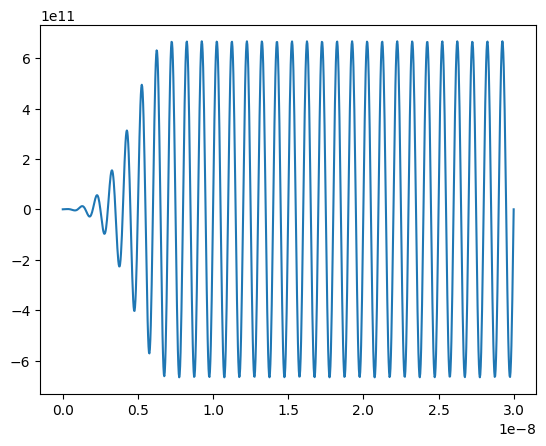

In [ ]:
tt=torch.linspace(0,3E-8,1000)
plt.plot(tt,sa*np.array([wf(t) for t in tt]))
plt.show()

In [ ]:
sa*wf(torch.tensor(3E-8*0.9))

tensor(-0.0091)

In [ ]:
np.logspace(-6,-2,10)

array([1.00000000e-06, 2.78255940e-06, 7.74263683e-06, 2.15443469e-05,
       5.99484250e-05, 1.66810054e-04, 4.64158883e-04, 1.29154967e-03,
       3.59381366e-03, 1.00000000e-02])

In [ ]:
#@title TheoryCurrentSweep
#os.mkdir('TheoryCurrentSweep')
def sPO1(fd,fielddir,fieldBias,excitationType,numElectrodes,config,sotFreq,current,constantP,wireWidth):
    nx,ny,nz=1600,1,1
    dy,dz=5E-8,50E-9
    curWvlen=wvlensFun1(fielddir*fieldBias,sotFreq)
    dx=min(1E-7,curWvlen/14)
    tstep=1E-4*dx
    pbcx,pbcy,pbcz=1,60,0
    dampLength=200
    imagex=list(range(400,1200))
    scalars_every,num_fields=5,2
    tendFactor,tonFactor=30,7
    record_scalar_fields,record_vector_fields=[],['external','torque']
    return nx,ny,nz,dx,dy,dz,pbcx,pbcy,pbcz,dampLength,imagex,scalars_every,num_fields,tstep,tendFactor,tonFactor,record_scalar_fields,record_vector_fields
run_sequence(fd=['x','y'],field_dirs=[np.array((1,0,0)),np.array((0,1,0))],fieldBiasLis=[143E3,],excitationTypeLis=['uStrip','SOT'],numElectrodesLis=[1,],configLis=['p'],sotFreqLis=[6E9,],currentLis=np.logspace(-6,-2,10),nameFormat=['TheoryCurrentSweep_1ap_','fieldDir','fieldBias','kAm_','sotFreq','GHz_','current','mA_','excitationType'],simParamOverride=sPO1,saveTo='TheoryCurrentSweep/')
run_sequence(fd=['z'],field_dirs=[np.array((0,0,1)),],fieldBiasLis=[143E3,],excitationTypeLis=['uStrip','SOT'],numElectrodesLis=[1,],configLis=['p'],sotFreqLis=[6E9,],currentLis=np.logspace(-6,-2,10),nameFormat=['TheoryCurrentSweep_1ap_','fieldDir','fieldBias','kAm_','sotFreq','GHz_','current','mA_','excitationType'],simParamOverride=sPO1,saveTo='TheoryCurrentSweep/')
#run_sequence(fd=['x','y'],field_dirs=[np.array((1,0,0)),np.array((0,1,0))],fieldBiasLis=[4E3,],excitationTypeLis=['uStrip'],numElectrodesLis=[1,],configLis=['p'],sotFreqLis=[6E9,],currentLis=np.logspace(-6,-2,10),nameFormat=['TheoryCurrentSweep_1ap_','fieldDir','fieldBias','kAm_','sotFreq','GHz_','current','mA_','excitationType'],simParamOverride=sPO1,saveTo='TheoryCurrentSweep/')
#run_sequence(fd=['z'],field_dirs=[np.array((0,0,1)),],fieldBiasLis=[143E3,],excitationTypeLis=['uStrip'],numElectrodesLis=[1,],configLis=['p'],sotFreqLis=[6E9,],currentLis=np.logspace(-6,-2,10),nameFormat=['TheoryCurrentSweep_1ap_','fieldDir','fieldBias','kAm_','sotFreq','GHz_','current','mA_','excitationType'],simParamOverride=sPO1,saveTo='TheoryCurrentSweep/')

TheoryCurrentSweep/TheoryCurrentSweep_1ap_Fxbias143p0kAm_6p0GHz_0p0mA_uStrip_data/
10% time ellapsed
20% time ellapsed
30% time ellapsed
40% time ellapsed
50% time ellapsed
60% time ellapsed
70% time ellapsed
80% time ellapsed
90% time ellapsed


2024-05-10 02:23:24  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                    0
    ExternalField.h                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                     1      2916.76           2.91676
    DemagField.h                                                                        0
        MinimizerBB.minimize                                                            2     18437.3           36.8747
            ExternalField.h                                                             4         0.202493       0.000809972
            ExchangeField.h                                        

2024-05-10 02:30:52  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                    0
    ExternalField.h                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                     1      2916.76           2.91676
    DemagField.h                                                                        0
        MinimizerBB.minimize                                                            2     18437.3           36.8747
            ExternalField.h                                                             4         0.202493       0.000809972
            ExchangeField.h                                        

2024-05-10 02:38:19  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                    0
    ExternalField.h                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                     1      2916.76           2.91676
    DemagField.h                                                                        0
        MinimizerBB.minimize                                                            2     18437.3           36.8747
            ExternalField.h                                                             4         0.202493       0.000809972
            ExchangeField.h                                        

2024-05-10 02:45:53  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                    0
    ExternalField.h                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                     1      2916.76           2.91676
    DemagField.h                                                                        0
        MinimizerBB.minimize                                                            2     18437.3           36.8747
            ExternalField.h                                                             4         0.202493       0.000809972
            ExchangeField.h                                        

2024-05-10 02:53:20  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                    0
    ExternalField.h                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                     1      2916.76           2.91676
    DemagField.h                                                                        0
        MinimizerBB.minimize                                                            2     18437.3           36.8747
            ExternalField.h                                                             4         0.202493       0.000809972
            ExchangeField.h                                        

2024-05-10 03:00:48  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                    0
    ExternalField.h                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                     1      2916.76           2.91676
    DemagField.h                                                                        0
        MinimizerBB.minimize                                                            2     18437.3           36.8747
            ExternalField.h                                                             4         0.202493       0.000809972
            ExchangeField.h                                        

2024-05-10 03:08:18  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                    0
    ExternalField.h                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                     1      2916.76           2.91676
    DemagField.h                                                                        0
        MinimizerBB.minimize                                                            2     18437.3           36.8747
            ExternalField.h                                                             4         0.202493       0.000809972
            ExchangeField.h                                        

2024-05-10 03:15:52  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                    0
    ExternalField.h                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                     1      2916.76           2.91676
    DemagField.h                                                                        0
        MinimizerBB.minimize                                                            2     18437.3           36.8747
            ExternalField.h                                                             4         0.202493       0.000809972
            ExchangeField.h                                        

2024-05-10 03:23:30  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                    0
    ExternalField.h                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                     1      2916.76           2.91676
    DemagField.h                                                                        0
        MinimizerBB.minimize                                                            2     18437.3           36.8747
            ExternalField.h                                                             4         0.202493       0.000809972
            ExchangeField.h                                        

2024-05-10 03:30:59  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                    0
    ExternalField.h                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                     1      2916.76           2.91676
    DemagField.h                                                                        0
        MinimizerBB.minimize                                                            2     18437.3           36.8747
            ExternalField.h                                                             4         0.202493       0.000809972
            ExchangeField.h                                        

2024-05-10 03:37:53  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                    0
    ExternalField.h                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                     1      2916.76           2.91676
    DemagField.h                                                                        0
        MinimizerBB.minimize                                                            2     18437.3           36.8747
            ExternalField.h                                                             4         0.202493       0.000809972
            ExchangeField.h                                        

2024-05-10 03:44:51  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                    0
    ExternalField.h                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                     1      2916.76           2.91676
    DemagField.h                                                                        0
        MinimizerBB.minimize                                                            2     18437.3           36.8747
            ExternalField.h                                                             4         0.202493       0.000809972
            ExchangeField.h                                        

2024-05-10 03:51:47  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                    0
    ExternalField.h                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                     1      2916.76           2.91676
    DemagField.h                                                                        0
        MinimizerBB.minimize                                                            2     18437.3           36.8747
            ExternalField.h                                                             4         0.202493       0.000809972
            ExchangeField.h                                        

2024-05-10 03:58:44  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                    0
    ExternalField.h                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                     1      2916.76           2.91676
    DemagField.h                                                                        0
        MinimizerBB.minimize                                                            2     18437.3           36.8747
            ExternalField.h                                                             4         0.202493       0.000809972
            ExchangeField.h                                        

2024-05-10 04:05:38  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                    0
    ExternalField.h                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                     1      2916.76           2.91676
    DemagField.h                                                                        0
        MinimizerBB.minimize                                                            2     18437.3           36.8747
            ExternalField.h                                                             4         0.202493       0.000809972
            ExchangeField.h                                        

2024-05-10 04:12:34  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                    0
    ExternalField.h                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                     1      2916.76           2.91676
    DemagField.h                                                                        0
        MinimizerBB.minimize                                                            2     18437.3           36.8747
            ExternalField.h                                                             4         0.202493       0.000809972
            ExchangeField.h                                        

2024-05-10 04:19:30  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                    0
    ExternalField.h                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                     1      2916.76           2.91676
    DemagField.h                                                                        0
        MinimizerBB.minimize                                                            2     18437.3           36.8747
            ExternalField.h                                                             4         0.202493       0.000809972
            ExchangeField.h                                        

2024-05-10 04:26:23  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                    0
    ExternalField.h                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                     1      2916.76           2.91676
    DemagField.h                                                                        0
        MinimizerBB.minimize                                                            2     18437.3           36.8747
            ExternalField.h                                                             4         0.202493       0.000809972
            ExchangeField.h                                        

2024-05-10 04:33:24  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                    0
    ExternalField.h                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                     1      2916.76           2.91676
    DemagField.h                                                                        0
        MinimizerBB.minimize                                                            2     18437.3           36.8747
            ExternalField.h                                                             4         0.202493       0.000809972
            ExchangeField.h                                        

2024-05-10 04:40:30  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                    0
    ExternalField.h                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                     1      2916.76           2.91676
    DemagField.h                                                                        0
        MinimizerBB.minimize                                                            2     18437.3           36.8747
            ExternalField.h                                                             4         0.202493       0.000809972
            ExchangeField.h                                        

2024-05-10 04:48:05  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                    0
    ExternalField.h                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                     1      2916.76           2.91676
    DemagField.h                                                                        0
        MinimizerBB.minimize                                                            2     18437.3           36.8747
            ExternalField.h                                                             4         0.202493       0.000809972
            ExchangeField.h                                        

2024-05-10 04:55:39  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                    0
    ExternalField.h                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                     1      2916.76           2.91676
    DemagField.h                                                                        0
        MinimizerBB.minimize                                                            2     18437.3           36.8747
            ExternalField.h                                                             4         0.202493       0.000809972
            ExchangeField.h                                        

2024-05-10 05:03:18  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                    0
    ExternalField.h                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                     1      2916.76           2.91676
    DemagField.h                                                                        0
        MinimizerBB.minimize                                                            2     18437.3           36.8747
            ExternalField.h                                                             4         0.202493       0.000809972
            ExchangeField.h                                        

2024-05-10 05:10:58  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                    0
    ExternalField.h                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                     1      2916.76           2.91676
    DemagField.h                                                                        0
        MinimizerBB.minimize                                                            2     18437.3           36.8747
            ExternalField.h                                                             4         0.202493       0.000809972
            ExchangeField.h                                        

2024-05-10 05:18:34  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                    0
    ExternalField.h                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                     1      2916.76           2.91676
    DemagField.h                                                                        0
        MinimizerBB.minimize                                                            2     18437.3           36.8747
            ExternalField.h                                                             4         0.202493       0.000809972
            ExchangeField.h                                        

2024-05-10 05:26:14  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                    0
    ExternalField.h                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                     1      2916.76           2.91676
    DemagField.h                                                                        0
        MinimizerBB.minimize                                                            2     18437.3           36.8747
            ExternalField.h                                                             4         0.202493       0.000809972
            ExchangeField.h                                        

2024-05-10 05:34:01  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                    0
    ExternalField.h                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                     1      2916.76           2.91676
    DemagField.h                                                                        0
        MinimizerBB.minimize                                                            2     18437.3           36.8747
            ExternalField.h                                                             4         0.202493       0.000809972
            ExchangeField.h                                        

2024-05-10 05:41:40  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                    0
    ExternalField.h                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                     1      2916.76           2.91676
    DemagField.h                                                                        0
        MinimizerBB.minimize                                                            2     18437.3           36.8747
            ExternalField.h                                                             4         0.202493       0.000809972
            ExchangeField.h                                        

2024-05-10 05:49:15  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                    0
    ExternalField.h                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                     1      2916.76           2.91676
    DemagField.h                                                                        0
        MinimizerBB.minimize                                                            2     18437.3           36.8747
            ExternalField.h                                                             4         0.202493       0.000809972
            ExchangeField.h                                        

2024-05-10 05:56:53  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                    0
    ExternalField.h                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                     1      2916.76           2.91676
    DemagField.h                                                                        0
        MinimizerBB.minimize                                                            2     18437.3           36.8747
            ExternalField.h                                                             4         0.202493       0.000809972
            ExchangeField.h                                        

2024-05-10 06:03:59  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                    0
    ExternalField.h                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                     1      2916.76           2.91676
    DemagField.h                                                                        0
        MinimizerBB.minimize                                                            2     18437.3           36.8747
            ExternalField.h                                                             4         0.202493       0.000809972
            ExchangeField.h                                        

2024-05-10 06:11:05  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                    0
    ExternalField.h                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                     1      2916.76           2.91676
    DemagField.h                                                                        0
        MinimizerBB.minimize                                                            2     18437.3           36.8747
            ExternalField.h                                                             4         0.202493       0.000809972
            ExchangeField.h                                        

2024-05-10 06:18:11  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                    0
    ExternalField.h                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                     1      2916.76           2.91676
    DemagField.h                                                                        0
        MinimizerBB.minimize                                                            2     18437.3           36.8747
            ExternalField.h                                                             4         0.202493       0.000809972
            ExchangeField.h                                        

2024-05-10 06:25:17  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                    0
    ExternalField.h                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                     1      2916.76           2.91676
    DemagField.h                                                                        0
        MinimizerBB.minimize                                                            2     18437.3           36.8747
            ExternalField.h                                                             4         0.202493       0.000809972
            ExchangeField.h                                        

2024-05-10 06:32:21  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                    0
    ExternalField.h                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                     1      2916.76           2.91676
    DemagField.h                                                                        0
        MinimizerBB.minimize                                                            2     18437.3           36.8747
            ExternalField.h                                                             4         0.202493       0.000809972
            ExchangeField.h                                        

2024-05-10 06:39:33  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                    0
    ExternalField.h                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                     1      2916.76           2.91676
    DemagField.h                                                                        0
        MinimizerBB.minimize                                                            2     18437.3           36.8747
            ExternalField.h                                                             4         0.202493       0.000809972
            ExchangeField.h                                        

2024-05-10 06:46:41  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                    0
    ExternalField.h                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                     1      2916.76           2.91676
    DemagField.h                                                                        0
        MinimizerBB.minimize                                                            2     18437.3           36.8747
            ExternalField.h                                                             4         0.202493       0.000809972
            ExchangeField.h                                        

2024-05-10 06:53:49  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                    0
    ExternalField.h                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                     1      2916.76           2.91676
    DemagField.h                                                                        0
        MinimizerBB.minimize                                                            2     18437.3           36.8747
            ExternalField.h                                                             4         0.202493       0.000809972
            ExchangeField.h                                        

2024-05-10 07:00:55  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                    0
    ExternalField.h                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                     1      2916.76           2.91676
    DemagField.h                                                                        0
        MinimizerBB.minimize                                                            2     18437.3           36.8747
            ExternalField.h                                                             4         0.202493       0.000809972
            ExchangeField.h                                        

2024-05-10 07:07:59  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                    0
    ExternalField.h                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                     1      2916.76           2.91676
    DemagField.h                                                                        0
        MinimizerBB.minimize                                                            2     18437.3           36.8747
            ExternalField.h                                                             4         0.202493       0.000809972
            ExchangeField.h                                        

2024-05-10 07:14:57  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                    0
    ExternalField.h                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                     1      2916.76           2.91676
    DemagField.h                                                                        0
        MinimizerBB.minimize                                                            2     18437.3           36.8747
            ExternalField.h                                                             4         0.202493       0.000809972
            ExchangeField.h                                        

2024-05-10 07:21:59  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                    0
    ExternalField.h                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                     1      2916.76           2.91676
    DemagField.h                                                                        0
        MinimizerBB.minimize                                                            2     18437.3           36.8747
            ExternalField.h                                                             4         0.202493       0.000809972
            ExchangeField.h                                        

2024-05-10 07:29:05  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                    0
    ExternalField.h                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                     1      2916.76           2.91676
    DemagField.h                                                                        0
        MinimizerBB.minimize                                                            2     18437.3           36.8747
            ExternalField.h                                                             4         0.202493       0.000809972
            ExchangeField.h                                        

2024-05-10 07:36:06  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                    0
    ExternalField.h                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                     1      2916.76           2.91676
    DemagField.h                                                                        0
        MinimizerBB.minimize                                                            2     18437.3           36.8747
            ExternalField.h                                                             4         0.202493       0.000809972
            ExchangeField.h                                        

2024-05-10 07:43:09  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                    0
    ExternalField.h                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                     1      2916.76           2.91676
    DemagField.h                                                                        0
        MinimizerBB.minimize                                                            2     18437.3           36.8747
            ExternalField.h                                                             4         0.202493       0.000809972
            ExchangeField.h                                        

2024-05-10 07:50:07  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                    0
    ExternalField.h                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                     1      2916.76           2.91676
    DemagField.h                                                                        0
        MinimizerBB.minimize                                                            2     18437.3           36.8747
            ExternalField.h                                                             4         0.202493       0.000809972
            ExchangeField.h                                        

2024-05-10 07:57:09  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                    0
    ExternalField.h                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                     1      2916.76           2.91676
    DemagField.h                                                                        0
        MinimizerBB.minimize                                                            2     18437.3           36.8747
            ExternalField.h                                                             4         0.202493       0.000809972
            ExchangeField.h                                        

2024-05-10 08:04:08  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                    0
    ExternalField.h                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                     1      2916.76           2.91676
    DemagField.h                                                                        0
        MinimizerBB.minimize                                                            2     18437.3           36.8747
            ExternalField.h                                                             4         0.202493       0.000809972
            ExchangeField.h                                        

2024-05-10 08:11:08  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                    0
    ExternalField.h                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                     1      2916.76           2.91676
    DemagField.h                                                                        0
        MinimizerBB.minimize                                                            2     18437.3           36.8747
            ExternalField.h                                                             4         0.202493       0.000809972
            ExchangeField.h                                        

2024-05-10 08:18:05  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                    0
    ExternalField.h                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                     1      2916.76           2.91676
    DemagField.h                                                                        0
        MinimizerBB.minimize                                                            2     18437.3           36.8747
            ExternalField.h                                                             4         0.202493       0.000809972
            ExchangeField.h                                        

2024-05-10 08:24:34  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                    0
    ExternalField.h                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                     1      2916.76           2.91676
    DemagField.h                                                                        0
        MinimizerBB.minimize                                                            2     18437.3           36.8747
            ExternalField.h                                                             4         0.202493       0.000809972
            ExchangeField.h                                        

2024-05-10 08:30:58  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                    0
    ExternalField.h                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                     1      2916.76           2.91676
    DemagField.h                                                                        0
        MinimizerBB.minimize                                                            2     18437.3           36.8747
            ExternalField.h                                                             4         0.202493       0.000809972
            ExchangeField.h                                        

2024-05-10 08:37:19  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                    0
    ExternalField.h                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                     1      2916.76           2.91676
    DemagField.h                                                                        0
        MinimizerBB.minimize                                                            2     18437.3           36.8747
            ExternalField.h                                                             4         0.202493       0.000809972
            ExchangeField.h                                        

2024-05-10 08:43:42  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                    0
    ExternalField.h                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                     1      2916.76           2.91676
    DemagField.h                                                                        0
        MinimizerBB.minimize                                                            2     18437.3           36.8747
            ExternalField.h                                                             4         0.202493       0.000809972
            ExchangeField.h                                        

2024-05-10 08:50:04  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                    0
    ExternalField.h                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                     1      2916.76           2.91676
    DemagField.h                                                                        0
        MinimizerBB.minimize                                                            2     18437.3           36.8747
            ExternalField.h                                                             4         0.202493       0.000809972
            ExchangeField.h                                        

2024-05-10 08:56:29  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                    0
    ExternalField.h                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                     1      2916.76           2.91676
    DemagField.h                                                                        0
        MinimizerBB.minimize                                                            2     18437.3           36.8747
            ExternalField.h                                                             4         0.202493       0.000809972
            ExchangeField.h                                        

2024-05-10 09:02:55  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                    0
    ExternalField.h                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                     1      2916.76           2.91676
    DemagField.h                                                                        0
        MinimizerBB.minimize                                                            2     18437.3           36.8747
            ExternalField.h                                                             4         0.202493       0.000809972
            ExchangeField.h                                        

2024-05-10 09:09:20  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                    0
    ExternalField.h                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                     1      2916.76           2.91676
    DemagField.h                                                                        0
        MinimizerBB.minimize                                                            2     18437.3           36.8747
            ExternalField.h                                                             4         0.202493       0.000809972
            ExchangeField.h                                        

2024-05-10 09:15:41  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                    0
    ExternalField.h                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                     1      2916.76           2.91676
    DemagField.h                                                                        0
        MinimizerBB.minimize                                                            2     18437.3           36.8747
            ExternalField.h                                                             4         0.202493       0.000809972
            ExchangeField.h                                        

2024-05-10 09:22:04  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                    0
    ExternalField.h                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                     1      2916.76           2.91676
    DemagField.h                                                                        0
        MinimizerBB.minimize                                                            2     18437.3           36.8747
            ExternalField.h                                                             4         0.202493       0.000809972
            ExchangeField.h                                        

In [ ]:
#@title TheoryElectrodeNumberSweep
#os.mkdir('TheoryElectrodeNumberSweep')
def sPO1(fd,fielddir,fieldBias,excitationType,numElectrodes,config,sotFreq,current,constantP,wireWidth):
    nx,ny,nz=1600,1,1
    dy,dz=5E-8,100E-9
    curWvlen=wvlensFun1(fielddir*fieldBias,sotFreq)
    dx=min(1E-7,curWvlen/14)
    tstep=1E-4*dx
    pbcx,pbcy,pbcz=1,60,0
    dampLength=200
    imagex=list(range(400,1200))
    scalars_every,num_fields=5,2
    tendFactor,tonFactor=30,7
    record_scalar_fields,record_vector_fields=[],['external','torque']
    return nx,ny,nz,dx,dy,dz,pbcx,pbcy,pbcz,dampLength,imagex,scalars_every,num_fields,tstep,tendFactor,tonFactor,record_scalar_fields,record_vector_fields
run_sequence(fd=['x','y'],field_dirs=[np.array((1,0,0)),np.array((0,1,0))],fieldBiasLis=[4E3,],excitationTypeLis=['uStrip','SOT'],numElectrodesLis=[2,4,8],configLis=['p','ap'],sotFreqLis=[6E9,],currentLis=[2E-3,],nameFormat=['TheoryElectrodeNumberSweep_','numElectrodes','config','_','fieldDir','fieldBias','kAm_','sotFreq','GHz_','excitationType'],simParamOverride=sPO1,saveTo='TheoryElectrodeNumberSweep/')
run_sequence(fd=['z'],field_dirs=[np.array((0,0,1)),],fieldBiasLis=[143E3,],excitationTypeLis=['uStrip','SOT'],numElectrodesLis=[2,4,8],configLis=['p','ap'],sotFreqLis=[6E9,],currentLis=[2E-3,],nameFormat=['TheoryElectrodeNumberSweep_','numElectrodes','config','_','fieldDir','fieldBias','kAm_','sotFreq','GHz_','excitationType'],simParamOverride=sPO1,saveTo='TheoryElectrodeNumberSweep/')

TheoryElectrodeNumberSweep/TheoryElectrodeNumberSweep_2p_Fxbias4p0kAm_6p0GHz_uStrip_data/
10% time ellapsed
20% time ellapsed
30% time ellapsed
40% time ellapsed
50% time ellapsed
60% time ellapsed
70% time ellapsed
80% time ellapsed
90% time ellapsed

TIMER REPORT
Operation                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                   10     22144.9           221.449
    ExternalField.h                                                                    61         1.08143         0.0659672
    ExchangeField.h                                                                    61        45.6034          2.78181
    CubicAnisotropyField.h                                                             61         1.83288         0.11

2024-05-05 12:32:54  magnum.np:WARNING Too much time missing (21%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                   10     22144.9           221.449
    ExternalField.h                                                                    61         1.08143         0.0659672
    ExchangeField.h                                                                    61        45.6034          2.78181
    CubicAnisotropyField.h                                                             61         1.83288         0.111806
    DemagField.h                                                                       60      3640             218.4
        MinimizerBB.minimize                                                            1     21313.3            21.3133
        

2024-05-05 12:46:25  magnum.np:WARNING Too much time missing (21%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                   10     22144.9           221.449
    ExternalField.h                                                                    61         1.08143         0.0659672
    ExchangeField.h                                                                    61        45.6034          2.78181
    CubicAnisotropyField.h                                                             61         1.83288         0.111806
    DemagField.h                                                                       60      3640             218.4
        MinimizerBB.minimize                                                            1     21313.3            21.3133
        

2024-05-05 13:08:11  magnum.np:WARNING Too much time missing (51%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                   10     22144.9           221.449
    ExternalField.h                                                                    61         1.08143         0.0659672
    ExchangeField.h                                                                    61        45.6034          2.78181
    CubicAnisotropyField.h                                                             61         1.83288         0.111806
    DemagField.h                                                                       60      3640             218.4
        MinimizerBB.minimize                                                            1     21313.3            21.3133
        

2024-05-05 13:29:46  magnum.np:WARNING Too much time missing (51%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                   10     22144.9           221.449
    ExternalField.h                                                                    61         1.08143         0.0659672
    ExchangeField.h                                                                    61        45.6034          2.78181
    CubicAnisotropyField.h                                                             61         1.83288         0.111806
    DemagField.h                                                                       60      3640             218.4
        MinimizerBB.minimize                                                            1     21313.3            21.3133
        

2024-05-05 15:07:52  magnum.np:WARNING Too much time missing (40%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                   10     22144.9           221.449
    ExternalField.h                                                                    61         1.08143         0.0659672
    ExchangeField.h                                                                    61        45.6034          2.78181
    CubicAnisotropyField.h                                                             61         1.83288         0.111806
    DemagField.h                                                                       60      3640             218.4
        MinimizerBB.minimize                                                            1     21313.3            21.3133
        

2024-05-05 15:25:30  magnum.np:WARNING Too much time missing (40%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                   10     22144.9           221.449
    ExternalField.h                                                                    61         1.08143         0.0659672
    ExchangeField.h                                                                    61        45.6034          2.78181
    CubicAnisotropyField.h                                                             61         1.83288         0.111806
    DemagField.h                                                                       60      3640             218.4
        MinimizerBB.minimize                                                            1     21313.3            21.3133
        

2024-05-05 17:04:53  magnum.np:WARNING Too much time missing (47%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                   10     22144.9           221.449
    ExternalField.h                                                                    61         1.08143         0.0659672
    ExchangeField.h                                                                    61        45.6034          2.78181
    CubicAnisotropyField.h                                                             61         1.83288         0.111806
    DemagField.h                                                                       60      3640             218.4
        MinimizerBB.minimize                                                            1     21313.3            21.3133
        

2024-05-05 17:25:01  magnum.np:WARNING Too much time missing (47%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                   10     22144.9           221.449
    ExternalField.h                                                                    61         1.08143         0.0659672
    ExchangeField.h                                                                    61        45.6034          2.78181
    CubicAnisotropyField.h                                                             61         1.83288         0.111806
    DemagField.h                                                                       60      3640             218.4
        MinimizerBB.minimize                                                            1     21313.3            21.3133
        

In [ ]:
#@title TheoryBiasSweep
#os.mkdir('TheoryBiasSweep')
def sPO1(fd,fielddir,fieldBias,excitationType,numElectrodes,config,sotFreq,current,constantP,wireWidth):
    nx,ny,nz=1600,1,1
    dy,dz=5E-8,50E-9
    curWvlen=wvlensFun1(fielddir*fieldBias,sotFreq)
    dx=min(1E-7,curWvlen/14)
    tstep=1E-4*dx
    pbcx,pbcy,pbcz=1,60,0
    dampLength=200
    imagex=list(range(400,1200))
    scalars_every,num_fields=5,2
    tendFactor,tonFactor=30,7
    record_scalar_fields,record_vector_fields=[],['external','torque']
    return nx,ny,nz,dx,dy,dz,pbcx,pbcy,pbcz,dampLength,imagex,scalars_every,num_fields,tstep,tendFactor,tonFactor,record_scalar_fields,record_vector_fields
run_sequence(fd=['x','y'],field_dirs=[np.array((1,0,0)),np.array((0,1,0))],fieldBiasLis=np.logspace(np.log10(4E3),np.log10(180E3),10),excitationTypeLis=['uStrip','SOT'],numElectrodesLis=[1,],configLis=['p',],sotFreqLis=[6E9,10E9],currentLis=[2E-3,],nameFormat=['TheoryBiasSweep_1ap_','fieldDir','fieldBias','kAm_','sotFreq','GHz_','excitationType'],simParamOverride=sPO1,saveTo='TheoryBiasSweep/')
run_sequence(fd=['z'],field_dirs=[np.array((0,0,1)),],fieldBiasLis=np.logspace(np.log10(4E3),np.log10(180E3),10),excitationTypeLis=['uStrip','SOT'],numElectrodesLis=[1,],configLis=['p',],sotFreqLis=[6E9,10E9],currentLis=[2E-3,],nameFormat=['TheoryBiasSweep_1ap_','fieldDir','fieldBias','kAm_','sotFreq','GHz_','excitationType'],simParamOverride=sPO1,saveTo='TheoryBiasSweep/')

TheoryBiasSweep/TheoryBiasSweep_1ap_Fxbias4p0kAm_6p0GHz_uStrip_data/
10% time ellapsed
20% time ellapsed
30% time ellapsed
40% time ellapsed
50% time ellapsed
60% time ellapsed
70% time ellapsed
80% time ellapsed
90% time ellapsed


2024-05-10 16:56:45  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                    0
    ExternalField.h                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                     1      2916.76           2.91676
    DemagField.h                                                                        0
        MinimizerBB.minimize                                                            2     18437.3           36.8747
            ExternalField.h                                                             4         0.202493       0.000809972
            ExchangeField.h                                        

2024-05-10 17:03:01  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                    0
    ExternalField.h                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                     1      2916.76           2.91676
    DemagField.h                                                                        0
        MinimizerBB.minimize                                                            2     18437.3           36.8747
            ExternalField.h                                                             4         0.202493       0.000809972
            ExchangeField.h                                        

2024-05-10 17:10:07  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                    0
    ExternalField.h                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                     1      2916.76           2.91676
    DemagField.h                                                                        0
        MinimizerBB.minimize                                                            2     18437.3           36.8747
            ExternalField.h                                                             4         0.202493       0.000809972
            ExchangeField.h                                        

2024-05-10 17:15:52  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                    0
    ExternalField.h                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                     1      2916.76           2.91676
    DemagField.h                                                                        0
        MinimizerBB.minimize                                                            2     18437.3           36.8747
            ExternalField.h                                                             4         0.202493       0.000809972
            ExchangeField.h                                        

2024-05-10 17:23:33  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                    0
    ExternalField.h                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                     1      2916.76           2.91676
    DemagField.h                                                                        0
        MinimizerBB.minimize                                                            2     18437.3           36.8747
            ExternalField.h                                                             4         0.202493       0.000809972
            ExchangeField.h                                        

2024-05-10 17:29:44  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                    0
    ExternalField.h                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                     1      2916.76           2.91676
    DemagField.h                                                                        0
        MinimizerBB.minimize                                                            2     18437.3           36.8747
            ExternalField.h                                                             4         0.202493       0.000809972
            ExchangeField.h                                        

2024-05-10 17:36:48  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                    0
    ExternalField.h                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                     1      2916.76           2.91676
    DemagField.h                                                                        0
        MinimizerBB.minimize                                                            2     18437.3           36.8747
            ExternalField.h                                                             4         0.202493       0.000809972
            ExchangeField.h                                        

2024-05-10 17:42:31  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                    0
    ExternalField.h                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                     1      2916.76           2.91676
    DemagField.h                                                                        0
        MinimizerBB.minimize                                                            2     18437.3           36.8747
            ExternalField.h                                                             4         0.202493       0.000809972
            ExchangeField.h                                        

2024-05-10 17:50:11  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                    0
    ExternalField.h                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                     1      2916.76           2.91676
    DemagField.h                                                                        0
        MinimizerBB.minimize                                                            2     18437.3           36.8747
            ExternalField.h                                                             4         0.202493       0.000809972
            ExchangeField.h                                        

2024-05-10 17:56:24  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                    0
    ExternalField.h                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                     1      2916.76           2.91676
    DemagField.h                                                                        0
        MinimizerBB.minimize                                                            2     18437.3           36.8747
            ExternalField.h                                                             4         0.202493       0.000809972
            ExchangeField.h                                        

2024-05-10 18:03:24  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                    0
    ExternalField.h                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                     1      2916.76           2.91676
    DemagField.h                                                                        0
        MinimizerBB.minimize                                                            2     18437.3           36.8747
            ExternalField.h                                                             4         0.202493       0.000809972
            ExchangeField.h                                        

2024-05-10 18:09:02  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                    0
    ExternalField.h                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                     1      2916.76           2.91676
    DemagField.h                                                                        0
        MinimizerBB.minimize                                                            2     18437.3           36.8747
            ExternalField.h                                                             4         0.202493       0.000809972
            ExchangeField.h                                        

2024-05-10 18:16:39  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                    0
    ExternalField.h                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                     1      2916.76           2.91676
    DemagField.h                                                                        0
        MinimizerBB.minimize                                                            2     18437.3           36.8747
            ExternalField.h                                                             4         0.202493       0.000809972
            ExchangeField.h                                        

2024-05-10 18:22:54  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                    0
    ExternalField.h                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                     1      2916.76           2.91676
    DemagField.h                                                                        0
        MinimizerBB.minimize                                                            2     18437.3           36.8747
            ExternalField.h                                                             4         0.202493       0.000809972
            ExchangeField.h                                        

2024-05-10 18:30:01  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                    0
    ExternalField.h                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                     1      2916.76           2.91676
    DemagField.h                                                                        0
        MinimizerBB.minimize                                                            2     18437.3           36.8747
            ExternalField.h                                                             4         0.202493       0.000809972
            ExchangeField.h                                        

2024-05-10 18:35:50  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                    0
    ExternalField.h                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                     1      2916.76           2.91676
    DemagField.h                                                                        0
        MinimizerBB.minimize                                                            2     18437.3           36.8747
            ExternalField.h                                                             4         0.202493       0.000809972
            ExchangeField.h                                        

2024-05-10 18:43:36  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                    0
    ExternalField.h                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                     1      2916.76           2.91676
    DemagField.h                                                                        0
        MinimizerBB.minimize                                                            2     18437.3           36.8747
            ExternalField.h                                                             4         0.202493       0.000809972
            ExchangeField.h                                        

2024-05-10 18:49:49  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                    0
    ExternalField.h                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                     1      2916.76           2.91676
    DemagField.h                                                                        0
        MinimizerBB.minimize                                                            2     18437.3           36.8747
            ExternalField.h                                                             4         0.202493       0.000809972
            ExchangeField.h                                        

2024-05-10 18:56:54  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                    0
    ExternalField.h                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                     1      2916.76           2.91676
    DemagField.h                                                                        0
        MinimizerBB.minimize                                                            2     18437.3           36.8747
            ExternalField.h                                                             4         0.202493       0.000809972
            ExchangeField.h                                        

2024-05-10 19:02:34  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                    0
    ExternalField.h                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                     1      2916.76           2.91676
    DemagField.h                                                                        0
        MinimizerBB.minimize                                                            2     18437.3           36.8747
            ExternalField.h                                                             4         0.202493       0.000809972
            ExchangeField.h                                        

2024-05-10 19:10:10  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                    0
    ExternalField.h                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                     1      2916.76           2.91676
    DemagField.h                                                                        0
        MinimizerBB.minimize                                                            2     18437.3           36.8747
            ExternalField.h                                                             4         0.202493       0.000809972
            ExchangeField.h                                        

2024-05-10 19:16:18  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                    0
    ExternalField.h                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                     1      2916.76           2.91676
    DemagField.h                                                                        0
        MinimizerBB.minimize                                                            2     18437.3           36.8747
            ExternalField.h                                                             4         0.202493       0.000809972
            ExchangeField.h                                        

2024-05-10 19:23:20  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                    0
    ExternalField.h                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                     1      2916.76           2.91676
    DemagField.h                                                                        0
        MinimizerBB.minimize                                                            2     18437.3           36.8747
            ExternalField.h                                                             4         0.202493       0.000809972
            ExchangeField.h                                        

2024-05-10 19:28:58  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                    0
    ExternalField.h                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                     1      2916.76           2.91676
    DemagField.h                                                                        0
        MinimizerBB.minimize                                                            2     18437.3           36.8747
            ExternalField.h                                                             4         0.202493       0.000809972
            ExchangeField.h                                        

2024-05-10 19:36:41  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                    0
    ExternalField.h                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                     1      2916.76           2.91676
    DemagField.h                                                                        0
        MinimizerBB.minimize                                                            2     18437.3           36.8747
            ExternalField.h                                                             4         0.202493       0.000809972
            ExchangeField.h                                        

2024-05-10 19:40:46  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                    0
    ExternalField.h                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                     1      2916.76           2.91676
    DemagField.h                                                                        0
        MinimizerBB.minimize                                                            2     18437.3           36.8747
            ExternalField.h                                                             4         0.202493       0.000809972
            ExchangeField.h                                        

2024-05-10 19:47:56  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                    0
    ExternalField.h                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                     1      2916.76           2.91676
    DemagField.h                                                                        0
        MinimizerBB.minimize                                                            2     18437.3           36.8747
            ExternalField.h                                                             4         0.202493       0.000809972
            ExchangeField.h                                        

2024-05-10 19:51:46  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                    0
    ExternalField.h                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                     1      2916.76           2.91676
    DemagField.h                                                                        0
        MinimizerBB.minimize                                                            2     18437.3           36.8747
            ExternalField.h                                                             4         0.202493       0.000809972
            ExchangeField.h                                        

2024-05-10 19:59:36  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                    0
    ExternalField.h                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                     1      2916.76           2.91676
    DemagField.h                                                                        0
        MinimizerBB.minimize                                                            2     18437.3           36.8747
            ExternalField.h                                                             4         0.202493       0.000809972
            ExchangeField.h                                        

2024-05-10 20:03:43  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                    0
    ExternalField.h                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                     1      2916.76           2.91676
    DemagField.h                                                                        0
        MinimizerBB.minimize                                                            2     18437.3           36.8747
            ExternalField.h                                                             4         0.202493       0.000809972
            ExchangeField.h                                        

2024-05-10 20:11:02  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                    0
    ExternalField.h                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                     1      2916.76           2.91676
    DemagField.h                                                                        0
        MinimizerBB.minimize                                                            2     18437.3           36.8747
            ExternalField.h                                                             4         0.202493       0.000809972
            ExchangeField.h                                        

2024-05-10 20:14:54  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                    0
    ExternalField.h                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                     1      2916.76           2.91676
    DemagField.h                                                                        0
        MinimizerBB.minimize                                                            2     18437.3           36.8747
            ExternalField.h                                                             4         0.202493       0.000809972
            ExchangeField.h                                        

2024-05-10 20:22:52  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                    0
    ExternalField.h                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                     1      2916.76           2.91676
    DemagField.h                                                                        0
        MinimizerBB.minimize                                                            2     18437.3           36.8747
            ExternalField.h                                                             4         0.202493       0.000809972
            ExchangeField.h                                        

2024-05-10 20:26:58  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                    0
    ExternalField.h                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                     1      2916.76           2.91676
    DemagField.h                                                                        0
        MinimizerBB.minimize                                                            2     18437.3           36.8747
            ExternalField.h                                                             4         0.202493       0.000809972
            ExchangeField.h                                        

2024-05-10 20:34:16  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                    0
    ExternalField.h                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                     1      2916.76           2.91676
    DemagField.h                                                                        0
        MinimizerBB.minimize                                                            2     18437.3           36.8747
            ExternalField.h                                                             4         0.202493       0.000809972
            ExchangeField.h                                        

2024-05-10 20:38:06  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                    0
    ExternalField.h                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                     1      2916.76           2.91676
    DemagField.h                                                                        0
        MinimizerBB.minimize                                                            2     18437.3           36.8747
            ExternalField.h                                                             4         0.202493       0.000809972
            ExchangeField.h                                        

2024-05-10 20:45:50  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                    0
    ExternalField.h                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                     1      2916.76           2.91676
    DemagField.h                                                                        0
        MinimizerBB.minimize                                                            2     18437.3           36.8747
            ExternalField.h                                                             4         0.202493       0.000809972
            ExchangeField.h                                        

2024-05-10 20:49:53  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                    0
    ExternalField.h                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                     1      2916.76           2.91676
    DemagField.h                                                                        0
        MinimizerBB.minimize                                                            2     18437.3           36.8747
            ExternalField.h                                                             4         0.202493       0.000809972
            ExchangeField.h                                        

2024-05-10 20:56:55  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                    0
    ExternalField.h                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                     1      2916.76           2.91676
    DemagField.h                                                                        0
        MinimizerBB.minimize                                                            2     18437.3           36.8747
            ExternalField.h                                                             4         0.202493       0.000809972
            ExchangeField.h                                        

2024-05-10 21:00:41  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                    0
    ExternalField.h                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                     1      2916.76           2.91676
    DemagField.h                                                                        0
        MinimizerBB.minimize                                                            2     18437.3           36.8747
            ExternalField.h                                                             4         0.202493       0.000809972
            ExchangeField.h                                        

2024-05-10 21:06:53  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                    0
    ExternalField.h                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                     1      2916.76           2.91676
    DemagField.h                                                                        0
        MinimizerBB.minimize                                                            2     18437.3           36.8747
            ExternalField.h                                                             4         0.202493       0.000809972
            ExchangeField.h                                        

2024-05-10 21:12:24  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                    0
    ExternalField.h                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                     1      2916.76           2.91676
    DemagField.h                                                                        0
        MinimizerBB.minimize                                                            2     18437.3           36.8747
            ExternalField.h                                                             4         0.202493       0.000809972
            ExchangeField.h                                        

2024-05-10 21:18:10  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                    0
    ExternalField.h                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                     1      2916.76           2.91676
    DemagField.h                                                                        0
        MinimizerBB.minimize                                                            2     18437.3           36.8747
            ExternalField.h                                                             4         0.202493       0.000809972
            ExchangeField.h                                        

2024-05-10 21:23:21  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                    0
    ExternalField.h                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                     1      2916.76           2.91676
    DemagField.h                                                                        0
        MinimizerBB.minimize                                                            2     18437.3           36.8747
            ExternalField.h                                                             4         0.202493       0.000809972
            ExchangeField.h                                        

2024-05-10 21:29:31  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                    0
    ExternalField.h                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                     1      2916.76           2.91676
    DemagField.h                                                                        0
        MinimizerBB.minimize                                                            2     18437.3           36.8747
            ExternalField.h                                                             4         0.202493       0.000809972
            ExchangeField.h                                        

2024-05-10 21:35:00  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                    0
    ExternalField.h                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                     1      2916.76           2.91676
    DemagField.h                                                                        0
        MinimizerBB.minimize                                                            2     18437.3           36.8747
            ExternalField.h                                                             4         0.202493       0.000809972
            ExchangeField.h                                        

2024-05-10 21:40:43  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                    0
    ExternalField.h                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                     1      2916.76           2.91676
    DemagField.h                                                                        0
        MinimizerBB.minimize                                                            2     18437.3           36.8747
            ExternalField.h                                                             4         0.202493       0.000809972
            ExchangeField.h                                        

2024-05-10 21:45:49  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                    0
    ExternalField.h                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                     1      2916.76           2.91676
    DemagField.h                                                                        0
        MinimizerBB.minimize                                                            2     18437.3           36.8747
            ExternalField.h                                                             4         0.202493       0.000809972
            ExchangeField.h                                        

2024-05-10 21:51:58  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                    0
    ExternalField.h                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                     1      2916.76           2.91676
    DemagField.h                                                                        0
        MinimizerBB.minimize                                                            2     18437.3           36.8747
            ExternalField.h                                                             4         0.202493       0.000809972
            ExchangeField.h                                        

2024-05-10 21:57:21  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                    0
    ExternalField.h                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                     1      2916.76           2.91676
    DemagField.h                                                                        0
        MinimizerBB.minimize                                                            2     18437.3           36.8747
            ExternalField.h                                                             4         0.202493       0.000809972
            ExchangeField.h                                        

2024-05-10 22:03:05  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                    0
    ExternalField.h                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                     1      2916.76           2.91676
    DemagField.h                                                                        0
        MinimizerBB.minimize                                                            2     18437.3           36.8747
            ExternalField.h                                                             4         0.202493       0.000809972
            ExchangeField.h                                        

2024-05-10 22:08:06  magnum.np:WARNING Too much time missing (100%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                                     No of calls    Avg time [ms]    Total time [s]
--------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                    0
    ExternalField.h                                                                     1        11.2762         0.0112762
    ExchangeField.h                                                                     1      2916.76           2.91676
    DemagField.h                                                                        0
        MinimizerBB.minimize                                                            2     18437.3           36.8747
            ExternalField.h                                                             4         0.202493       0.000809972
            ExchangeField.h                                        

KeyboardInterrupt: 

In [ ]:
def sPO1(fd,fielddir,fieldBias,excitationType,numElectrodes,config,sotFreq,current,constantP,wireWidth):
    nx,ny,nz=1600,1,1
    dy,dz=5E-8,100E-9
    if sotFreq<=0.6E9:
        dx=2E-7
        tstep=2E-11
    elif sotFreq<=2.5E9:
        dx=1E-7
        tstep=1E-11
    elif sotFreq<=4E9:
        dx=3E-8
        tstep=3E-12
    else:
        dx=1E-8
        tstep=1E-12
    pbcx,pbcy,pbcz=1,60,0
    dampLength=200
    imagex=list(range(400,1200))
    scalars_every,num_fields=5,3
    tendFactor,tonFactor=25,7
    record_scalar_fields,record_vector_fields=[],['external','torque']
    return nx,ny,nz,dx,dy,dz,pbcx,pbcy,pbcz,dampLength,imagex,scalars_every,num_fields,tstep,tendFactor,tonFactor,record_scalar_fields,record_vector_fields
run_sequence(['y'],[np.array((0,1,0))],fieldBiasLis=[np.array((0,0,0)),np.array((0,1E3,0)),np.array((0,4E3,0)),np.array((0,7E3,0)),np.array((0,10E3,0)),np.array((0,20E3,0)),np.array((0,100E3,0))],excitationTypeLis=['uStrip','SOT'],numElectrodesLis=[1,],configLis=['p'],sotFreqLis=[500E6,1E9,2E9,3E9,4E9,5E9,6E9,8E9,10E9],nameFormat=['MSSWPaper_','fieldBias','kAm_','sotFreq','Hz_','excitationType'],simParamOverride=sPO1)

Streaming output truncated to the last 5000 lines.
MinimizerBB.minimize                            6     25834              155.004
    ExternalField.h                            12         3.30934          0.0397121
    ExchangeField.h                            12       143.727            1.72472
    CubicAnisotropyField.h                     12       144.819            1.73782
    DemagField.h                               12     12623.2            151.479
LLGSolver.step                              12614        59.95           756.21
    ExternalField.h                        151513         1.47271        223.135
        MinimizerBB.minimize                   13     24008.3            312.108
            ExternalField.h                    26         1.09927          0.028581
            ExchangeField.h                    26         0.816427         0.0212271
            CubicAnisotropyField.h             26         1.38028          0.0358873
            DemagField.h                

In [ ]:
def sPO2(fd,fielddir,fieldBias,excitationType,numElectrodes,config,sotFreq,current,constantP,wireWidth):
    nx,ny,nz=1200,1,1

    if sotFreq<=0.6E9:
        dx=6E-8
        tstep=6E-12
    elif sotFreq<=1.5E9:
        dx=3E-8
        tstep=3E-12
    elif sotFreq<=2.5E9:
        dx=2E-8
        tstep=2E-12
    else:
        dx=1E-8
        tstep=1E-12
    dy,dz=max(5E-8,dx),100E-9
    pbcx,pbcy,pbcz=1,60,0
    dampLength=200
    imagex=list(range(300,900))
    scalars_every,num_fields=5,3
    tendFactor,tonFactor=25,7
    record_scalar_fields,record_vector_fields=[],['external','torque']
    return nx,ny,nz,dx,dy,dz,pbcx,pbcy,pbcz,dampLength,imagex,scalars_every,num_fields,tstep,tendFactor,tonFactor,record_scalar_fields,record_vector_fields
run_sequence(['z'],[np.array((0,0,1))],fieldBiasLis=[np.array((0,0,80E3)),np.array((0,0,120E3)),np.array((0,0,140E3)),np.array((0,0,160E3)),np.array((0,0,200E3)),np.array((0,0,300E3))],excitationTypeLis=['uStrip','SOT'],numElectrodesLis=[1,],configLis=['p'],sotFreqLis=[500E6,1E9,2E9,3E9,4E9,5E9,6E9,8E9,10E9],nameFormat=['FVMSWPaper_','fieldBias','kAm_','sotFreq','Hz_','excitationType'],simParamOverride=sPO2)

FVMSWPaper_bias80p0kAm_0p5Hz_uStrip_data/


/usr/local/lib/python3.10/dist-packages/pyvista/core/grid.py:549: PyVistaDeprecationWarning: `dims` argument is deprecated. Please use `dimensions`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pyvista/core/grid.py:912: PyVistaDeprecationWarning: `UniformGrid` is deprecated. Use `ImageData` instead.
  warnings.warn(


10% time ellapsed
20% time ellapsed
30% time ellapsed
40% time ellapsed
50% time ellapsed
60% time ellapsed
70% time ellapsed
80% time ellapsed
90% time ellapsed

TIMER REPORT
Operation                     No of calls    Avg time [ms]    Total time [s]
--------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                    1     25298.6            25.2986
    ExternalField.h                     2         1.83177         0.00366355
    ExchangeField.h                     2       899.466           1.79893
    CubicAnisotropyField.h              2       341.468           0.682935
    DemagField.h                        2     11405.8            22.8116
ExternalField.h                         4         1.81119         0.00724477
LLGSolver.step                       8334        71.4264        595.268
    ExternalField.h                100032         2.0711        207.176
    ExchangeField.h                100032         0.826844       82.7108
    

2023-09-11 19:05:32  magnum.np:INFO [State] running on device: cpu (dtype = float64)
INFO:magnum.np:[State] running on device: cpu (dtype = float64)
2023-09-11 19:05:32  magnum.np:INFO [Mesh] 400x50x1 (size= 1e-09 x 1e-09 x 1e-09)
INFO:magnum.np:[Mesh] 400x50x1 (size= 1e-09 x 1e-09 x 1e-09)
No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'
2023-09-11 19:06:02  magnum.np:INFO [DEMAG]: Time calculation of demag kernel = 0.475571870803833 s
INFO:magnum.np:[DEMAG]: Time calculation of demag kernel = 0.475571870803833 s
2023-09-11 19:06:02  magnum.np:INFO [MinimizerBB] Step: 0, Tau: 7.449e-06, dm_max: 1.5261e+05
INFO:magnum.np:[MinimizerBB] Step: 0, Tau: 7.449e-06, dm_max: 1.5261e+05
2023-09-11 19:06:02  magnum.np:INFO [MinimizerBB] Step: 1, Tau: 7.6614e-07, dm_max: 1.1705e+05
INFO:magnum.np:[MinimizerBB] Step: 1, Tau: 7.6614e-07, dm_max: 1.1705e+05
2023-09-11 19:06:02  magnum.np:INFO [MinimizerBB] Step: 2, Tau: 4.4542e-06, dm_max: 6.2297e+05
INFO:magnum.np:[MinimizerBB] Step: 2, 


TIMER REPORT
Operation                        No of calls    Avg time [ms]    Total time [s]
-----------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                       1     47515.7              47.5157
    ExchangeField.h                      626        44.2897           27.7254
    ExternalField.h                      626         0.181068          0.113348
    DemagField.h                         626        13.241             8.28887
    UniaxialAnisotropyField.h            626         2.36628           1.48129
SpinOrbitTorque.h                        200         3.43932           0.687864
LLGSolver.step                           100      3319.47            331.947
    ExchangeField.h                    15720         1.12112          17.6241
    ExternalField.h                    15720         0.127795          2.00894
    DemagField.h                       15720        10.3092          162.061
    SpinOrbitTorque.h                  15

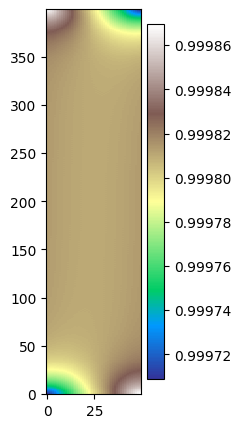

<Figure size 640x480 with 0 Axes>

In [ ]:
#@title Simulation Testing
Timer.enable()
date=strftime("%Y-%m-%d %H:%M:%S", localtime()).replace('-','').replace(' ','_').replace(':','')
tag="singleSOTonYIG"
svdir="/content/drive/Shareddrives/Ma Lab SPA/data/magnonics/magnumRAW/"+date+"_"+tag+"_data/"
nmesh=(400, 50, 1)
dmesh=(1e-9, 1e-9, 1e-9)
omesh=(0,0, 0.)
mesh = Mesh(nmesh,dmesh,omesh)
eps,tstart,tend,tstep = 1e-15,0,1E-10,1E-12
extF=[150E3,0,0]
state = State(mesh)
g=geom(state)
yg=materials(thickness=1E-9,init_pol=[0,-1,0],init_SOTcurrent=0)
yg.set_yig()
ygtor=materials(thickness=1E-9,init_pol=[0,-1,0],init_CHGcurrent=6.9e10)
ygtor.set_yig()
state.material=yg.matDict()
torqRegion1=g.set_strip(length=50E-9,width=10E-9,center=(200E-9,25E-9,0))
state=update_material(state,torqRegion1,ygtor.matDict())
# initialize field terms

fields={'external':ExternalField(extF),'exchange':ExchangeField(),'aniso':UniaxialAnisotropyField(),'torque':SpinOrbitTorque(),'demag':DemagField(20)}
writeReadme(svdir,nmesh,dmesh,omesh,eps,fields,tstart,tend,tstep,extF=extF,sotFreq=0,sotGeom=state.material['je'])

# initialize magnetization that relaxes into s-state
state.m = state.Constant([0,0,1])

# relax without external field
minimizer = MinimizerBB([fields['exchange'], fields['external'], fields['demag'],fields['aniso']])
minimizer.minimize(state)
blsi=bls_integration(state)
# perform integration with external field
state.t = tstart
llg = LLGSolver([fields['exchange'], fields['external'],fields['demag'],fields['torque'], fields['aniso']])

logger = Logger("/content/drive/Shareddrives/Ma Lab SPA/data/magnonics/magnumRAW/"+date+"_"+tag+"_data", scalars=['t', 'm', fields['torque'].h],fields=['m',fields['torque'].h,blsi.record_localAmp],fields_every=1)

while state.t < tend-eps:
    logger << state
    llg.step(state, tstep)

Timer.print_report()
plotState(state,var='m')

In [ ]:
def k2l(k):
    return 2*np.pi/k
def points2quad(p1,p2,p3):
    return np.linalg.solve(np.array(((p1[0]**2,p1[0],1),(p2[0]**2,p2[0],1),(p3[0]**2,p3[0],1))),np.array((p1[1],p2[1],p3[1])))

In [ ]:
k2l(79.1)

0.07943344256864206

In [ ]:
points2quad([7.27,0.656],[55.7,4.73],[93.9,12.54])

array([ 0.001389  , -0.00334376,  0.60689657])

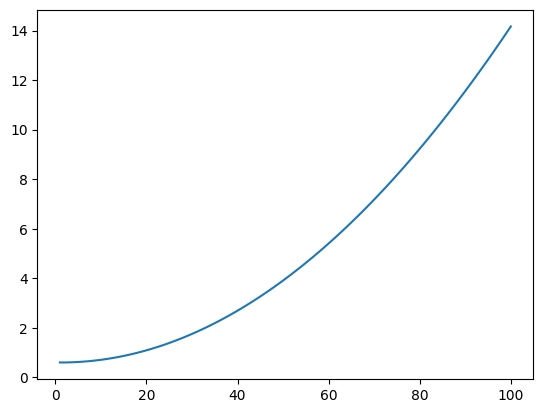

In [ ]:
flm=lambda x: 0.001389*x**2-0.00334376*x+0.60689657
plt.plot(np.linspace(1,100,100),flm(np.linspace(1,100,100)))
plt.show()

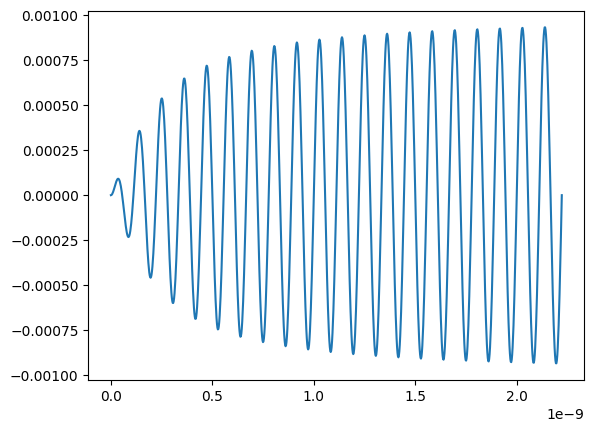

In [ ]:

curAmp=1E-3

curFreq=9E9
ts=np.linspace(0,1/curFreq*20,1000)
t_on=1/curFreq*2
ft=lambda t: curAmp*(2/np.pi)*np.arctan(t/t_on)*np.sin(curFreq*2*np.pi*t)
ys=ft(ts)
plt.plot(ts,ys)
#plt.savefig('xField.png')
plt.show()

In [ ]:
z[0][0][0]

DecoratedTensor(2.5000e-08, device='cuda:0')

In [ ]:
# @title
fd=('xy','z','x')
wlens=[9.88E-8,6.3E-7,1.7E-7]#x is BVMSW, y is MSSW, z is FVMSW
set_log_level(0)
field_dirs=[np.array((1,1,0))/np.sqrt(2),np.array((0,0,1)),np.array((1,0,0))]
for k in range(3):
    fielddir=field_dirs[k]
    tsim_start=datetime.now()
    wlen=wlens[k]
    Timer.enable()
    #date=strftime("%Y-%m-%d %H:%M:%S", localtime()).replace('-','').replace(' ','_').replace(':','')
    date=''
    #tag="MagPulseUnsat_extF"+fd[k]
    tag="YIGrelax_F"+fd[k]
    svdir=date+"_"+tag+"_data/"
    print(svdir)
    if not os.path.exists(svdir):
        os.mkdir(svdir)
    nmesh=(80, 80, 1)
    dmesh=(10e-9, 10e-9, 50e-9)
    omesh=(0,0, 0.)
    mesh = Mesh(nmesh,dmesh,omesh,pbc=(10,10,0))
    eps,tstart,tend,tstep,t_on = 1e-15,0,10E-9,1E-12,0.4E-9
    curFreq=0
    curAmp=0
    sotFreq=0
    sotAmp=0
    state = State(mesh)
    x,y,z=state.SpatialCoordinate()
    x0,z0=int(nmesh[0]/2)*dmesh[0],100E-9

    g=geom(state)
    #extF=lambda t: torch.stack([curAmp*(2/np.pi)*torch.arctan(t/t_on)*torch.sin(curFreq*2*np.pi*t)/(2*np.pi*((z-z0)**2+(x-x0)**2))*(z-z0),0*y,
    #                            170E3-curAmp*(2/np.pi)*torch.arctan(t/t_on)*torch.sin(curFreq*2*np.pi*t)/(2*np.pi*((z-z0)**2+(x-x0)**2))*(x-x0)],dim=-1)
    extF=lambda t: torch.stack([(t*1E8)**3*fielddir[0]*800E3+0*x,0*y+(t*1E8)**3*fielddir[1]*800E3,
                                (t*1E8)**3*fielddir[2]*800E3+0*z],dim=-1)

    #Base material is yig
    yg=materials(thickness=nmesh[2]*dmesh[2],init_pol=[0,-1,0])
    yg.set_yig()
    state.material=yg.matDict()
    state.m = state.Constant([0,1,0])

    # initialize field terms
    base_fields={'external':ExternalField(extF),'exchange':ExchangeField(),'aniso':CubicAnisotropyField(),'demag':DemagField(20)}
    extra_fields={}
    if sotAmp!=0:
        extra_fields['torque']=SpinOrbitTorque()
    base_fields_lis=[base_fields[key] for key in base_fields.keys()]
    extra_fields_lis=[extra_fields[key] for key in extra_fields.keys()]

    # relax without external field and without nonmagnetic layers
    minimizer = MinimizerBB(base_fields_lis)
    minimizer.minimize(state)
    # perform integration with external field
    state.t = tstart
    llg = LLGSolver(base_fields_lis+extra_fields_lis,atol=1E-3)
    record_scalars=[]
    record_scalars+=['t']
    record_scalars.append(('m[60,60,0]',lambda state: state.m[60,60,0,:]))
    record_scalars.append(('m[40,40,0]',lambda state: state.m[40,40,0,:]))
    record_scalars.append(('m[20,20,0]',lambda state: state.m[20,20,0,:]))
    record_scalars.append(('m[60,20,0]',lambda state: state.m[60,20,0,:]))
    logger = Logger(date+"_"+tag+"_data",scalars=record_scalars,fields=['m',base_fields['external'].h],fields_every=1000)
    tsim_mid=datetime.now()
    timingFlags=[tend*0.1*i for i in range(1,10)]+[tend+1]
    while state.t < tend-eps:
        if state.t>timingFlags[0]:
            print(str((11-len(timingFlags))*10)+'% time ellapsed')
            timingFlags.pop(0)
        logger << state
        llg.step(state, tstep)
    Timer.print_report()
    tsim_end=datetime.now()
    writeReadme(svdir,nmesh,dmesh,omesh,eps,(base_fields | extra_fields),tstart,tend,tstep,tsim_start,tsim_mid,tsim_end,extF=extF,chgFreq=curFreq,chgAmp=curAmp,sotAmp=sotAmp,sotFreq=sotFreq)
    k+=1

_YIGrelax_Fxy_data/


/usr/local/lib/python3.10/dist-packages/pyvista/core/grid.py:549: PyVistaDeprecationWarning: `dims` argument is deprecated. Please use `dimensions`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pyvista/core/grid.py:912: PyVistaDeprecationWarning: `UniformGrid` is deprecated. Use `ImageData` instead.
  warnings.warn(


10% time ellapsed
20% time ellapsed
30% time ellapsed
40% time ellapsed
50% time ellapsed
60% time ellapsed
70% time ellapsed
80% time ellapsed
90% time ellapsed

TIMER REPORT
Operation                     No of calls    Avg time [ms]    Total time [s]
--------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                    1     15861.8           15.8618
    ExternalField.h                     2         0.360326       0.000720652
    ExchangeField.h                     2       866.962          1.73392
    CubicAnisotropyField.h              2       447.71           0.89542
    DemagField.h                        2      6614.95          13.2299
ExternalField.h                        10         0.265872       0.00265872
LLGSolver.step                      10000        44.789        447.89
    ExternalField.h                120018         0.234271      28.1167
    ExchangeField.h                120018         0.764462      91.7492
    CubicAnis

Process ForkProcess-21:
Process ForkProcess-23:
Process ForkProcess-13:
Process ForkProcess-14:
Process ForkProcess-24:
Process ForkProcess-20:
Process ForkProcess-17:
Process ForkProcess-12:
Process ForkProcess-10:
Process ForkProcess-22:
Process ForkProcess-7:
Process ForkProcess-15:
Process ForkProcess-5:
Process ForkProcess-18:
Process ForkProcess-11:
Process ForkProcess-8:
Process ForkProcess-9:
Process ForkProcess-16:
Process ForkProcess-19:
Process ForkProcess-6:
Traceback (most recent call last):
Process ForkProcess-4:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (m

KeyboardInterrupt: ignored

Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()


In [ ]:
# @title
fd=('y','z','x')
wlens=[9.88E-8,6.3E-7,1.7E-7]#x is BVMSW, y is MSSW, z is FVMSW
set_log_level(0)
field_dirs=[np.array((0,1,0)),np.array((0,0,1)),np.array((1,0,0))]

nmesh=(100, 100, 1)
dmesh=(10e-9, 10e-9, 70e-9)
omesh=(0,0, 0.)
mesh = Mesh(nmesh,dmesh,omesh,pbc=(10,10,0))
state = State(mesh)

x,y,z=state.SpatialCoordinate()
yg=materials(thickness=nmesh[2]*dmesh[2],init_pol=[0,-1,0])
yg.set_yig()
state.material=yg.matDict()
state.material['alpha']=0.1

mags={}
fieldvals=200E3*np.linspace(0,1,80)**3
normdir=np.array((random(),random(),random()))
normdir/=np.linalg.norm(normdir)
state.m=state.Constant(normdir)
minimizer = MinimizerBB([ExchangeField(),CubicAnisotropyField(),DemagField(20)])
minimizer.minimize(state,maxiter=200)
mstart=np.array(state.m.avg().cpu())

for k in [1]:
    fdir=field_dirs[k]
    mags[fd[k]]=[]
    j=0
    for fv in fieldvals:
        if j in range(0,101,30):
            print(str(int(j))+'% done with F'+fd[k])
        extF=torch.stack([fv*fdir[0]+0*x,fv*fdir[1]+0*y,fv*fdir[2]+0*z],dim=-1)
        state.m=state.Constant(mstart)
        minimizer = MinimizerBB([ExchangeField(),CubicAnisotropyField(),DemagField(20),ExternalField(extF)])
        minimizer.minimize(state)
        mags[fd[k]].append(np.array(state.m.avg().cpu()))
        j+=1
        print(j)
    dat={'fieldAmps':fieldvals,'mags':mags,'mstart':mstart}
    f=open('YIGrelaxData2.txt','wb')
    pickle.dump(dat,f)
    f.close()

KeyboardInterrupt: ignored

In [ ]:
# @title
fd=('y','x','z')
wlens=[9.88E-8,6.3E-7,1.7E-7]#x is BVMSW, y is MSSW, z is FVMSW
set_log_level(0)
field_dirs=[np.array((0,1,0)),np.array((1,0,0)),np.array((0,0,1))]

nmesh=(100, 100, 1)
dmesh=(10e-9, 10e-9, 26e-9)
omesh=(0,0, 0.)
mesh = Mesh(nmesh,dmesh,omesh,pbc=(10,10,0))
state = State(mesh)

x,y,z=state.SpatialCoordinate()
yg=materials(thickness=nmesh[2]*dmesh[2],init_pol=np.array([1,1,0])/np.sqrt(2))
yg.set_yig()
state.material=yg.matDict()
state.material['Ms']=140E3
mags={}
fieldvals=300E3*np.linspace(0,1,100)**3
normdir=np.array((random(),random(),random()))
normdir/=np.linalg.norm(normdir)
state.m=state.Constant(normdir)
minimizer = MinimizerBB([ExchangeField(),CubicAnisotropyField(),DemagField(20)])
minimizer.minimize(state)
mstart=np.array(state.m.avg().cpu())

for k in range(3):
    fdir=field_dirs[k]
    mags[fd[k]]=[]
    j=0
    for fv in fieldvals:
        if j in range(0,101,30):
            print(str(int(j))+'% done with F'+fd[k])
        extF=torch.stack([fv*fdir[0]+0*x,fv*fdir[1]+0*y,fv*fdir[2]+0*z],dim=-1)
        state.m=state.Constant(mstart)
        minimizer = MinimizerBB([ExchangeField(),CubicAnisotropyField(),DemagField(20),ExternalField(extF)])
        minimizer.minimize(state)
        mags[fd[k]].append(np.array(state.m.avg().cpu()))
        j+=1
        print(j)
dat={'fieldAmps':fieldvals,'mags':mags,'mstart':mstart}
f=open('YIGrelaxData26nm.txt','wb')
pickle.dump(dat,f)
f.close()

0% done with Fy
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
30% done with Fy
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
60% done with Fy
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
90% done with Fy
91
92
93
94
95
96
97
98
99
100
0% done with Fx
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
30% done with Fx
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
60% done with Fx
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
90% done with Fx
91
92
93
94
95
96
97
98
99
100
0% done with Fz
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
30% done with Fz
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
60% done with Fz
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
8

In [ ]:
# @title
fd=('x','y','z')
wlens=[9.88E-8,6.3E-7,1.7E-7]#x is BVMSW, y is MSSW, z is FVMSW
set_log_level(0)
field_dirs=[np.array((1,0,0)),np.array((0,1,0)),np.array((0,0,1))]
for sotFreq in [2E9,3E9,4E9,5E9,6E9,7E9]:
    for k in range(3):
        pd=[-1,0,0]
        tsim_start=datetime.now()
        Timer.enable()
        #date=strftime("%Y-%m-%d %H:%M:%S", localtime()).replace('-','').replace(' ','_').replace(':','')
        date=''
        #tag="MagPulseUnsat_extF"+fd[k]
        tag="SOT"+str(round(sotFreq*1E-9,1)).replace('.','p')+"ModZ1mA_F"+fd[k]
        svdir=date+"_"+tag+"_data/"
        print(svdir)
        if not os.path.exists(svdir):
            os.mkdir(svdir)
        nmesh=(1600, 1, 1)
        dmesh=(1E-8, 50e-9, 50e-9)
        omesh=(0,0, 0.)
        mesh = Mesh(nmesh,dmesh,omesh,pbc=(1,60,0))
        eps,tstart,tend,tstep,t_on = 1e-15,0,20/sotFreq,1E-12,1/sotFreq*7
        print((dmesh[0],tstep,tend))
        sotAmp=100E-6/(100E-9*100E-9)*10
        state = State(mesh)
        x,y,z=state.SpatialCoordinate()
        x0,z0=int(nmesh[0]/2)*dmesh[0],100E-9
        fielddir=field_dirs[k]
        g=geom(state)
        #extF=lambda t: torch.stack([curAmp*(2/np.pi)*torch.arctan(t/t_on)*torch.sin(curFreq*2*np.pi*t)/(2*np.pi*((z-z0)**2+(x-x0)**2))*(z-z0),0*y,
        #                            170E3-curAmp*(2/np.pi)*torch.arctan(t/t_on)*torch.sin(curFreq*2*np.pi*t)/(2*np.pi*((z-z0)**2+(x-x0)**2))*(x-x0)],dim=-1)
        extF=lambda t: torch.stack([0*x+7E3*fielddir[0],0*y+7E3*fielddir[1],
                                    143E3*fielddir[2]+0*z],dim=-1)

        #Base material is yig
        yg=materials(thickness=nmesh[2]*dmesh[2],init_pol=pd)
        yg.set_yig()
        state.material=yg.matDict()
        state.m = state.Constant([0,0,1])
        state.material['alpha'][0:200,:,:,:]=1
        state.material['alpha'][1400:,:,:,:]=1

        #We yhave to define the space and time dependence of the SOT current seperately
        state.material['jeMag']=0
        state.material['jeMag'][795:805,:,:,:]=sotAmp#First, define a dummy material parameter giving the SOT amplitude only along the 100nm wire
        state.material['je']=lambda t: state.material['jeMag']*(torch.kaiser_window(int(t_on/tstep)*2,periodic=False,beta=10.0)[int(t/tstep*int(t<=t_on)*int(t<=t_on))]*int(t<=t_on)+1*int(t>t_on))*torch.sin(sotFreq*2*np.pi*t)#Then, create a tensor multiplying the SOT amp at all places by the time dependence

        # initialize field terms
        base_fields={'external':ExternalField(extF),'exchange':ExchangeField(),'aniso':UniaxialAnisotropyField(),'demag':DemagField(20)}
        extra_fields={}
        if sotAmp!=0:
            extra_fields['torque']=SpinOrbitTorque()
        base_fields_lis=[base_fields[key] for key in base_fields.keys()]
        extra_fields_lis=[extra_fields[key] for key in extra_fields.keys()]

        # relax without external field and without nonmagnetic layers
        minimizer = MinimizerBB(base_fields_lis)
        minimizer.minimize(state)
        # perform integration with external field
        state.t = tstart
        llg = LLGSolver(base_fields_lis+extra_fields_lis,atol=1E-3)
        record_scalars=[]
        record_scalars+=['t']
        for capture_x in list(range(806,1200)):
            record_scalars.append(('m['+str(capture_x)+',0,0]',create_lambda(capture_x)))
        logger = Logger(date+"_"+tag+"_data",scalars=record_scalars,fields=['m',extra_fields['torque'].h],fields_every=int(tend/tstep/10))
        tsim_mid=datetime.now()
        timingFlags=[tend*0.1*i for i in range(1,10)]+[tend+1]
        while state.t < tend-eps:
            if state.t>timingFlags[0]:
                print(str((11-len(timingFlags))*10)+'% time ellapsed')
                timingFlags.pop(0)
            logger << state
            llg.step(state, tstep)
        Timer.print_report()
        tsim_end=datetime.now()
        writeReadme(svdir,nmesh,dmesh,omesh,eps,(base_fields | extra_fields),tstart,tend,tstep,tsim_start,tsim_mid,tsim_end,extF=extF,chgFreq=0,chgAmp=0,sotAmp=sotAmp,sotFreq=sotFreq)
        k+=1

_SOT2p0ModZ1mA_Fx_data/
(1e-08, 1e-12, 1e-08)


/usr/local/lib/python3.10/dist-packages/pyvista/core/grid.py:549: PyVistaDeprecationWarning: `dims` argument is deprecated. Please use `dimensions`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pyvista/core/grid.py:912: PyVistaDeprecationWarning: `UniformGrid` is deprecated. Use `ImageData` instead.
  warnings.warn(


10% time ellapsed
20% time ellapsed
30% time ellapsed
40% time ellapsed
50% time ellapsed
60% time ellapsed
70% time ellapsed
80% time ellapsed
90% time ellapsed

TIMER REPORT
Operation                        No of calls    Avg time [ms]    Total time [s]
-----------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                       6     12894.5             77.3671
    ExternalField.h                       76         0.19776          0.0150297
    ExchangeField.h                       76        28.5944           2.17318
    UniaxialAnisotropyField.h             76         0.143533         0.0109085
    DemagField.h                          76       986.722           74.9909
SpinOrbitTorque.h                         60         0.935078         0.0561047
LLGSolver.step                         30000        40.87          1226.1
    ExternalField.h                   360108         0.153448        55.2577
    ExchangeField.h                   360

<ipython-input-30-0c639032651f>:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  plt.plot(np.array(ts)*1E9,ys)
/usr/local/lib/python3.10/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


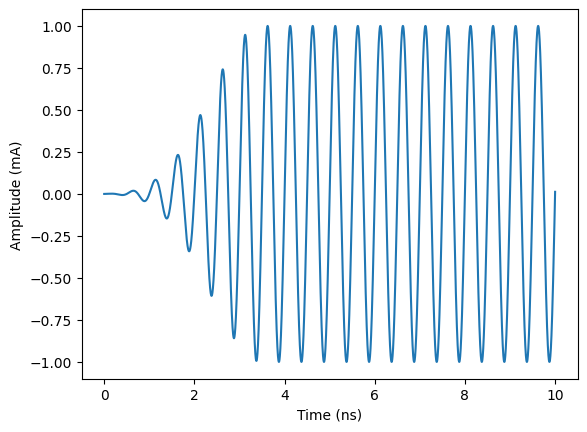

In [ ]:
 lenn=187

tstep=1E-12
sotFreq=2E9
t_on=1/sotFreq*7
cc=lambda t: (torch.kaiser_window(int(t_on/tstep)*2,periodic=False,beta=10.0)[int(t/tstep*int(t<=t_on)*int(t<=t_on))]*int(t<=t_on)+1*int(t>t_on))*torch.sin(sotFreq*2*np.pi*t)
ts=[torch.Tensor([0])]
while ts[-1]<=1/sotFreq*20:
    ts.append(ts[-1]+tstep)
ys=[cc(t) for t in ts]
plt.plot(np.array(ts)*1E9,ys)
plt.ylabel('Amplitude (mA)')
plt.xlabel('Time (ns)')
plt.savefig('currentProfile.png',dpi=500)

In [ ]:
# @title
fd=('x','y','z')
wlens=[9.88E-8,6.3E-7,1.7E-7]#x is BVMSW, y is MSSW, z is FVMSW
set_log_level(0)
field_dirs=[np.array((1,0,0)),np.array((0,1,0)),np.array((0,0,1))]
for curFreq in [5E9]:
    for k in range(3):
        pd=[-1,0,0]
        tsim_start=datetime.now()
        Timer.enable()
        #date=strftime("%Y-%m-%d %H:%M:%S", localtime()).replace('-','').replace(' ','_').replace(':','')
        date=''
        #tag="MagPulseUnsat_extF"+fd[k]
        tag="uStrip"+str(round(curFreq*1E-9,1)).replace('.','p')+"SatZ1mA_F"+fd[k]
        svdir=date+"_"+tag+"_data/"
        print(svdir)
        if not os.path.exists(svdir):
            os.mkdir(svdir)
        nmesh=(1600, 1, 1)
        dmesh=(1E-8, 50e-9, 50e-9)
        omesh=(0,0, 0.)
        mesh = Mesh(nmesh,dmesh,omesh,pbc=(1,60,0))
        eps,tstart,tend,tstep,t_on = 1e-15,0,20/curFreq,1E-12,1/curFreq*7
        print((dmesh[0],tstep,tend))
        sotAmp=0
        curAmp=100E-6*10
        state = State(mesh)
        x,y,z=state.SpatialCoordinate()
        x01,z0=int(nmesh[0]/2)*dmesh[0],100E-9
        fielddir=field_dirs[k]
        g=geom(state)
        #extF=lambda t: torch.stack([curAmp*(2/np.pi)*torch.arctan(t/t_on)*torch.sin(curFreq*2*np.pi*t)/(2*np.pi*((z-z0)**2+(x-x0)**2))*(z-z0),0*y,
        #                            170E3-curAmp*(2/np.pi)*torch.arctan(t/t_on)*torch.sin(curFreq*2*np.pi*t)/(2*np.pi*((z-z0)**2+(x-x0)**2))*(x-x0)],dim=-1)
        extF=lambda t: torch.stack([curAmp*(torch.kaiser_window(int(t_on/tstep)*2,periodic=False,beta=10.0)[int(t/tstep*int(t<=t_on)*int(t<=t_on))]*int(t<=t_on)+1*int(t>t_on))*torch.sin(curFreq*2*np.pi*t)/(2*np.pi*((z-z0)**2+(x-x01)**2))*(z-z0)+7.5E3*fielddir[0],0*y+7.5E3*fielddir[1],
                                145E3*fielddir[2]-curAmp*(torch.kaiser_window(int(t_on/tstep)*2,periodic=False,beta=10.0)[int(t/tstep*int(t<=t_on)*int(t<=t_on))]*int(t<=t_on)+1*int(t>t_on))*torch.sin(curFreq*2*np.pi*t)/(2*np.pi*((z-z0)**2+(x-x01)**2))*(x-x01)],dim=-1)


        #Base material is yig
        yg=materials(thickness=nmesh[2]*dmesh[2],init_pol=pd)
        yg.set_yig()
        state.material=yg.matDict()
        state.m = state.Constant([0,0,1])
        state.material['alpha'][0:200,:,:,:]=1
        state.material['alpha'][1400:,:,:,:]=1

        # initialize field terms
        base_fields={'external':ExternalField(extF),'exchange':ExchangeField(),'aniso':UniaxialAnisotropyField(),'demag':DemagField(20)}
        extra_fields={}
        base_fields_lis=[base_fields[key] for key in base_fields.keys()]
        extra_fields_lis=[extra_fields[key] for key in extra_fields.keys()]

        # relax without external field and without nonmagnetic layers
        minimizer = MinimizerBB(base_fields_lis)
        minimizer.minimize(state)
        # perform integration with external field
        state.t = tstart
        llg = LLGSolver(base_fields_lis+extra_fields_lis,atol=1E-3)
        record_scalars=[]
        record_scalars+=['t']
        for capture_x in list(range(806,1200)):
            record_scalars.append(('m['+str(capture_x)+',0,0]',create_lambda(capture_x)))
        logger = Logger(date+"_"+tag+"_data",scalars=record_scalars,fields=['m',base_fields['external'].h],fields_every=int(tend/tstep/10),scalars_every=1)
        tsim_mid=datetime.now()
        timingFlags=[tend*0.1*i for i in range(1,10)]+[tend+1]
        while state.t < tend-eps:
            if state.t>timingFlags[0]:
                print(str((11-len(timingFlags))*10)+'% time ellapsed')
                timingFlags.pop(0)
            logger << state
            llg.step(state, tstep)
        Timer.print_report()
        tsim_end=datetime.now()
        writeReadme(svdir,nmesh,dmesh,omesh,eps,(base_fields | extra_fields),tstart,tend,tstep,tsim_start,tsim_mid,tsim_end,extF=extF,chgFreq=curFreq,chgAmp=curAmp,sotAmp=0,sotFreq=0)
        k+=1

_uStrip5p0SatZ1mA_Fx_data/
(1e-08, 1e-12, 4e-09)


/usr/local/lib/python3.10/dist-packages/pyvista/core/grid.py:549: PyVistaDeprecationWarning: `dims` argument is deprecated. Please use `dimensions`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pyvista/core/grid.py:912: PyVistaDeprecationWarning: `UniformGrid` is deprecated. Use `ImageData` instead.
  warnings.warn(


10% time ellapsed
20% time ellapsed
30% time ellapsed
40% time ellapsed
50% time ellapsed
60% time ellapsed
70% time ellapsed
80% time ellapsed
90% time ellapsed

TIMER REPORT
Operation                                                                                No of calls    Avg time [ms]    Total time [s]
-------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                               2     19986.3            39.9726
    ExternalField.h                                                                               22         1.85902         0.0408984
    ExchangeField.h                                                                               22        86.5806          1.90477
    UniaxialAnisotropyField.h                                                                     22         0.171359        0.00376989
    DemagField.h

In [ ]:
# @title
fd=('x','y','z')
wlens=[9.88E-8,6.3E-7,1.7E-7]#x is BVMSW, y is MSSW, z is FVMSW
set_log_level(0)
field_dirs=[np.array((1,0,0)),np.array((0,1,0)),np.array((0,0,1))]
for curFreq in [5E9]:
    for k in range(3):
        pd=[-1,0,0]
        tsim_start=datetime.now()
        Timer.enable()
        #date=strftime("%Y-%m-%d %H:%M:%S", localtime()).replace('-','').replace(' ','_').replace(':','')
        date=''
        #tag="MagPulseUnsat_extF"+fd[k]
        tag="uStrip"+str(round(curFreq*1E-9,1)).replace('.','p')+"HighZ1mA_F"+fd[k]
        svdir=date+"_"+tag+"_data/"
        print(svdir)
        if not os.path.exists(svdir):
            os.mkdir(svdir)
        nmesh=(1600, 1, 1)
        dmesh=(1E-8, 50e-9, 50e-9)
        omesh=(0,0, 0.)
        mesh = Mesh(nmesh,dmesh,omesh,pbc=(1,60,0))
        eps,tstart,tend,tstep,t_on = 1e-15,0,20/curFreq,1E-12,1/curFreq*7
        print((dmesh[0],tstep,tend))
        sotAmp=0
        curAmp=100E-6*10
        state = State(mesh)
        x,y,z=state.SpatialCoordinate()
        x01,z0=int(nmesh[0]/2)*dmesh[0],100E-9
        fielddir=field_dirs[k]
        g=geom(state)
        #extF=lambda t: torch.stack([curAmp*(2/np.pi)*torch.arctan(t/t_on)*torch.sin(curFreq*2*np.pi*t)/(2*np.pi*((z-z0)**2+(x-x0)**2))*(z-z0),0*y,
        #                            170E3-curAmp*(2/np.pi)*torch.arctan(t/t_on)*torch.sin(curFreq*2*np.pi*t)/(2*np.pi*((z-z0)**2+(x-x0)**2))*(x-x0)],dim=-1)
        extF=lambda t: torch.stack([curAmp*(torch.kaiser_window(int(t_on/tstep)*2,periodic=False,beta=10.0)[int(t/tstep*int(t<=t_on)*int(t<=t_on))]*int(t<=t_on)+1*int(t>t_on))*torch.sin(curFreq*2*np.pi*t)/(2*np.pi*((z-z0)**2+(x-x01)**2))*(z-z0)+140E3*fielddir[0],0*y+140E3*fielddir[1],
                                140E3*fielddir[2]-curAmp*(torch.kaiser_window(int(t_on/tstep)*2,periodic=False,beta=10.0)[int(t/tstep*int(t<=t_on)*int(t<=t_on))]*int(t<=t_on)+1*int(t>t_on))*torch.sin(curFreq*2*np.pi*t)/(2*np.pi*((z-z0)**2+(x-x01)**2))*(x-x01)],dim=-1)


        #Base material is yig
        yg=materials(thickness=nmesh[2]*dmesh[2],init_pol=pd)
        yg.set_yig()
        state.material=yg.matDict()
        state.m = state.Constant([0,0,1])
        state.material['alpha'][0:200,:,:,:]=1
        state.material['alpha'][1400:,:,:,:]=1

        # initialize field terms
        base_fields={'external':ExternalField(extF),'exchange':ExchangeField(),'aniso':UniaxialAnisotropyField(),'demag':DemagField(20)}
        extra_fields={}
        base_fields_lis=[base_fields[key] for key in base_fields.keys()]
        extra_fields_lis=[extra_fields[key] for key in extra_fields.keys()]

        # relax without external field and without nonmagnetic layers
        minimizer = MinimizerBB(base_fields_lis)
        minimizer.minimize(state)
        # perform integration with external field
        state.t = tstart
        llg = LLGSolver(base_fields_lis+extra_fields_lis,atol=1E-3)
        record_scalars=[]
        record_scalars+=['t']
        for capture_x in list(range(806,1200)):
            record_scalars.append(('m['+str(capture_x)+',0,0]',create_lambda(capture_x)))
        logger = Logger(date+"_"+tag+"_data",scalars=record_scalars,fields=['m',base_fields['external'].h],fields_every=int(tend/tstep/10),scalars_every=1)
        tsim_mid=datetime.now()
        timingFlags=[tend*0.1*i for i in range(1,10)]+[tend+1]
        while state.t < tend-eps:
            if state.t>timingFlags[0]:
                print(str((11-len(timingFlags))*10)+'% time ellapsed')
                timingFlags.pop(0)
            logger << state
            llg.step(state, tstep)
        Timer.print_report()
        tsim_end=datetime.now()
        writeReadme(svdir,nmesh,dmesh,omesh,eps,(base_fields | extra_fields),tstart,tend,tstep,tsim_start,tsim_mid,tsim_end,extF=extF,chgFreq=curFreq,chgAmp=curAmp,sotAmp=0,sotFreq=0)
        k+=1

_uStrip5p0HighZ1mA_Fx_data/
(1e-08, 1e-12, 4e-09)
10% time ellapsed
20% time ellapsed
30% time ellapsed
40% time ellapsed
50% time ellapsed
60% time ellapsed
70% time ellapsed
80% time ellapsed
90% time ellapsed

TIMER REPORT
Operation                                                                                No of calls    Avg time [ms]    Total time [s]
-------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                               2     19986.3            39.9726
    ExternalField.h                                                                               22         1.85902         0.0408984
    ExchangeField.h                                                                               22        86.5806          1.90477
    UniaxialAnisotropyField.h                                                                     22  

In [ ]:
# @title
fd=('x','y','z')
wlens=[9.88E-8,6.3E-7,1.7E-7]#x is BVMSW, y is MSSW, z is FVMSW
set_log_level(0)
field_dirs=[np.array((1,0,0)),np.array((0,1,0)),np.array((0,0,1))]
for sotFreq in [5E9]:
    for k in range(3):
        pd=[-1,0,0]
        tsim_start=datetime.now()
        Timer.enable()
        #date=strftime("%Y-%m-%d %H:%M:%S", localtime()).replace('-','').replace(' ','_').replace(':','')
        date=''
        #tag="MagPulseUnsat_extF"+fd[k]
        tag="SOT"+str(round(sotFreq*1E-9,1)).replace('.','p')+"SatZ1mA_F"+fd[k]
        svdir=date+"_"+tag+"_data/"
        print(svdir)
        if not os.path.exists(svdir):
            os.mkdir(svdir)
        nmesh=(1600, 1, 1)
        dmesh=(1E-8, 50e-9, 50e-9)
        omesh=(0,0, 0.)
        mesh = Mesh(nmesh,dmesh,omesh,pbc=(1,60,0))
        eps,tstart,tend,tstep,t_on = 1e-15,0,20/sotFreq,1E-12,1/sotFreq*7
        print((dmesh[0],tstep,tend))
        sotAmp=100E-6/(100E-9*100E-9)*10
        state = State(mesh)
        x,y,z=state.SpatialCoordinate()
        x0,z0=int(nmesh[0]/2)*dmesh[0],100E-9
        fielddir=field_dirs[k]
        g=geom(state)
        #extF=lambda t: torch.stack([curAmp*(2/np.pi)*torch.arctan(t/t_on)*torch.sin(curFreq*2*np.pi*t)/(2*np.pi*((z-z0)**2+(x-x0)**2))*(z-z0),0*y,
        #                            170E3-curAmp*(2/np.pi)*torch.arctan(t/t_on)*torch.sin(curFreq*2*np.pi*t)/(2*np.pi*((z-z0)**2+(x-x0)**2))*(x-x0)],dim=-1)
        extF=lambda t: torch.stack([0*x+7.5E3*fielddir[0],0*y+7.5E3*fielddir[1],
                                    145E3*fielddir[2]+0*z],dim=-1)

        #Base material is yig
        yg=materials(thickness=nmesh[2]*dmesh[2],init_pol=pd)
        yg.set_yig()
        state.material=yg.matDict()
        state.m = state.Constant([0,0,1])
        state.material['alpha'][0:200,:,:,:]=1
        state.material['alpha'][1400:,:,:,:]=1

        #We yhave to define the space and time dependence of the SOT current seperately
        state.material['jeMag']=0
        state.material['jeMag'][795:805,:,:,:]=sotAmp#First, define a dummy material parameter giving the SOT amplitude only along the 100nm wire
        state.material['je']=lambda t: state.material['jeMag']*(torch.kaiser_window(int(t_on/tstep)*2,periodic=False,beta=10.0)[int(t/tstep*int(t<=t_on)*int(t<=t_on))]*int(t<=t_on)+1*int(t>t_on))*torch.sin(sotFreq*2*np.pi*t)#Then, create a tensor multiplying the SOT amp at all places by the time dependence

        # initialize field terms
        base_fields={'external':ExternalField(extF),'exchange':ExchangeField(),'aniso':UniaxialAnisotropyField(),'demag':DemagField(20)}
        extra_fields={}
        if sotAmp!=0:
            extra_fields['torque']=SpinOrbitTorque()
        base_fields_lis=[base_fields[key] for key in base_fields.keys()]
        extra_fields_lis=[extra_fields[key] for key in extra_fields.keys()]

        # relax without external field and without nonmagnetic layers
        minimizer = MinimizerBB(base_fields_lis)
        minimizer.minimize(state)
        # perform integration with external field
        state.t = tstart
        llg = LLGSolver(base_fields_lis+extra_fields_lis,atol=1E-3)
        record_scalars=[]
        record_scalars+=['t']
        for capture_x in list(range(806,1200)):
            record_scalars.append(('m['+str(capture_x)+',0,0]',create_lambda(capture_x)))
        logger = Logger(date+"_"+tag+"_data",scalars=record_scalars,fields=['m',extra_fields['torque'].h],fields_every=int(tend/tstep/10))
        tsim_mid=datetime.now()
        timingFlags=[tend*0.1*i for i in range(1,10)]+[tend+1]
        while state.t < tend-eps:
            if state.t>timingFlags[0]:
                print(str((11-len(timingFlags))*10)+'% time ellapsed')
                timingFlags.pop(0)
            logger << state
            llg.step(state, tstep)
        Timer.print_report()
        tsim_end=datetime.now()
        writeReadme(svdir,nmesh,dmesh,omesh,eps,(base_fields | extra_fields),tstart,tend,tstep,tsim_start,tsim_mid,tsim_end,extF=extF,chgFreq=0,chgAmp=0,sotAmp=sotAmp,sotFreq=sotFreq)
        k+=1

_SOT5p0SatZ1mA_Fx_data/
(1e-08, 1e-12, 4e-09)


/usr/local/lib/python3.10/dist-packages/pyvista/core/grid.py:549: PyVistaDeprecationWarning: `dims` argument is deprecated. Please use `dimensions`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pyvista/core/grid.py:912: PyVistaDeprecationWarning: `UniformGrid` is deprecated. Use `ImageData` instead.
  warnings.warn(


10% time ellapsed
20% time ellapsed
30% time ellapsed
40% time ellapsed
50% time ellapsed
60% time ellapsed
70% time ellapsed
80% time ellapsed
90% time ellapsed

TIMER REPORT
Operation                                                                                No of calls    Avg time [ms]    Total time [s]
-------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                               2     19986.3            39.9726
    ExternalField.h                                                                               22         1.85902         0.0408984
    ExchangeField.h                                                                               22        86.5806          1.90477
    UniaxialAnisotropyField.h                                                                     22         0.171359        0.00376989
    DemagField.h

In [ ]:
# @title
fd=('x','y','z')
wlens=[9.88E-8,6.3E-7,1.7E-7]#x is BVMSW, y is MSSW, z is FVMSW
set_log_level(0)
field_dirs=[np.array((1,0,0)),np.array((0,1,0)),np.array((0,0,1))]
wlens={'3p0':[172E-9,383E-9,172E-9],'6p0':[105E-9,127E-9,110E-9]}
pd=[-1,0,0]
for excitationType in ['uStrip','SOT','Both']:#Whether excitation is from SOT, uStrip, or SOT with inductive field modeling
    for wireThickness in [10E-9,50E-9]:#Thickness of each electrode
        for numElectrodes in [1,4,8]:#Number of electrodes
            if numElectrodes==1:
                useconfigs=['ap']
            else:
                useconfigs=['ap','p']
            for config in useconfigs:#Wether current in neighboring wires is parallel or antiparallel
                freqit=0
                for sotFreq in [3E9,6E9]:#Frequency of excitation
                    for k in [1]:#Field direction
                        freqString=str(round(sotFreq*1E-9,1)).replace('.','p')
                        wtString=str(int(wireThickness*1E9))+'nm'
                        tsim_start=datetime.now()
                        Timer.enable()
                        tag=excitationType+freqString+'_'+wtString+'_'+str(numElectrodes)+config+'_F'+fd[k]+'_constantI'
                        svdir=tag+"_data/"
                        print(svdir)
                        if not os.path.exists(svdir):
                            os.mkdir(svdir)
                        nmesh=(1600, 1, 1)
                        dmesh=(1E-8, 50e-9, 50e-9)
                        omesh=(0,0, 0.)
                        cellsPerWire=int(round(wireThickness/dmesh[0],0))#Number of cells required to make a wire of the appropriate thickness, rounded to integer
                        cellsPerWlen=int(round(wlens[freqString][k]/dmesh[0],0))#Number of cells in one wavelength, rounded to integer
                        if config=='ap':#If antiparallel
                            wireSpacing=int(np.ceil(cellsPerWlen/2))#Electrode spacing is 1/2 wavelength. Round up.
                        else:#If parallel
                            wireSpacing=cellsPerWlen#Electrode spacing is 1 wavelength
                        mesh = Mesh(nmesh,dmesh,omesh,pbc=(1,60,0))
                        eps,tstart,tend,tstep,t_on = 1e-15,0,16/sotFreq,1E-12,1/sotFreq*7
                        sotAmp=100E-6/(50E-9*50E-9)*10
                        curAmp=1E-3
                        state = State(mesh)
                        x,y,z=state.SpatialCoordinate()
                        fielddir=field_dirs[k]
                        x0s,z0=[],100E-9
                        windowFunc=lambda t: (torch.kaiser_window(int(t_on/tstep)*2,periodic=False,beta=10.0)[int(t/tstep*int(t<=t_on)*int(t<=t_on))]*int(t<=t_on)+1*int(t>t_on))*torch.sin(sotFreq*2*np.pi*t)#Time dependence of the excitation, with turn-on period
                        if excitationType=='uStrip' or excitationType=='Both':
                            signs=[1]
                            for ne in range(numElectrodes):
                                x0s.append(int(nmesh[0]/2)*dmesh[0]-np.floor(numElectrodes/2)*wireSpacing*dmesh[0]+ne*wireSpacing*dmesh[0])#Get center line of each wire; = center of sample - 1/2*(total number of wire spacings)+ne*wireSpacings
                                signs.append((-1*signs[-1])**int(config=='ap'))#Get sign of each wire. Only alternates in antiparallel configuration
                            extF=lambda t: torch.stack([0*x+7E3*fielddir[0],0*y+7E3*fielddir[1],140E3*fielddir[2]+0*z],dim=-1)+sum([torch.stack([signs[j]*curAmp*windowFunc(t)/(2*np.pi*((z-z0)**2+(x-x0s[j])**2))*(z-z0),0*y,-1*signs[j]*curAmp*windowFunc(t)/(2*np.pi*((z-z0)**2+(x-x0s[j])**2))*(x-x0s[j])],dim=-1) for j in range(len(x0s))])#Add excitation fields to the bias field
                        else:
                            extF=lambda t: torch.stack([0*x+7E3*fielddir[0],0*y+7E3*fielddir[1],140E3*fielddir[2]+0*z],dim=-1)#Just have the bias field

                        recordF=[7E3*fielddir[0],7E3*fielddir[1],140E3*fielddir[2]]
                        #Base material is yig
                        yg=materials(thickness=nmesh[2]*dmesh[2],init_pol=pd)
                        yg.set_yig()
                        state.material=yg.matDict()
                        state.m = state.Constant([0,0,1])
                        state.material['alpha'][0:200,:,:,:]=1#Extra Damping on ends
                        state.material['alpha'][1400:,:,:,:]=1#Extra Damping on ends

                        # initialize field terms
                        base_fields={'external':ExternalField(extF),'exchange':ExchangeField(),'aniso':UniaxialAnisotropyField(),'demag':DemagField(20)}
                        keepFields=['m',base_fields['external'].h,]#Which fields to include in output plots
                        extra_fields={}
                        if excitationType=='SOT' or excitationType=='Both':
                            state.material['jeMag']=0
                            for ne in range(numElectrodes):
                                leftExtent=int(np.floor(nmesh[0]/2)-np.floor(numElectrodes/2)*wireSpacing+ne*wireSpacing-np.floor(cellsPerWire/2))#The left extent of this SOT region is the center of the sample-1/2*(number of wire spacings)+ne*(wire spacing)-1/2*(cells per wire), rounded down
                                state.material['jeMag'][leftExtent:leftExtent+cellsPerWire,:,:,:]=sotAmp*(-1)**(ne*int(config=='ap'))#Right extent is the left extent plus cells per wire
                            state.material['je']=lambda t: state.material['jeMag']*windowFunc(t)#Apply windowFunc to the magnitude
                            extra_fields['torque']=SpinOrbitTorque()
                            keepFields.append(extra_fields['torque'].h)
                        base_fields_lis=[base_fields[key] for key in base_fields.keys()]
                        extra_fields_lis=[extra_fields[key] for key in extra_fields.keys()]
                        # relax without external field and without nonmagnetic layers
                        minimizer = MinimizerBB(base_fields_lis)
                        minimizer.minimize(state)
                        # perform integration with external field
                        state.t = tstart
                        llg = LLGSolver(base_fields_lis+extra_fields_lis,atol=1E-3)
                        record_scalars=[]
                        record_scalars+=['t']
                        for capture_x in list(range(500,1100)):
                            record_scalars.append(('m['+str(capture_x)+',0,0]',create_lambda(capture_x)))
                        logger = Logger(svdir,scalars=record_scalars,fields=keepFields,fields_every=int(tend/tstep/10),scalars_every=5)
                        tsim_mid=datetime.now()
                        timingFlags=[tend*0.1*i for i in range(1,10)]+[tend+1]
                        while state.t < tend-eps:
                            if state.t>timingFlags[0]:
                                print(str((11-len(timingFlags))*10)+'% time ellapsed')
                                timingFlags.pop(0)
                            logger << state
                            llg.step(state, tstep)
                        Timer.print_report()
                        tsim_end=datetime.now()
                        writeReadme(svdir,nmesh,dmesh,omesh,eps,(base_fields | extra_fields),tstart,tend,tstep,tsim_start,tsim_mid,tsim_end,extF=recordF,chgFreq=sotFreq*int((excitationType=='uStrip' or excitationType=='Both')),chgAmp=sotAmp*int((excitationType=='uStrip' or excitationType=='Both')),sotAmp=sotAmp*int((excitationType=='SOT' or excitationType=='Both')),sotFreq=sotFreq*int((excitationType=='SOT' or excitationType=='Both')),scalars_every=2,fields_every=int(tend/tstep/10))
                        pruneFile(svdir)
                    freqit+=1

uStrip3p0_10nm_1ap_Fy_constantI_data/


/usr/local/lib/python3.10/dist-packages/pyvista/core/grid.py:549: PyVistaDeprecationWarning: `dims` argument is deprecated. Please use `dimensions`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pyvista/core/grid.py:912: PyVistaDeprecationWarning: `UniformGrid` is deprecated. Use `ImageData` instead.
  warnings.warn(


10% time ellapsed
20% time ellapsed
30% time ellapsed
40% time ellapsed
50% time ellapsed
60% time ellapsed
70% time ellapsed
80% time ellapsed
90% time ellapsed

TIMER REPORT
Operation                                No of calls    Avg time [ms]    Total time [s]
-------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                              36     18520.8            666.75
    ExternalField.h                              397         4.84304          1.92269
    ExchangeField.h                              397         6.44941          2.56041
    UniaxialAnisotropyField.h                    397         0.152391         0.0604994
    DemagField.h                                 396      1670.47           661.505
        MinimizerBB.minimize                      97     18881.6           1831.52
            ExternalField.h                     1067         4.95827          5.29047
            ExchangeField.h                     1067

In [ ]:
# @title
fd=('x','y','z')
wlens=[9.88E-8,6.3E-7,1.7E-7]#x is BVMSW, y is MSSW, z is FVMSW
set_log_level(0)
field_dirs=[np.array((1,0,0)),np.array((0,1,0)),np.array((0,0,1))]
wlens={'3p0':[172E-9,383E-9,172E-9],'6p0':[105E-9,127E-9,110E-9]}
pd=[-1,0,0]
for excitationType in ['uStrip','SOT','Both']:#Whether excitation is from SOT, uStrip, or SOT with inductive field modeling
    for wireThickness in [10E-9,50E-9]:#Thickness of each electrode
        for numElectrodes in [1,4,8]:#Number of electrodes
            for config in ['ap','p']:#Wether current in neighboring wires is parallel or antiparallel
                freqit=0
                for sotFreq in [3E9,6E9]:#Frequency of excitation
                    for k in [1]:#Field direction
                        freqString=str(round(sotFreq*1E-9,1)).replace('.','p')
                        wtString=str(int(wireThickness*1E9))+'nm'
                        tsim_start=datetime.now()
                        Timer.enable()
                        tag=excitationType+freqString+'_'+wtString+'_'+str(numElectrodes)+config+'_F'+fd[k]+'_constantP'
                        svdir=tag+"_data/"
                        print(svdir)
                        if not os.path.exists(svdir):
                            os.mkdir(svdir)
                        nmesh=(1600, 1, 1)
                        dmesh=(1E-8, 50e-9, 50e-9)
                        omesh=(0,0, 0.)
                        cellsPerWire=int(round(wireThickness/dmesh[0],0))#Number of cells required to make a wire of the appropriate thickness, rounded to integer
                        cellsPerWlen=int(round(wlens[freqString][k]/dmesh[0],0))#Number of cells in one wavelength, rounded to integer
                        if config=='ap':#If antiparallel
                            wireSpacing=int(np.ceil(cellsPerWlen/2))#Electrode spacing is 1/2 wavelength. Round up.
                        else:#If parallel
                            wireSpacing=cellsPerWlen#Electrode spacing is 1 wavelength
                        mesh = Mesh(nmesh,dmesh,omesh,pbc=(1,60,0))
                        eps,tstart,tend,tstep,t_on = 1e-15,0,16/sotFreq,1E-12,1/sotFreq*7
                        sotAmp=100E-6/(50E-9*50E-9)*10/np.sqrt(numElectrodes)
                        curAmp=1E-3/np.sqrt(numElectrodes)
                        state = State(mesh)
                        x,y,z=state.SpatialCoordinate()
                        fielddir=field_dirs[k]
                        x0s,z0=[],100E-9
                        windowFunc=lambda t: (torch.kaiser_window(int(t_on/tstep)*2,periodic=False,beta=10.0)[int(t/tstep*int(t<=t_on)*int(t<=t_on))]*int(t<=t_on)+1*int(t>t_on))*torch.sin(sotFreq*2*np.pi*t)#Time dependence of the excitation, with turn-on period
                        if excitationType=='uStrip' or excitationType=='Both':
                            signs=[1]
                            for ne in range(numElectrodes):
                                x0s.append(int(nmesh[0]/2)*dmesh[0]-np.floor(numElectrodes/2)*wireSpacing*dmesh[0]+ne*wireSpacing*dmesh[0])#Get center line of each wire; = center of sample - 1/2*(total number of wire spacings)+ne*wireSpacings
                                signs.append((-1*signs[-1])**int(config=='ap'))#Get sign of each wire. Only alternates in antiparallel configuration
                            extF=lambda t: torch.stack([0*x+7E3*fielddir[0],0*y+7E3*fielddir[1],140E3*fielddir[2]+0*z],dim=-1)+sum([torch.stack([signs[j]*curAmp*windowFunc(t)/(2*np.pi*((z-z0)**2+(x-x0s[j])**2))*(z-z0),0*y,-1*signs[j]*curAmp*windowFunc(t)/(2*np.pi*((z-z0)**2+(x-x0s[j])**2))*(x-x0s[j])],dim=-1) for j in range(len(x0s))])#Add excitation fields to the bias field
                        else:
                            extF=lambda t: torch.stack([0*x+7E3*fielddir[0],0*y+7E3*fielddir[1],140E3*fielddir[2]+0*z],dim=-1)#Just have the bias field

                        recordF=[7E3*fielddir[0],7E3*fielddir[1],140E3*fielddir[2]]
                        #Base material is yig
                        yg=materials(thickness=nmesh[2]*dmesh[2],init_pol=pd)
                        yg.set_yig()
                        state.material=yg.matDict()
                        state.m = state.Constant([0,0,1])
                        state.material['alpha'][0:200,:,:,:]=1#Extra Damping on ends
                        state.material['alpha'][1400:,:,:,:]=1#Extra Damping on ends

                        # initialize field terms
                        base_fields={'external':ExternalField(extF),'exchange':ExchangeField(),'aniso':UniaxialAnisotropyField(),'demag':DemagField(20)}
                        keepFields=['m',base_fields['external'].h,]#Which fields to include in output plots
                        extra_fields={}
                        if excitationType=='SOT' or excitationType=='Both':
                            state.material['jeMag']=0
                            for ne in range(numElectrodes):
                                leftExtent=int(np.floor(nmesh[0]/2)-np.floor(numElectrodes/2)*wireSpacing+ne*wireSpacing-np.floor(cellsPerWire/2))#The left extent of this SOT region is the center of the sample-1/2*(number of wire spacings)+ne*(wire spacing)-1/2*(cells per wire), rounded down
                                state.material['jeMag'][leftExtent:leftExtent+cellsPerWire,:,:,:]=sotAmp*(-1)**(ne*int(config=='ap'))#Right extent is the left extent plus cells per wire
                            state.material['je']=lambda t: state.material['jeMag']*windowFunc(t)#Apply windowFunc to the magnitude
                            extra_fields['torque']=SpinOrbitTorque()
                            keepFields.append(extra_fields['torque'].h)
                        base_fields_lis=[base_fields[key] for key in base_fields.keys()]
                        extra_fields_lis=[extra_fields[key] for key in extra_fields.keys()]
                        # relax without external field and without nonmagnetic layers
                        minimizer = MinimizerBB(base_fields_lis)
                        minimizer.minimize(state)
                        # perform integration with external field
                        state.t = tstart
                        llg = LLGSolver(base_fields_lis+extra_fields_lis,atol=1E-3)
                        record_scalars=[]
                        record_scalars+=['t']
                        for capture_x in list(range(500,1100)):
                            record_scalars.append(('m['+str(capture_x)+',0,0]',create_lambda(capture_x)))
                        logger = Logger(svdir,scalars=record_scalars,fields=keepFields,fields_every=int(tend/tstep/10),scalars_every=5)
                        tsim_mid=datetime.now()
                        timingFlags=[tend*0.1*i for i in range(1,10)]+[tend+1]
                        while state.t < tend-eps:
                            if state.t>timingFlags[0]:
                                print(str((11-len(timingFlags))*10)+'% time ellapsed')
                                timingFlags.pop(0)
                            logger << state
                            llg.step(state, tstep)
                        Timer.print_report()
                        tsim_end=datetime.now()
                        writeReadme(svdir,nmesh,dmesh,omesh,eps,(base_fields | extra_fields),tstart,tend,tstep,tsim_start,tsim_mid,tsim_end,extF=recordF,chgFreq=sotFreq*int((excitationType=='uStrip' or excitationType=='Both')),chgAmp=sotAmp*int((excitationType=='uStrip' or excitationType=='Both')),sotAmp=sotAmp*int((excitationType=='SOT' or excitationType=='Both')),sotFreq=sotFreq*int((excitationType=='SOT' or excitationType=='Both')),scalars_every=2,fields_every=int(tend/tstep/10))
                        pruneFile(svdir)
                    freqit+=1

uStrip3p0_10nm_1ap_Fy_constantP_data/


/usr/local/lib/python3.10/dist-packages/pyvista/core/grid.py:549: PyVistaDeprecationWarning: `dims` argument is deprecated. Please use `dimensions`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pyvista/core/grid.py:912: PyVistaDeprecationWarning: `UniformGrid` is deprecated. Use `ImageData` instead.
  warnings.warn(


10% time ellapsed
20% time ellapsed
30% time ellapsed
40% time ellapsed
50% time ellapsed
60% time ellapsed
70% time ellapsed
80% time ellapsed
90% time ellapsed

TIMER REPORT
Operation                                No of calls    Avg time [ms]    Total time [s]
-------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                              36     18520.8           666.75
    ExternalField.h                              397         4.84304         1.92269
    ExchangeField.h                              397         6.44941         2.56041
    UniaxialAnisotropyField.h                    397         0.152391        0.0604994
    DemagField.h                                 396      1670.47          661.505
        MinimizerBB.minimize                       1     18282.9            18.2829
            ExternalField.h                       11         1.8487          0.0203357
            ExchangeField.h                       11   

In [ ]:
# @title
fd=('x','y','z')
wlens=[9.88E-8,6.3E-7,1.7E-7]#x is BVMSW, y is MSSW, z is FVMSW
set_log_level(0)
field_dirs=[np.array((1,0,0)),np.array((0,1,0)),np.array((0,0,1))]
wlens={'3p0':[172E-9,383E-9,172E-9],'6p0':[105E-9,127E-9,110E-9]}
pd=[-1,0,0]
for excitationType in ['uStrip']:#Whether excitation is from SOT, uStrip, or SOT with inductive field modeling
    for wireThickness in [10E-9,50E-9]:#Thickness of each electrode
        for numElectrodes in [1,4,8]:#Number of electrodes
            for config in ['ap','p']:#Wether current in neighboring wires is parallel or antiparallel
                freqit=0
                for sotFreq in [3E9,6E9]:#Frequency of excitation
                    for k in [0]:#Field direction
                        freqString=str(round(sotFreq*1E-9,1)).replace('.','p')
                        wtString=str(int(wireThickness*1E9))+'nm'
                        tsim_start=datetime.now()
                        Timer.enable()
                        tag=excitationType+freqString+'_'+wtString+'_'+str(numElectrodes)+config+'_F'+fd[k]+'_constantP'
                        svdir=tag+"_data/"
                        print(svdir)
                        if not os.path.exists(svdir):
                            os.mkdir(svdir)
                        nmesh=(1600, 1, 1)
                        dmesh=(1E-8, 50e-9, 50e-9)
                        omesh=(0,0, 0.)
                        cellsPerWire=int(round(wireThickness/dmesh[0],0))#Number of cells required to make a wire of the appropriate thickness, rounded to integer
                        cellsPerWlen=int(round(wlens[freqString][k]/dmesh[0],0))#Number of cells in one wavelength, rounded to integer
                        if config=='ap':#If antiparallel
                            wireSpacing=int(np.ceil(cellsPerWlen/2))#Electrode spacing is 1/2 wavelength. Round up.
                        else:#If parallel
                            wireSpacing=cellsPerWlen#Electrode spacing is 1 wavelength
                        mesh = Mesh(nmesh,dmesh,omesh,pbc=(1,60,0))
                        eps,tstart,tend,tstep,t_on = 1e-15,0,16/sotFreq,1E-12,1/sotFreq*7
                        sotAmp=100E-6/(50E-9*50E-9)*10/np.sqrt(numElectrodes)
                        curAmp=1E-3/np.sqrt(numElectrodes)
                        state = State(mesh)
                        x,y,z=state.SpatialCoordinate()
                        fielddir=field_dirs[k]
                        x0s,z0=[],100E-9
                        windowFunc=lambda t: (torch.kaiser_window(int(t_on/tstep)*2,periodic=False,beta=10.0)[int(t/tstep*int(t<=t_on)*int(t<=t_on))]*int(t<=t_on)+1*int(t>t_on))*torch.sin(sotFreq*2*np.pi*t)#Time dependence of the excitation, with turn-on period
                        if excitationType=='uStrip' or excitationType=='Both':
                            signs=[1]
                            for ne in range(numElectrodes):
                                x0s.append(int(nmesh[0]/2)*dmesh[0]-np.floor(numElectrodes/2)*wireSpacing*dmesh[0]+ne*wireSpacing*dmesh[0])#Get center line of each wire; = center of sample - 1/2*(total number of wire spacings)+ne*wireSpacings
                                signs.append((-1*signs[-1])**int(config=='ap'))#Get sign of each wire. Only alternates in antiparallel configuration
                            extF=lambda t: torch.stack([0*x+7E3*fielddir[0],0*y+7E3*fielddir[1],140E3*fielddir[2]+0*z],dim=-1)+sum([torch.stack([signs[j]*curAmp*windowFunc(t)/(2*np.pi*((z-z0)**2+(x-x0s[j])**2))*(z-z0),0*y,-1*signs[j]*curAmp*windowFunc(t)/(2*np.pi*((z-z0)**2+(x-x0s[j])**2))*(x-x0s[j])],dim=-1) for j in range(len(x0s))])#Add excitation fields to the bias field
                        else:
                            extF=lambda t: torch.stack([0*x+7E3*fielddir[0],0*y+7E3*fielddir[1],140E3*fielddir[2]+0*z],dim=-1)#Just have the bias field

                        recordF=[7E3*fielddir[0],7E3*fielddir[1],140E3*fielddir[2]]
                        #Base material is yig
                        yg=materials(thickness=nmesh[2]*dmesh[2],init_pol=pd)
                        yg.set_yig()
                        state.material=yg.matDict()
                        state.m = state.Constant([0,0,1])
                        state.material['alpha'][0:200,:,:,:]=1#Extra Damping on ends
                        state.material['alpha'][1400:,:,:,:]=1#Extra Damping on ends

                        # initialize field terms
                        base_fields={'external':ExternalField(extF),'exchange':ExchangeField(),'aniso':UniaxialAnisotropyField(),'demag':DemagField(20)}
                        keepFields=['m',base_fields['external'].h,]#Which fields to include in output plots
                        extra_fields={}
                        if excitationType=='SOT' or excitationType=='Both':
                            state.material['jeMag']=0
                            for ne in range(numElectrodes):
                                leftExtent=int(np.floor(nmesh[0]/2)-np.floor(numElectrodes/2)*wireSpacing+ne*wireSpacing-np.floor(cellsPerWire/2))#The left extent of this SOT region is the center of the sample-1/2*(number of wire spacings)+ne*(wire spacing)-1/2*(cells per wire), rounded down
                                state.material['jeMag'][leftExtent:leftExtent+cellsPerWire,:,:,:]=sotAmp*(-1)**(ne*int(config=='ap'))#Right extent is the left extent plus cells per wire
                            state.material['je']=lambda t: state.material['jeMag']*windowFunc(t)#Apply windowFunc to the magnitude
                            extra_fields['torque']=SpinOrbitTorque()
                            keepFields.append(extra_fields['torque'].h)
                        base_fields_lis=[base_fields[key] for key in base_fields.keys()]
                        extra_fields_lis=[extra_fields[key] for key in extra_fields.keys()]
                        # relax without external field and without nonmagnetic layers
                        minimizer = MinimizerBB(base_fields_lis)
                        minimizer.minimize(state)
                        # perform integration with external field
                        state.t = tstart
                        llg = LLGSolver(base_fields_lis+extra_fields_lis,atol=1E-3)
                        record_scalars=[]
                        record_scalars+=['t']
                        for capture_x in list(range(500,1100)):
                            record_scalars.append(('m['+str(capture_x)+',0,0]',create_lambda(capture_x)))
                        logger = Logger(svdir,scalars=record_scalars,fields=keepFields,fields_every=int(tend/tstep/10),scalars_every=5)
                        tsim_mid=datetime.now()
                        timingFlags=[tend*0.1*i for i in range(1,10)]+[tend+1]
                        while state.t < tend-eps:
                            if state.t>timingFlags[0]:
                                print(str((11-len(timingFlags))*10)+'% time ellapsed')
                                timingFlags.pop(0)
                            logger << state
                            llg.step(state, tstep)
                        Timer.print_report()
                        tsim_end=datetime.now()
                        writeReadme(svdir,nmesh,dmesh,omesh,eps,(base_fields | extra_fields),tstart,tend,tstep,tsim_start,tsim_mid,tsim_end,extF=recordF,chgFreq=sotFreq*int((excitationType=='uStrip' or excitationType=='Both')),chgAmp=sotAmp*int((excitationType=='uStrip' or excitationType=='Both')),sotAmp=sotAmp*int((excitationType=='SOT' or excitationType=='Both')),sotFreq=sotFreq*int((excitationType=='SOT' or excitationType=='Both')),scalars_every=2,fields_every=int(tend/tstep/10))
                        pruneFile(svdir)
                    freqit+=1

uStrip3p0_10nm_1ap_Fx_constantP_data/
10% time ellapsed
20% time ellapsed
30% time ellapsed
40% time ellapsed
50% time ellapsed
60% time ellapsed
70% time ellapsed
80% time ellapsed
90% time ellapsed

TIMER REPORT
Operation                                No of calls    Avg time [ms]    Total time [s]
-------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                              36     18520.8            666.75
    ExternalField.h                              397         4.84304          1.92269
    ExchangeField.h                              397         6.44941          2.56041
    UniaxialAnisotropyField.h                    397         0.152391         0.0604994
    DemagField.h                                 396      1670.47           661.505
        MinimizerBB.minimize                      73     18910.4           1380.46
            ExternalField.h                      803         4.41128          3.54226
            Ex

In [ ]:
# @title
fd=('x','y','z')
wlens=[9.88E-8,6.3E-7,1.7E-7]#x is BVMSW, y is MSSW, z is FVMSW
set_log_level(0)
field_dirs=[np.array((1,0,0)),np.array((0,1,0)),np.array((0,0,1))]
#wlens={'3p0':[164E-9,381E-9,118E-9],'6p0':[105E-9,127E-9,110E-9],'2p0':[240E-9,1.55E-6,131E-9]}#70nm, 7E3,7E3,80E3
wlens={'3p0':[188E-9,300E-9,113E-9],'6p0':[105E-9,127E-9,110E-9],'2p0':[296E-9,731E-6,126E-9]}#26nm, 7E3,7E3,80E3
#wlens={'3p0':[164E-9,381E-9,118E-9],'6p0':[105E-9,127E-9,110E-9],'2p0':[240E-9,1.17E-6,131E-9]}#70nm, 7E3,3E3,80E3
pd=[-1,0,0]
for excitationType in ['SOT','uStrip','Both']:#Whether excitation is from SOT, uStrip, or SOT with inductive field modeling
    for numElectrodes in [1,4,8]:#Number of electrodes
        if numElectrodes==1:
            useconfigs=['ap']
        else:
            useconfigs=['ap','p']
        for config in useconfigs:#Wether current in neighboring wires is parallel or antiparallel
            freqit=0
            for sotFreq in [2E9]:#Frequency of excitation
                for k in [1,2]:#Field direction
                    freqString=str(round(sotFreq*1E-9,1)).replace('.','p')
                    tsim_start=datetime.now()
                    Timer.enable()
                    tag=excitationType+freqString+'_'+str(numElectrodes)+config+'_F'+fd[k]+'_26nm_constantP'
                    svdir=tag+"_data/"
                    print(svdir)
                    if not os.path.exists(svdir):
                        os.mkdir(svdir)
                    nmesh=(1400, 1, 1)
                    dmesh=(2E-8, 50e-9, 26e-9)
                    omesh=(0,0, 0.)
                    wireThickness=50E-9
                    cellsPerWire=int(round(wireThickness/dmesh[0],0))#Number of cells required to make a wire of the appropriate thickness, rounded to integer
                    cellsPerWlen=int(round(wlens[freqString][k]/dmesh[0],0))#Number of cells in one wavelength, rounded to integer
                    if config=='ap':#If antiparallel
                        wireSpacing=int(np.ceil(cellsPerWlen/2))#Electrode spacing is 1/2 wavelength. Round up.
                    else:#If parallel
                        wireSpacing=cellsPerWlen#Electrode spacing is 1 wavelength
                    mesh = Mesh(nmesh,dmesh,omesh,pbc=(1,60,0))
                    eps,tstart,tend,tstep,t_on = 1e-15,0,25/sotFreq,2E-12,1/sotFreq*7
                    sotAmp=100E-6/(15E-9*100E-9)*20/np.sqrt(numElectrodes)
                    curAmp=1E-3/np.sqrt(numElectrodes)
                    state = State(mesh)
                    x,y,z=state.SpatialCoordinate()
                    fielddir=field_dirs[k]
                    x0s,z0=[],20E-9
                    windowFunc=lambda t: (torch.kaiser_window(int(t_on/tstep)*2,periodic=False,beta=10.0)[int(t/tstep*int(t<=t_on)*int(t<=t_on))]*int(t<=t_on)+1*int(t>t_on))*torch.sin(sotFreq*2*np.pi*t)#Time dependence of the excitation, with turn-on period
                    if excitationType=='uStrip' or excitationType=='Both':
                        signs=[1]
                        for ne in range(numElectrodes):
                            x0s.append(int(nmesh[0]/2)*dmesh[0]-np.floor(numElectrodes/2)*wireSpacing*dmesh[0]+ne*wireSpacing*dmesh[0])#Get center line of each wire; = center of sample - 1/2*(total number of wire spacings)+ne*wireSpacings
                            signs.append((-1*signs[-1])**int(config=='ap'))#Get sign of each wire. Only alternates in antiparallel configuration
                        extF=lambda t: torch.stack([0*x+7E3*fielddir[0],0*y+7E3*fielddir[1],80E3*fielddir[2]+0*z],dim=-1)+sum([torch.stack([signs[j]*curAmp*windowFunc(t)/(2*np.pi*((z-z0)**2+(x-x0s[j])**2))*(z-z0),0*y,-1*signs[j]*curAmp*windowFunc(t)/(2*np.pi*((z-z0)**2+(x-x0s[j])**2))*(x-x0s[j])],dim=-1) for j in range(len(x0s))])#Add excitation fields to the bias field
                    else:
                        extF=lambda t: torch.stack([0*x+7E3*fielddir[0],0*y+7E3*fielddir[1],80E3*fielddir[2]+0*z],dim=-1)#Just have the bias field

                    recordF=[7E3*fielddir[0],7E3*fielddir[1],80E3*fielddir[2]]
                    #Base material is yig
                    yg=materials(thickness=nmesh[2]*dmesh[2],init_pol=pd)
                    yg.set_yig()
                    state.material=yg.matDict()
                    state.m = state.Constant([0,0,1])
                    A=(1-2E-4)/(4E-6)**2
                    c=2E-4
                    state.material['alpha'][0:200,:,:,:]=A*(x[0:200,:,:,None]-4E-6)**2+c#Extra Damping on ends
                    state.material['alpha'][1200:,:,:,:]=A*(x[1200:,:,:,None]-24E-6)**2+c#Extra Damping on ends

                    # initialize field terms
                    base_fields={'external':ExternalField(extF),'exchange':ExchangeField(),'aniso':CubicAnisotropyField(),'demag':DemagField(20)}
                    keepFields=['m',base_fields['external'].h,]#Which fields to include in output plots
                    extra_fields={}
                    if excitationType=='SOT' or excitationType=='Both':
                        state.material['jeMag']=0
                        for ne in range(numElectrodes):
                            leftExtent=int(np.floor(nmesh[0]/2)-np.floor(numElectrodes/2)*wireSpacing+ne*wireSpacing-np.floor(cellsPerWire/2))#The left extent of this SOT region is the center of the sample-1/2*(number of wire spacings)+ne*(wire spacing)-1/2*(cells per wire), rounded down
                            state.material['jeMag'][leftExtent:leftExtent+cellsPerWire,:,:,:]=sotAmp*(-1)**(ne*int(config=='ap'))#Right extent is the left extent plus cells per wire
                        state.material['je']=lambda t: state.material['jeMag']*windowFunc(t)#Apply windowFunc to the magnitude
                        extra_fields['torque']=SpinOrbitTorque()
                        keepFields.append(extra_fields['torque'].h)
                    base_fields_lis=[base_fields[key] for key in base_fields.keys()]
                    extra_fields_lis=[extra_fields[key] for key in extra_fields.keys()]
                    # relax without external field and without nonmagnetic layers
                    minimizer = MinimizerBB(base_fields_lis)
                    minimizer.minimize(state)
                    # perform integration with external field
                    state.t = tstart
                    llg = LLGSolver(base_fields_lis+extra_fields_lis,atol=1E-3)
                    record_scalars=[]
                    record_scalars+=['t']
                    ls=lambda_stuff(base_fields,extra_fields)
                    for capture_x in list(range(400,1000)):
                        record_scalars.append(('m['+str(capture_x)+',0,0]',ls.create_lambda(capture_x)))
                    logger = Logger(svdir,scalars=record_scalars,fields=keepFields,fields_every=int(tend/tstep/10),scalars_every=4)
                    tsim_mid=datetime.now()
                    timingFlags=[tend*0.1*i for i in range(1,10)]+[tend+1]
                    while state.t < tend-eps:
                        if state.t>timingFlags[0]:
                            print(str((11-len(timingFlags))*10)+'% time ellapsed')
                            timingFlags.pop(0)
                        logger << state
                        llg.step(state, tstep)
                    Timer.print_report()
                    tsim_end=datetime.now()
                    writeReadme(svdir,nmesh,dmesh,omesh,eps,(base_fields | extra_fields),tstart,tend,tstep,tsim_start,tsim_mid,tsim_end,extF=recordF,chgFreq=sotFreq*int((excitationType=='uStrip' or excitationType=='Both')),chgAmp=sotAmp*int((excitationType=='uStrip' or excitationType=='Both')),sotAmp=sotAmp*int((excitationType=='SOT' or excitationType=='Both')),sotFreq=sotFreq*int((excitationType=='SOT' or excitationType=='Both')),scalars_every=2,fields_every=int(tend/tstep/10))
                    pruneFile(svdir)
                freqit+=1

SOT2p0_1ap_Fy_26nm_constantP_data/
10% time ellapsed
20% time ellapsed
30% time ellapsed
40% time ellapsed
50% time ellapsed
60% time ellapsed
70% time ellapsed
80% time ellapsed
90% time ellapsed


2023-11-09 04:37:28  magnum.np:WARNING Too much time missing (84%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                     No of calls    Avg time [ms]    Total time [s]
----------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                    4     20717.9            82.8716
    ExternalField.h                                                  1320         1.76496         2.32974
    ExchangeField.h                                                  1320         2.79742         3.69259
    CubicAnisotropyField.h                                           1320         2.63995         3.48473
    DemagField.h                                                     1320        53.7103         70.8976
ExternalField.h                                                         0
    MinimizerBB.minimize                                                1     22236.5            22.2365
        ExternalField.h                                      

2023-11-09 04:46:38  magnum.np:WARNING Too much time missing (85%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                     No of calls    Avg time [ms]    Total time [s]
----------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                    4     20717.9            82.8716
    ExternalField.h                                                  1320         1.76496         2.32974
    ExchangeField.h                                                  1320         2.79742         3.69259
    CubicAnisotropyField.h                                           1320         2.63995         3.48473
    DemagField.h                                                     1320        53.7103         70.8976
ExternalField.h                                                         0
    MinimizerBB.minimize                                                1     22236.5            22.2365
        ExternalField.h                                      

2023-11-09 04:55:22  magnum.np:WARNING Too much time missing (84%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                     No of calls    Avg time [ms]    Total time [s]
----------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                    4     20717.9            82.8716
    ExternalField.h                                                  1320         1.76496         2.32974
    ExchangeField.h                                                  1320         2.79742         3.69259
    CubicAnisotropyField.h                                           1320         2.63995         3.48473
    DemagField.h                                                     1320        53.7103         70.8976
ExternalField.h                                                         0
    MinimizerBB.minimize                                                1     22236.5            22.2365
        ExternalField.h                                      

2023-11-09 05:04:43  magnum.np:WARNING Too much time missing (85%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                     No of calls    Avg time [ms]    Total time [s]
----------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                    4     20717.9            82.8716
    ExternalField.h                                                  1320         1.76496         2.32974
    ExchangeField.h                                                  1320         2.79742         3.69259
    CubicAnisotropyField.h                                           1320         2.63995         3.48473
    DemagField.h                                                     1320        53.7103         70.8976
ExternalField.h                                                         0
    MinimizerBB.minimize                                                1     22236.5            22.2365
        ExternalField.h                                      

2023-11-09 05:13:33  magnum.np:WARNING Too much time missing (84%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                     No of calls    Avg time [ms]    Total time [s]
----------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                    4     20717.9            82.8716
    ExternalField.h                                                  1320         1.76496         2.32974
    ExchangeField.h                                                  1320         2.79742         3.69259
    CubicAnisotropyField.h                                           1320         2.63995         3.48473
    DemagField.h                                                     1320        53.7103         70.8976
ExternalField.h                                                         0
    MinimizerBB.minimize                                                1     22236.5            22.2365
        ExternalField.h                                      

2023-11-09 05:22:57  magnum.np:WARNING Too much time missing (85%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                     No of calls    Avg time [ms]    Total time [s]
----------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                    4     20717.9            82.8716
    ExternalField.h                                                  1320         1.76496         2.32974
    ExchangeField.h                                                  1320         2.79742         3.69259
    CubicAnisotropyField.h                                           1320         2.63995         3.48473
    DemagField.h                                                     1320        53.7103         70.8976
ExternalField.h                                                         0
    MinimizerBB.minimize                                                1     22236.5            22.2365
        ExternalField.h                                      

2023-11-09 05:31:57  magnum.np:WARNING Too much time missing (85%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                     No of calls    Avg time [ms]    Total time [s]
----------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                    4     20717.9            82.8716
    ExternalField.h                                                  1320         1.76496         2.32974
    ExchangeField.h                                                  1320         2.79742         3.69259
    CubicAnisotropyField.h                                           1320         2.63995         3.48473
    DemagField.h                                                     1320        53.7103         70.8976
ExternalField.h                                                         0
    MinimizerBB.minimize                                                1     22236.5            22.2365
        ExternalField.h                                      

2023-11-09 05:40:44  magnum.np:WARNING Too much time missing (84%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                     No of calls    Avg time [ms]    Total time [s]
----------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                    4     20717.9            82.8716
    ExternalField.h                                                  1320         1.76496         2.32974
    ExchangeField.h                                                  1320         2.79742         3.69259
    CubicAnisotropyField.h                                           1320         2.63995         3.48473
    DemagField.h                                                     1320        53.7103         70.8976
ExternalField.h                                                         0
    MinimizerBB.minimize                                                1     22236.5            22.2365
        ExternalField.h                                      

2023-11-09 05:49:24  magnum.np:WARNING Too much time missing (84%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                     No of calls    Avg time [ms]    Total time [s]
----------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                    4     20717.9            82.8716
    ExternalField.h                                                  1320         1.76496         2.32974
    ExchangeField.h                                                  1320         2.79742         3.69259
    CubicAnisotropyField.h                                           1320         2.63995         3.48473
    DemagField.h                                                     1320        53.7103         70.8976
ExternalField.h                                                         0
    MinimizerBB.minimize                                                1     22236.5            22.2365
        ExternalField.h                                      

2023-11-09 05:58:03  magnum.np:WARNING Too much time missing (84%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                     No of calls    Avg time [ms]    Total time [s]
----------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                    4     20717.9            82.8716
    ExternalField.h                                                  1320         1.76496         2.32974
    ExchangeField.h                                                  1320         2.79742         3.69259
    CubicAnisotropyField.h                                           1320         2.63995         3.48473
    DemagField.h                                                     1320        53.7103         70.8976
ExternalField.h                                                         0
    MinimizerBB.minimize                                                1     22236.5            22.2365
        ExternalField.h                                      

2023-11-09 06:08:03  magnum.np:WARNING Too much time missing (86%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                     No of calls    Avg time [ms]    Total time [s]
----------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                    4     20717.9            82.8716
    ExternalField.h                                                  1320         1.76496         2.32974
    ExchangeField.h                                                  1320         2.79742         3.69259
    CubicAnisotropyField.h                                           1320         2.63995         3.48473
    DemagField.h                                                     1320        53.7103         70.8976
ExternalField.h                                                         0
    MinimizerBB.minimize                                                1     22236.5            22.2365
        ExternalField.h                                      

2023-11-09 06:18:15  magnum.np:WARNING Too much time missing (86%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                     No of calls    Avg time [ms]    Total time [s]
----------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                    4     20717.9            82.8716
    ExternalField.h                                                  1320         1.76496         2.32974
    ExchangeField.h                                                  1320         2.79742         3.69259
    CubicAnisotropyField.h                                           1320         2.63995         3.48473
    DemagField.h                                                     1320        53.7103         70.8976
ExternalField.h                                                         0
    MinimizerBB.minimize                                                1     22236.5            22.2365
        ExternalField.h                                      

2023-11-09 06:35:02  magnum.np:WARNING Too much time missing (92%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                     No of calls    Avg time [ms]    Total time [s]
----------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                    4     20717.9            82.8716
    ExternalField.h                                                  1320         1.76496         2.32974
    ExchangeField.h                                                  1320         2.79742         3.69259
    CubicAnisotropyField.h                                           1320         2.63995         3.48473
    DemagField.h                                                     1320        53.7103         70.8976
ExternalField.h                                                         0
    MinimizerBB.minimize                                                1     22236.5            22.2365
        ExternalField.h                                      

2023-11-09 06:51:32  magnum.np:WARNING Too much time missing (92%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                     No of calls    Avg time [ms]    Total time [s]
----------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                    4     20717.9            82.8716
    ExternalField.h                                                  1320         1.76496         2.32974
    ExchangeField.h                                                  1320         2.79742         3.69259
    CubicAnisotropyField.h                                           1320         2.63995         3.48473
    DemagField.h                                                     1320        53.7103         70.8976
ExternalField.h                                                         0
    MinimizerBB.minimize                                                1     22236.5            22.2365
        ExternalField.h                                      

2023-11-09 07:08:25  magnum.np:WARNING Too much time missing (92%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                     No of calls    Avg time [ms]    Total time [s]
----------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                    4     20717.9            82.8716
    ExternalField.h                                                  1320         1.76496         2.32974
    ExchangeField.h                                                  1320         2.79742         3.69259
    CubicAnisotropyField.h                                           1320         2.63995         3.48473
    DemagField.h                                                     1320        53.7103         70.8976
ExternalField.h                                                         0
    MinimizerBB.minimize                                                1     22236.5            22.2365
        ExternalField.h                                      

2023-11-09 07:25:32  magnum.np:WARNING Too much time missing (92%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                     No of calls    Avg time [ms]    Total time [s]
----------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                    4     20717.9            82.8716
    ExternalField.h                                                  1320         1.76496         2.32974
    ExchangeField.h                                                  1320         2.79742         3.69259
    CubicAnisotropyField.h                                           1320         2.63995         3.48473
    DemagField.h                                                     1320        53.7103         70.8976
ExternalField.h                                                         0
    MinimizerBB.minimize                                                1     22236.5            22.2365
        ExternalField.h                                      

2023-11-09 07:51:02  magnum.np:WARNING Too much time missing (95%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                     No of calls    Avg time [ms]    Total time [s]
----------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                    4     20717.9            82.8716
    ExternalField.h                                                  1320         1.76496         2.32974
    ExchangeField.h                                                  1320         2.79742         3.69259
    CubicAnisotropyField.h                                           1320         2.63995         3.48473
    DemagField.h                                                     1320        53.7103         70.8976
ExternalField.h                                                         0
    MinimizerBB.minimize                                                1     22236.5            22.2365
        ExternalField.h                                      

2023-11-09 08:15:48  magnum.np:WARNING Too much time missing (94%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                     No of calls    Avg time [ms]    Total time [s]
----------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                    4     20717.9            82.8716
    ExternalField.h                                                  1320         1.76496         2.32974
    ExchangeField.h                                                  1320         2.79742         3.69259
    CubicAnisotropyField.h                                           1320         2.63995         3.48473
    DemagField.h                                                     1320        53.7103         70.8976
ExternalField.h                                                         0
    MinimizerBB.minimize                                                1     22236.5            22.2365
        ExternalField.h                                      

2023-11-09 08:40:54  magnum.np:WARNING Too much time missing (94%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                     No of calls    Avg time [ms]    Total time [s]
----------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                    4     20717.9            82.8716
    ExternalField.h                                                  1320         1.76496         2.32974
    ExchangeField.h                                                  1320         2.79742         3.69259
    CubicAnisotropyField.h                                           1320         2.63995         3.48473
    DemagField.h                                                     1320        53.7103         70.8976
ExternalField.h                                                         0
    MinimizerBB.minimize                                                1     22236.5            22.2365
        ExternalField.h                                      

2023-11-09 09:05:27  magnum.np:WARNING Too much time missing (94%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                     No of calls    Avg time [ms]    Total time [s]
----------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                    4     20717.9            82.8716
    ExternalField.h                                                  1320         1.76496         2.32974
    ExchangeField.h                                                  1320         2.79742         3.69259
    CubicAnisotropyField.h                                           1320         2.63995         3.48473
    DemagField.h                                                     1320        53.7103         70.8976
ExternalField.h                                                         0
    MinimizerBB.minimize                                                1     22236.5            22.2365
        ExternalField.h                                      

2023-11-09 09:16:51  magnum.np:WARNING Too much time missing (88%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                     No of calls    Avg time [ms]    Total time [s]
----------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                    4     20717.9            82.8716
    ExternalField.h                                                  1320         1.76496         2.32974
    ExchangeField.h                                                  1320         2.79742         3.69259
    CubicAnisotropyField.h                                           1320         2.63995         3.48473
    DemagField.h                                                     1320        53.7103         70.8976
ExternalField.h                                                         0
    MinimizerBB.minimize                                                1     22236.5            22.2365
        ExternalField.h                                      

2023-11-09 09:28:39  magnum.np:WARNING Too much time missing (88%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                     No of calls    Avg time [ms]    Total time [s]
----------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                    4     20717.9            82.8716
    ExternalField.h                                                  1320         1.76496         2.32974
    ExchangeField.h                                                  1320         2.79742         3.69259
    CubicAnisotropyField.h                                           1320         2.63995         3.48473
    DemagField.h                                                     1320        53.7103         70.8976
ExternalField.h                                                         0
    MinimizerBB.minimize                                                1     22236.5            22.2365
        ExternalField.h                                      

2023-11-09 09:47:03  magnum.np:WARNING Too much time missing (92%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                     No of calls    Avg time [ms]    Total time [s]
----------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                    4     20717.9            82.8716
    ExternalField.h                                                  1320         1.76496         2.32974
    ExchangeField.h                                                  1320         2.79742         3.69259
    CubicAnisotropyField.h                                           1320         2.63995         3.48473
    DemagField.h                                                     1320        53.7103         70.8976
ExternalField.h                                                         0
    MinimizerBB.minimize                                                1     22236.5            22.2365
        ExternalField.h                                      

2023-11-09 10:05:10  magnum.np:WARNING Too much time missing (92%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                     No of calls    Avg time [ms]    Total time [s]
----------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                    4     20717.9            82.8716
    ExternalField.h                                                  1320         1.76496         2.32974
    ExchangeField.h                                                  1320         2.79742         3.69259
    CubicAnisotropyField.h                                           1320         2.63995         3.48473
    DemagField.h                                                     1320        53.7103         70.8976
ExternalField.h                                                         0
    MinimizerBB.minimize                                                1     22236.5            22.2365
        ExternalField.h                                      

2023-11-09 10:23:12  magnum.np:WARNING Too much time missing (92%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                     No of calls    Avg time [ms]    Total time [s]
----------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                    4     20717.9            82.8716
    ExternalField.h                                                  1320         1.76496         2.32974
    ExchangeField.h                                                  1320         2.79742         3.69259
    CubicAnisotropyField.h                                           1320         2.63995         3.48473
    DemagField.h                                                     1320        53.7103         70.8976
ExternalField.h                                                         0
    MinimizerBB.minimize                                                1     22236.5            22.2365
        ExternalField.h                                      

2023-11-09 10:40:51  magnum.np:WARNING Too much time missing (92%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                     No of calls    Avg time [ms]    Total time [s]
----------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                    4     20717.9            82.8716
    ExternalField.h                                                  1320         1.76496         2.32974
    ExchangeField.h                                                  1320         2.79742         3.69259
    CubicAnisotropyField.h                                           1320         2.63995         3.48473
    DemagField.h                                                     1320        53.7103         70.8976
ExternalField.h                                                         0
    MinimizerBB.minimize                                                1     22236.5            22.2365
        ExternalField.h                                      

2023-11-09 11:08:07  magnum.np:WARNING Too much time missing (95%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                     No of calls    Avg time [ms]    Total time [s]
----------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                    4     20717.9            82.8716
    ExternalField.h                                                  1320         1.76496         2.32974
    ExchangeField.h                                                  1320         2.79742         3.69259
    CubicAnisotropyField.h                                           1320         2.63995         3.48473
    DemagField.h                                                     1320        53.7103         70.8976
ExternalField.h                                                         0
    MinimizerBB.minimize                                                1     22236.5            22.2365
        ExternalField.h                                      

2023-11-09 11:34:29  magnum.np:WARNING Too much time missing (95%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                     No of calls    Avg time [ms]    Total time [s]
----------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                    4     20717.9            82.8716
    ExternalField.h                                                  1320         1.76496         2.32974
    ExchangeField.h                                                  1320         2.79742         3.69259
    CubicAnisotropyField.h                                           1320         2.63995         3.48473
    DemagField.h                                                     1320        53.7103         70.8976
ExternalField.h                                                         0
    MinimizerBB.minimize                                                1     22236.5            22.2365
        ExternalField.h                                      

2023-11-09 12:01:32  magnum.np:WARNING Too much time missing (95%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                     No of calls    Avg time [ms]    Total time [s]
----------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                    4     20717.9            82.8716
    ExternalField.h                                                  1320         1.76496         2.32974
    ExchangeField.h                                                  1320         2.79742         3.69259
    CubicAnisotropyField.h                                           1320         2.63995         3.48473
    DemagField.h                                                     1320        53.7103         70.8976
ExternalField.h                                                         0
    MinimizerBB.minimize                                                1     22236.5            22.2365
        ExternalField.h                                      

2023-11-09 12:28:42  magnum.np:WARNING Too much time missing (95%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                     No of calls    Avg time [ms]    Total time [s]
----------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                    4     20717.9            82.8716
    ExternalField.h                                                  1320         1.76496         2.32974
    ExchangeField.h                                                  1320         2.79742         3.69259
    CubicAnisotropyField.h                                           1320         2.63995         3.48473
    DemagField.h                                                     1320        53.7103         70.8976
ExternalField.h                                                         0
    MinimizerBB.minimize                                                1     22236.5            22.2365
        ExternalField.h                                      

In [ ]:
# @title
fd=('x','y','z','xySm')#x is BVMSW, y is MSSW, z is FVMSW
set_log_level(0)
field_dirs=[np.array((1,0,0)),np.array((0,1,0)),np.array((0,0,1))]
wlens={'3p0':[172E-9,383E-9,172E-9],'6p0':[105E-9,127E-9,110E-9],'1p084':[2.167E-6,1,1],'1p086':[3.142E-6,1,1],'1p202':[0.668E-6,1,1]}
pd=[-1,0,0]
for excitationType in ['uStrip','SOT']:#Whether excitation is from SOT, uStrip, or SOT with inductive field modeling
    for wireThickness in [50E-9]:#Thickness of each electrode
        for numElectrodes in [1,4,8]:#Number of electrodes
            for config in ['ap','p']:#Wether current in neighboring wires is parallel or antiparallel
                freqit=0
                for sotFreq in [2E9,3E9]:#Frequency of excitation
                    for k in [1]:#Field direction
                        a=1
excitationType='uStrip'
wireThickness=50E-9
numElectrodes=1
k=0
freqit=0
config='ap'
for numElectrodes in [1,4]:
    for sotFreq in [1.0837E9,1.0860E9,1.20217E9]:
        freqString=str(round(sotFreq*1E-9,3)).replace('.','p')
        wtString=str(int(wireThickness*1E9))+'nm'
        tsim_start=datetime.now()
        Timer.enable()
        tag=excitationType+freqString+'_'+wtString+'_'+str(numElectrodes)+config+'_F'+fd[k]+'_constantP'
        svdir=tag+"_data/"
        print(svdir)
        if not os.path.exists(svdir):
            os.mkdir(svdir)
        nmesh=(1600, 1, 1)
        dmesh=(2E-8, 50e-9, 70e-9)
        omesh=(0,0, 0.)
        cellsPerWire=int(round(wireThickness/dmesh[0],0))#Number of cells required to make a wire of the appropriate thickness, rounded to integer
        cellsPerWlen=int(round(wlens[freqString][k]/dmesh[0],0))#Number of cells in one wavelength, rounded to integer
        if config=='ap':#If antiparallel
            wireSpacing=int(np.ceil(cellsPerWlen/2))#Electrode spacing is 1/2 wavelength. Round up.
        else:#If parallel
            wireSpacing=cellsPerWlen#Electrode spacing is 1 wavelength
        mesh = Mesh(nmesh,dmesh,omesh,pbc=(1,60,0))
        eps,tstart,tend,tstep,t_on = 1e-15,0,30/sotFreq,2E-12,1/sotFreq*7
        sotAmp=100E-6/(10E-9*50E-9)*10/np.sqrt(numElectrodes)
        curAmp=1E-3/np.sqrt(numElectrodes)
        state = State(mesh)
        x,y,z=state.SpatialCoordinate()
        fielddir=field_dirs[k]
        x0s,z0=[],40E-9
        windowFunc=lambda t: (torch.kaiser_window(int(t_on/tstep)*2,periodic=False,beta=10.0)[int(t/tstep*int(t<=t_on)*int(t<=t_on))]*int(t<=t_on)+1*int(t>t_on))*torch.sin(sotFreq*2*np.pi*t)#Time dependence of the excitation, with turn-on period
        if excitationType=='uStrip' or excitationType=='Both':
            signs=[1]
            for ne in range(numElectrodes):
                x0s.append(int(nmesh[0]/2)*dmesh[0]-np.floor(numElectrodes/2)*wireSpacing*dmesh[0]+ne*wireSpacing*dmesh[0])#Get center line of each wire; = center of sample - 1/2*(total number of wire spacings)+ne*wireSpacings
                signs.append((-1*signs[-1])**int(config=='ap'))#Get sign of each wire. Only alternates in antiparallel configuration
            extF=lambda t: torch.stack([0*x+7E3*fielddir[0],0*y+7E3*fielddir[1],140E3*fielddir[2]+0*z],dim=-1)+sum([torch.stack([signs[j]*curAmp*windowFunc(t)/(2*np.pi*((z-z0)**2+(x-x0s[j])**2))*(z-z0),0*y,-1*signs[j]*curAmp*windowFunc(t)/(2*np.pi*((z-z0)**2+(x-x0s[j])**2))*(x-x0s[j])],dim=-1) for j in range(len(x0s))])#Add excitation fields to the bias field
        else:
            extF=lambda t: torch.stack([0*x+7E3*fielddir[0],0*y+7E3*fielddir[1],140E3*fielddir[2]+0*z],dim=-1)#Just have the bias field

        recordF=[7E3*fielddir[0],7E3*fielddir[1],140E3*fielddir[2]]
        #Base material is yig
        yg=materials(thickness=nmesh[2]*dmesh[2],init_pol=pd)
        yg.set_yig()
        state.material=yg.matDict()
        state.m = state.Constant([0,0,1])
        A=(1-2E-4)/(4E-6)**2
        c=2E-4
        state.material['alpha'][0:200,:,:,:]=A*(x[0:200,:,:,None]-4E-6)**2+c#Extra Damping on ends
        state.material['alpha'][1400:,:,:,:]=A*(x[1400:,:,:,None]-28E-6)**2+c#Extra Damping on ends

        # initialize field terms
        base_fields={'external':ExternalField(extF),'exchange':ExchangeField(),'aniso':UniaxialAnisotropyField(),'demag':DemagField(20)}
        keepFields=['m',base_fields['external'].h,]#Which fields to include in output plots
        extra_fields={}
        if excitationType=='SOT' or excitationType=='Both':
            state.material['jeMag']=0
            for ne in range(numElectrodes):
                leftExtent=int(np.floor(nmesh[0]/2)-np.floor(numElectrodes/2)*wireSpacing+ne*wireSpacing-np.floor(cellsPerWire/2))#The left extent of this SOT region is the center of the sample-1/2*(number of wire spacings)+ne*(wire spacing)-1/2*(cells per wire), rounded down
                state.material['jeMag'][leftExtent:leftExtent+cellsPerWire,:,:,:]=sotAmp*(-1)**(ne*int(config=='ap'))#Right extent is the left extent plus cells per wire
            state.material['je']=lambda t: state.material['jeMag']*windowFunc(t)#Apply windowFunc to the magnitude
            extra_fields['torque']=SpinOrbitTorque()
            keepFields.append(extra_fields['torque'].h)
        base_fields_lis=[base_fields[key] for key in base_fields.keys()]
        extra_fields_lis=[extra_fields[key] for key in extra_fields.keys()]
        # relax without external field and without nonmagnetic layers
        minimizer = MinimizerBB(base_fields_lis)
        minimizer.minimize(state)
        # perform integration with external field
        state.t = tstart
        llg = LLGSolver(base_fields_lis+extra_fields_lis,atol=1E-3)
        record_scalars=[]
        record_scalars+=['t']
        for capture_x in list(range(500,1100)):
            record_scalars.append(('m['+str(capture_x)+',0,0]',create_lambda(capture_x)))
        logger = Logger(svdir,scalars=record_scalars,fields=keepFields,fields_every=int(tend/tstep/10),scalars_every=5)
        tsim_mid=datetime.now()
        timingFlags=[tend*0.1*i for i in range(1,10)]+[tend+1]
        while state.t < tend-eps:
            if state.t>timingFlags[0]:
                print(str((11-len(timingFlags))*10)+'% time ellapsed')
                timingFlags.pop(0)
            logger << state
            llg.step(state, tstep)
        Timer.print_report()
        tsim_end=datetime.now()
        writeReadme(svdir,nmesh,dmesh,omesh,eps,(base_fields | extra_fields),tstart,tend,tstep,tsim_start,tsim_mid,tsim_end,extF=recordF,chgFreq=sotFreq*int((excitationType=='uStrip' or excitationType=='Both')),chgAmp=sotAmp*int((excitationType=='uStrip' or excitationType=='Both')),sotAmp=sotAmp*int((excitationType=='SOT' or excitationType=='Both')),sotFreq=sotFreq*int((excitationType=='SOT' or excitationType=='Both')),scalars_every=2,fields_every=int(tend/tstep/10))
        pruneFile(svdir)
        freqit+=1

uStrip1p084_50nm_1ap_Fx_constantP_data/


/usr/local/lib/python3.10/dist-packages/pyvista/core/grid.py:549: PyVistaDeprecationWarning: `dims` argument is deprecated. Please use `dimensions`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pyvista/core/grid.py:912: PyVistaDeprecationWarning: `UniformGrid` is deprecated. Use `ImageData` instead.
  warnings.warn(


10% time ellapsed
20% time ellapsed
30% time ellapsed
40% time ellapsed
50% time ellapsed
60% time ellapsed
70% time ellapsed
80% time ellapsed
90% time ellapsed


2023-11-03 19:55:08  magnum.np:WARNING Too much time missing (96%). Add some Timers for more complete timing!



TIMER REPORT
Operation                            No of calls    Avg time [ms]    Total time [s]
---------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                           1     19911.3            19.9113
    ExternalField.h                           11         3.24913         0.0357404
    ExchangeField.h                           11       145.929           1.60521
    UniaxialAnisotropyField.h                 11         0.229774        0.00252752
    DemagField.h                              11      1659.15           18.2507
ExternalField.h                                1         2.83458         0.00283458
LLGSolver.step                               345        52.8663         18.2389
    ExternalField.h                         4187         1.97278         8.26004
    ExchangeField.h                         4176         0.801426        3.34676
    UniaxialAnisotropyField.h               4176         0.136185        0.568709
  

2023-11-03 20:09:08  magnum.np:WARNING Too much time missing (95%). Add some Timers for more complete timing!



TIMER REPORT
Operation                            No of calls    Avg time [ms]    Total time [s]
---------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                           1     19911.3            19.9113
    ExternalField.h                           11         3.24913         0.0357404
    ExchangeField.h                           11       145.929           1.60521
    UniaxialAnisotropyField.h                 11         0.229774        0.00252752
    DemagField.h                              11      1659.15           18.2507
ExternalField.h                                1         2.83458         0.00283458
LLGSolver.step                               345        52.8663         18.2389
    ExternalField.h                         4198         1.97363         8.28528
    ExchangeField.h                         4176         0.801426        3.34676
    UniaxialAnisotropyField.h               4176         0.136185        0.568709
  

2023-11-03 20:21:44  magnum.np:WARNING Too much time missing (95%). Add some Timers for more complete timing!



TIMER REPORT
Operation                            No of calls    Avg time [ms]    Total time [s]
---------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                           1     19911.3            19.9113
    ExternalField.h                           11         3.24913         0.0357404
    ExchangeField.h                           11       145.929           1.60521
    UniaxialAnisotropyField.h                 11         0.229774        0.00252752
    DemagField.h                              11      1659.15           18.2507
ExternalField.h                                1         2.83458         0.00283458
LLGSolver.step                               345        52.8663         18.2389
    ExternalField.h                         4209         1.97346         8.30628
    ExchangeField.h                         4176         0.801426        3.34676
    UniaxialAnisotropyField.h               4176         0.136185        0.568709
  

2023-11-03 20:53:30  magnum.np:WARNING Too much time missing (98%). Add some Timers for more complete timing!



TIMER REPORT
Operation                            No of calls    Avg time [ms]    Total time [s]
---------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                           1     19911.3            19.9113
    ExternalField.h                           11         3.24913         0.0357404
    ExchangeField.h                           11       145.929           1.60521
    UniaxialAnisotropyField.h                 11         0.229774        0.00252752
    DemagField.h                              11      1659.15           18.2507
ExternalField.h                                1         2.83458         0.00283458
LLGSolver.step                               345        52.8663         18.2389
    ExternalField.h                         4220         1.98912         8.39407
    ExchangeField.h                         4176         0.801426        3.34676
    UniaxialAnisotropyField.h               4176         0.136185        0.568709
  

2023-11-03 21:27:40  magnum.np:WARNING Too much time missing (98%). Add some Timers for more complete timing!



TIMER REPORT
Operation                            No of calls    Avg time [ms]    Total time [s]
---------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                           1     19911.3            19.9113
    ExternalField.h                           11         3.24913         0.0357404
    ExchangeField.h                           11       145.929           1.60521
    UniaxialAnisotropyField.h                 11         0.229774        0.00252752
    DemagField.h                              11      1659.15           18.2507
ExternalField.h                                1         2.83458         0.00283458
LLGSolver.step                               345        52.8663         18.2389
    ExternalField.h                         4231         2.00644         8.48927
    ExchangeField.h                         4176         0.801426        3.34676
    UniaxialAnisotropyField.h               4176         0.136185        0.568709
  

2023-11-03 21:55:55  magnum.np:WARNING Too much time missing (98%). Add some Timers for more complete timing!



TIMER REPORT
Operation                            No of calls    Avg time [ms]    Total time [s]
---------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                           1     19911.3            19.9113
    ExternalField.h                           11         3.24913         0.0357404
    ExchangeField.h                           11       145.929           1.60521
    UniaxialAnisotropyField.h                 11         0.229774        0.00252752
    DemagField.h                              11      1659.15           18.2507
ExternalField.h                                1         2.83458         0.00283458
LLGSolver.step                               345        52.8663         18.2389
    ExternalField.h                         4242         2.02163         8.57574
    ExchangeField.h                         4176         0.801426        3.34676
    UniaxialAnisotropyField.h               4176         0.136185        0.568709
  

In [ ]:
# @title
fd=('x','y','z','xySm')#x is BVMSW, y is MSSW, z is FVMSW
set_log_level(0)
wlens={'3p0':[172E-9,383E-9,172E-9],'6p0':[105E-9,127E-9,110E-9],'1p084':[2.167E-6,1,1],'1p086':[3.142E-6,1,1],'1p202':[0.668E-6,1,1],'2p0':[241E-9,1.55E-6]}
pd=[-1,0,0]
excitationType='SOT'
wireThickness=50E-9
numElectrodes=1
k=0
freqit=0
config='ap'
sotFreq=2E9
field_angle=[3.267*np.pi/180,30*np.pi/180,45*np.pi/180,60*np.pi/180,86.733*np.pi/180,np.pi/2]
fds=['3p3','30','45','60','86p7','90']
for numElectrodes in [1,4]:
    for k in [0,1]:
        fangind=0
        for fang in field_angle:
            fielddir=np.array((np.cos(fang),np.sin(fang),0))
            freqString=str(round(sotFreq*1E-9,3)).replace('.','p')
            wtString=str(int(wireThickness*1E9))+'nm'
            tsim_start=datetime.now()
            Timer.enable()
            tag=excitationType+freqString+'_'+wtString+'_'+str(numElectrodes)+config+'_F'+fds[fangind]+'_constantP'
            svdir=tag+"_data/"
            print(svdir)
            if not os.path.exists(svdir):
                os.mkdir(svdir)
            nmesh=(1400, 1, 1)
            dmesh=(1E-8, 50e-9, 70e-9)
            omesh=(0,0, 0.)
            cellsPerWire=int(round(wireThickness/dmesh[0],0))#Number of cells required to make a wire of the appropriate thickness, rounded to integer
            cellsPerWlen=int(round(wlens[freqString][k]/dmesh[0],0))#Number of cells in one wavelength, rounded to integer
            if config=='ap':#If antiparallel
                wireSpacing=int(np.ceil(cellsPerWlen/2))#Electrode spacing is 1/2 wavelength. Round up.
            else:#If parallel
                wireSpacing=cellsPerWlen#Electrode spacing is 1 wavelength
            mesh = Mesh(nmesh,dmesh,omesh,pbc=(1,60,0))
            eps,tstart,tend,tstep,t_on = 1e-15,0,22/sotFreq,1E-12,1/sotFreq*7
            sotAmp=100E-6/(10E-9*50E-9)*10/np.sqrt(numElectrodes)
            curAmp=1E-3/np.sqrt(numElectrodes)
            state = State(mesh)
            x,y,z=state.SpatialCoordinate()
            x0s,z0=[],40E-9
            windowFunc=lambda t: (torch.kaiser_window(int(t_on/tstep)*2,periodic=False,beta=10.0)[int(t/tstep*int(t<=t_on)*int(t<=t_on))]*int(t<=t_on)+1*int(t>t_on))*torch.sin(sotFreq*2*np.pi*t)#Time dependence of the excitation, with turn-on period
            if excitationType=='uStrip' or excitationType=='Both':
                signs=[1]
                for ne in range(numElectrodes):
                    x0s.append(int(nmesh[0]/2)*dmesh[0]-np.floor(numElectrodes/2)*wireSpacing*dmesh[0]+ne*wireSpacing*dmesh[0])#Get center line of each wire; = center of sample - 1/2*(total number of wire spacings)+ne*wireSpacings
                    signs.append((-1*signs[-1])**int(config=='ap'))#Get sign of each wire. Only alternates in antiparallel configuration
                extF=lambda t: torch.stack([0*x+7E3*fielddir[0],0*y+7E3*fielddir[1],140E3*fielddir[2]+0*z],dim=-1)+sum([torch.stack([signs[j]*curAmp*windowFunc(t)/(2*np.pi*((z-z0)**2+(x-x0s[j])**2))*(z-z0),0*y,-1*signs[j]*curAmp*windowFunc(t)/(2*np.pi*((z-z0)**2+(x-x0s[j])**2))*(x-x0s[j])],dim=-1) for j in range(len(x0s))])#Add excitation fields to the bias field
            else:
                extF=lambda t: torch.stack([0*x+7E3*fielddir[0],0*y+7E3*fielddir[1],140E3*fielddir[2]+0*z],dim=-1)#Just have the bias field

            recordF=[7E3*fielddir[0],7E3*fielddir[1],140E3*fielddir[2]]
            #Base material is yig
            yg=materials(thickness=nmesh[2]*dmesh[2],init_pol=pd)
            yg.set_yig()
            state.material=yg.matDict()
            state.m = state.Constant([0,0,1])
            A=(1-2E-4)/(1E-6)**2
            c=2E-4
            state.material['alpha'][0:100,:,:,:]=A*(x[0:100,:,:,None]-1E-6)**2+c#Extra Damping on ends
            state.material['alpha'][1300:,:,:,:]=A*(x[1300:,:,:,None]-13E-6)**2+c#Extra Damping on ends

            # initialize field terms
            base_fields={'external':ExternalField(extF),'exchange':ExchangeField(),'aniso':UniaxialAnisotropyField(),'demag':DemagField(20)}
            keepFields=['m',base_fields['external'].h,]#Which fields to include in output plots
            extra_fields={}
            if excitationType=='SOT' or excitationType=='Both':
                state.material['jeMag']=0
                for ne in range(numElectrodes):
                    leftExtent=int(np.floor(nmesh[0]/2)-np.floor(numElectrodes/2)*wireSpacing+ne*wireSpacing-np.floor(cellsPerWire/2))#The left extent of this SOT region is the center of the sample-1/2*(number of wire spacings)+ne*(wire spacing)-1/2*(cells per wire), rounded down
                    state.material['jeMag'][leftExtent:leftExtent+cellsPerWire,:,:,:]=sotAmp*(-1)**(ne*int(config=='ap'))#Right extent is the left extent plus cells per wire
                state.material['je']=lambda t: state.material['jeMag']*windowFunc(t)#Apply windowFunc to the magnitude
                extra_fields['torque']=SpinOrbitTorque()
                keepFields.append(extra_fields['torque'].h)
            base_fields_lis=[base_fields[key] for key in base_fields.keys()]
            extra_fields_lis=[extra_fields[key] for key in extra_fields.keys()]
            print(fielddir)
            # relax without external field and without nonmagnetic layers
            minimizer = MinimizerBB(base_fields_lis)
            minimizer.minimize(state)
            # perform integration with external field
            state.t = tstart
            llg = LLGSolver(base_fields_lis+extra_fields_lis,atol=1E-3)
            record_scalars=[]
            record_scalars+=['t']
            for capture_x in list(range(400,1000)):
                record_scalars.append(('m['+str(capture_x)+',0,0]',create_lambda(capture_x)))
            logger = Logger(svdir,scalars=record_scalars,fields=keepFields,fields_every=int(tend/tstep/10),scalars_every=5)
            tsim_mid=datetime.now()
            timingFlags=[tend*0.1*i for i in range(1,10)]+[tend+1]
            while state.t < tend-eps:
                if state.t>timingFlags[0]:
                    print(str((11-len(timingFlags))*10)+'% time ellapsed')
                    timingFlags.pop(0)
                logger << state
                llg.step(state, tstep)
            Timer.print_report()
            tsim_end=datetime.now()
            writeReadme(svdir,nmesh,dmesh,omesh,eps,(base_fields | extra_fields),tstart,tend,tstep,tsim_start,tsim_mid,tsim_end,extF=recordF,chgFreq=sotFreq*int((excitationType=='uStrip' or excitationType=='Both')),chgAmp=sotAmp*int((excitationType=='uStrip' or excitationType=='Both')),sotAmp=sotAmp*int((excitationType=='SOT' or excitationType=='Both')),sotFreq=sotFreq*int((excitationType=='SOT' or excitationType=='Both')),scalars_every=2,fields_every=int(tend/tstep/10))
            pruneFile(svdir)
            fangind+=1

SOT2p0_50nm_1ap_F3p3_constantP_data/
[0.99837481 0.05698901 0.        ]


/usr/local/lib/python3.10/dist-packages/pyvista/core/grid.py:549: PyVistaDeprecationWarning: `dims` argument is deprecated. Please use `dimensions`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pyvista/core/grid.py:912: PyVistaDeprecationWarning: `UniformGrid` is deprecated. Use `ImageData` instead.
  warnings.warn(


10% time ellapsed
20% time ellapsed
30% time ellapsed
40% time ellapsed
50% time ellapsed
60% time ellapsed
70% time ellapsed
80% time ellapsed
90% time ellapsed

TIMER REPORT
Operation                                                                                No of calls    Avg time [ms]    Total time [s]
-------------------------------------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                                              35     23421.8          819.762
    ExternalField.h                                                                              322         0.206393       0.0664587
    ExchangeField.h                                                                              322         6.3327         2.03913
    UniaxialAnisotropyField.h                                                                    322         0.181285       0.0583739
    DemagField.h      

In [ ]:
def wvlenst(fdd,freq):
    #wlens={'3p0':[164E-9,381E-9,118E-9],'6p0':[105E-9,127E-9,110E-9],'2p0':[240E-9,1.55E-6,131E-9]}#70nm, 7E3,7E3,80E3
    if freq==3E9 and int(fdd[0])!=0:
        return 188E-9
    elif freq==3E9 and int(fdd[1])!=0:
        return 300E-9
    elif freq==3E9 and int(fdd[2])!=0:
        return 113E-9
    elif freq==2E9 and int(fdd[0])!=0:
        return 296E-9
    elif freq==2E9 and int(fdd[1])!=0:
        return 731E-9
    elif freq==2E9 and int(fdd[2])!=0:
        return 126E-9

run_sequence(fd=['y'],field_dirs=[np.array((0,1,0))],fieldBiasLis=[np.array((7E3,7E3,80E3))], excitationTypeLis= ['Both','uStrip'],numElectrodesLis=[1],configLis=['ap'],sotFreqLis=[2E9],
             constantPLis=['constnatP',],nx=1400,ny=1,nz=1,dx=2E-8,dy=5E-8,dz=26E-9,pbcx=1,pbcy=60,pbcz=0,currentLis=[2E-3,],wireHeight=15E-9,wireWidthLis=[100E-9,],dampLength=200,imagex=list(range(200,1201,50)),scalars_every=5,num_fields=10,tstep=1E-12,tendFactor=60,tonFactor=7,
             record_scalar_fields=[['external',list(range(200,1201,50))],['exchange',list(range(200,1201,50))],['demag',list(range(200,1201,50))],['aniso',list(range(200,1201,50))]],
             record_vector_fields=['external','torque'],nameFormat=['excitationType','sotFreq','_','numElectrodes','config','_','fieldDir','_','constantP','_','100nm','_','FieldRecord'],wvlensFunc=wvlenst)

Both2p0_1ap_Fy_constnatP_100nm_FieldRecord_data/


/usr/local/lib/python3.10/dist-packages/pyvista/core/grid.py:549: PyVistaDeprecationWarning: `dims` argument is deprecated. Please use `dimensions`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pyvista/core/grid.py:912: PyVistaDeprecationWarning: `UniformGrid` is deprecated. Use `ImageData` instead.
  warnings.warn(


10% time ellapsed
20% time ellapsed
30% time ellapsed
40% time ellapsed
50% time ellapsed
60% time ellapsed
70% time ellapsed
80% time ellapsed
90% time ellapsed


2023-11-09 03:30:26  magnum.np:WARNING Too much time missing (98%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                     No of calls    Avg time [ms]    Total time [s]
----------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                    4     20717.9            82.8716
    ExternalField.h                                                  1320         1.76496         2.32974
    ExchangeField.h                                                  1320         2.79742         3.69259
    CubicAnisotropyField.h                                           1320         2.63995         3.48473
    DemagField.h                                                     1320        53.7103         70.8976
ExternalField.h                                                         0
    MinimizerBB.minimize                                                1     22236.5            22.2365
        ExternalField.h                                      

2023-11-09 04:28:44  magnum.np:WARNING Too much time missing (98%). Add some Timers for more complete timing!



TIMER REPORT
Operation                                                     No of calls    Avg time [ms]    Total time [s]
----------------------------------------------------------  -------------  ---------------  ----------------
MinimizerBB.minimize                                                    4     20717.9            82.8716
    ExternalField.h                                                  1320         1.76496         2.32974
    ExchangeField.h                                                  1320         2.79742         3.69259
    CubicAnisotropyField.h                                           1320         2.63995         3.48473
    DemagField.h                                                     1320        53.7103         70.8976
ExternalField.h                                                         0
    MinimizerBB.minimize                                                1     22236.5            22.2365
        ExternalField.h                                      

In [ ]:
fd=('x','y','z')
wlens=[9.88E-8,6.3E-7,1.7E-7]#x is BVMSW, y is MSSW, z is FVMSW
set_log_level(0)
field_dirs=[np.array((1,0,0)),np.array((0,1,0)),np.array((0,0,1))]
wlens={'3p0':[172E-9,383E-9,172E-9],'6p0':[105E-9,127E-9,110E-9],'2p0':[1,1,1]}
pd=[-1,0,0]
excitationType='SOT'
wireThickness=150E-9
numElectrodes=1
config='ap'
sotFreq=2E9
k=2
freqString=str(round(sotFreq*1E-9,1)).replace('.','p')
wtString=str(int(wireThickness*1E9))+'nm'
tsim_start=datetime.now()
Timer.enable()
tag='prettyTorch'
svdir=tag+"_data/"
print(svdir)
if not os.path.exists(svdir):
    os.mkdir(svdir)
nmesh=(1400, 300, 1)
dmesh=(2E-8, 2e-8, 70e-9)
omesh=(0,0, 0.)

mesh = Mesh(nmesh,dmesh,omesh,pbc=(1,10,0))
eps,tstart,tend,tstep,t_on = 1e-15,0,80/sotFreq,2E-12,1/sotFreq*7
sotAmp=100E-6/(10E-9*150E-9)*10

state = State(mesh)
x,y,z=state.SpatialCoordinate()

fielddir=field_dirs[k]
windowFunc=lambda t: (torch.kaiser_window(int(t_on/tstep)*2,periodic=False,beta=10.0)[int(t/tstep*int(t<=t_on)*int(t<=t_on))]*int(t<=t_on)+1*int(t>t_on))*torch.sin(sotFreq*2*np.pi*t)#Time dependence of the excitation, with turn-on period
extF=lambda t: torch.stack([0*x+7E3*fielddir[0],0*y+7E3*fielddir[1],140E3*fielddir[2]+0*z],dim=-1)#Just have the bias field

recordF=[7E3*fielddir[0],7E3*fielddir[1],140E3*fielddir[2]]
#Base material is yig
yg=materials(thickness=nmesh[2]*dmesh[2],init_pol=pd)
yg.set_yig()
state.material=yg.matDict()
state.m = state.Constant([0,0,1])
i=0
#ha=3E-6
ht=40E-9
#hyperNodes=[2E-6,2.78E-6,3.57E-6,4.36E-6]
state.material['jeMag']=0
paraNodes=np.array([2E-6,2.11E-6,2.22E-6,2.33E-6,2.44E-6,2.55E-6,2.66E-6,2.77E-6,2.88E-6])+1E-6
for pn in paraNodes:
    #parabola1= ((x-pn-ht/2)+-1.2E5*(y-250*2E-8)**2<0)^((x-pn+ht/2)+-1.2E5*(y-250*2E-8)**2<0)
    parabola1= ((x-pn-ht/2)<0)^((x-pn+ht/2)<0)
    state.material['jeMag'][parabola1]=sotAmp*(-1)**(i)
    i+=1

trap1=(-0.2071*x+7.0109E-6<y) & (0.2071*x-0.8357E-6<y) & (y>3.15E-6)
trap2=(-0.2071*x+6.8357E-6>y) & (0.2071*x-1.0109E-6>y) & (y<2.85E-6)
state.m[trap1]=0
state.m[trap2]=0
'''
i=0
paraNodes=np.array([20.32E-6,20.21E-6,20.10E-6,19.99E-6,19.88E-6,19.77E-6,19.66E-6,19.55E-6,19.44E-6])+0.2E-6
for pn in paraNodes:
    parabola1= ((x-pn-ht/2)+0.5E5*(y-300*2E-8)**2<0)^((x-pn+ht/2)+0.5E5*(y-300*2E-8)**2<0)
    state.material['jeMag'][parabola1]=sotAmp*(-1)**(i)
    i+=1
'''
'''
for hn in hyperNodes:
    hyperbola1= (((x-hn+(ha/2-ht/2))**2 - (y-300*2E-8)**2 < ha**2)^((x-hn+(ha/2+ht/2))**2 - (y-300*2E-8)**2 < ha**2))*(x>(hn))
    state.material['jeMag'][hyperbola1]=sotAmp*(-1)**(i)
    i+=1
'''
state.material['je']=lambda t: state.material['jeMag']*windowFunc(t)#Apply windowFunc to the magnitude

A=(1-2E-4)/(3E-6)**2
c=2E-4
state.material['alpha'][0:150,:,:,:]=A*(x[0:150,:,:,None]-3E-6)**2+c#Extra Damping on ends
state.material['alpha'][1250:,:,:,:]=A*(x[1250:,:,:,None]-25E-6)**2+c#Extra Damping on ends

# initialize field terms
base_fields={'external':ExternalField(extF),'exchange':ExchangeField(),'aniso':UniaxialAnisotropyField(),'demag':DemagField(20)}
demag = DemagField()
state.h_demag=demag.h()
keepFields=['m',base_fields['external'].h,]#Which fields to include in output plots
extra_fields={}
extra_fields['torque']=SpinOrbitTorque()
keepFields.append(extra_fields['torque'].h)
base_fields_lis=[base_fields[key] for key in base_fields.keys()]
extra_fields_lis=[extra_fields[key] for key in extra_fields.keys()]
# relax without external field and without nonmagnetic layers
minimizer = MinimizerBB(base_fields_lis)
minimizer.minimize(state)
# perform integration with external field
state.t = tstart
llg = LLGSolver(base_fields_lis+extra_fields_lis,atol=1E-3)
record_scalars=[]
record_scalars+=['t']
for capture_x in list(range(500,700)):
    record_scalars.append(('m['+str(capture_x)+',0,0]',create_lambda(capture_x)))
logger = Logger(svdir,scalars=record_scalars,fields=keepFields,fields_every=int(tend/tstep/15),scalars_every=10)
tsim_mid=datetime.now()
timingFlags=[tend*0.1*i for i in range(1,10)]+[tend+1]
while state.t < tend-eps:
    if state.t>timingFlags[0]:
        print(str((11-len(timingFlags))*10)+'% time ellapsed')
        timingFlags.pop(0)
    logger << state
    llg.step(state, tstep)
Timer.print_report()
tsim_end=datetime.now()
writeReadme(svdir,nmesh,dmesh,omesh,eps,(base_fields | extra_fields),tstart,tend,tstep,tsim_start,tsim_mid,tsim_end,extF=recordF,chgFreq=sotFreq*int((excitationType=='uStrip' or excitationType=='Both')),chgAmp=sotAmp*int((excitationType=='uStrip' or excitationType=='Both')),sotAmp=sotAmp*int((excitationType=='SOT' or excitationType=='Both')),sotFreq=sotFreq*int((excitationType=='SOT' or excitationType=='Both')),scalars_every=2,fields_every=int(tend/tstep/10))
pruneFile(svdir)

prettyTorch_data/


TypeError: ignored

In [ ]:
# @title
fd=('x','y','z')
wlens=[9.88E-8,6.3E-7,1.7E-7]#x is BVMSW, y is MSSW, z is FVMSW
set_log_level(0)
field_dirs=[np.array((1,0,0)),np.array((0,1,0)),np.array((0,0,1))]
#wlens={'3p0':[164E-9,381E-9,118E-9],'6p0':[105E-9,127E-9,110E-9],'2p0':[240E-9,1.55E-6,131E-9]}#70nm, 7E3,7E3,80E3
wlens={'3p0':[188E-9,300E-9,113E-9],'6p0':[105E-9,127E-9,110E-9],'2p0':[296E-9,731E-6,126E-9]}#26nm, 7E3,7E3,80E3
#wlens={'3p0':[164E-9,381E-9,118E-9],'6p0':[105E-9,127E-9,110E-9],'2p0':[240E-9,1.17E-6,131E-9]}#70nm, 7E3,3E3,80E3
pd=[-1,0,0]
for excitationType in ['uStrip','Both']:#Whether excitation is from SOT, uStrip, or SOT with inductive field modeling
    for numElectrodes in [1]:#Number of electrodes
        if numElectrodes==1:
            useconfigs=['ap']
        else:
            useconfigs=['ap','p']
        for config in useconfigs:#Wether current in neighboring wires is parallel or antiparallel
            freqit=0
            for sotFreq in [2E9]:#Frequency of excitation
                for k in [1]:#Field direction
                    freqString=str(round(sotFreq*1E-9,1)).replace('.','p')
                    tsim_start=datetime.now()
                    Timer.enable()
                    tag=excitationType+freqString+'_'+str(numElectrodes)+config+'_F'+fd[k]+'_26nm_constantP_fieldReadingLong'
                    svdir=tag+"_data/"
                    print(svdir)
                    if not os.path.exists(svdir):
                        os.mkdir(svdir)
                    nmesh=(10000, 1, 1)
                    dmesh=(2E-8, 50e-9, 26e-9)
                    omesh=(0,0, 0.)
                    wireThickness=100E-9
                    cellsPerWire=int(round(wireThickness/dmesh[0],0))#Number of cells required to make a wire of the appropriate thickness, rounded to integer
                    cellsPerWlen=int(round(wlens[freqString][k]/dmesh[0],0))#Number of cells in one wavelength, rounded to integer
                    if config=='ap':#If antiparallel
                        wireSpacing=int(np.ceil(cellsPerWlen/2))#Electrode spacing is 1/2 wavelength. Round up.
                    else:#If parallel
                        wireSpacing=cellsPerWlen#Electrode spacing is 1 wavelength
                    mesh = Mesh(nmesh,dmesh,omesh,pbc=(1,60,0))
                    eps,tstart,tend,tstep,t_on = 1e-15,0,5E-7,2E-12,1/sotFreq*7
                    sotAmp=100E-6/(15E-9*100E-9)*20/np.sqrt(numElectrodes)
                    curAmp=2E-3/np.sqrt(numElectrodes)
                    state = State(mesh)
                    x,y,z=state.SpatialCoordinate()
                    fielddir=field_dirs[k]
                    x0s,z0=[],20E-9
                    windowFunc=lambda t: (torch.kaiser_window(int(t_on/tstep)*2,periodic=False,beta=10.0)[int(t/tstep*int(t<=t_on)*int(t<=t_on))]*int(t<=t_on)+1*int(t>t_on))*torch.sin(sotFreq*2*np.pi*t)#Time dependence of the excitation, with turn-on period
                    if excitationType=='uStrip' or excitationType=='Both':
                        signs=[1]
                        for ne in range(numElectrodes):
                            x0s.append(int(nmesh[0]/2)*dmesh[0]-np.floor(numElectrodes/2)*wireSpacing*dmesh[0]+ne*wireSpacing*dmesh[0])#Get center line of each wire; = center of sample - 1/2*(total number of wire spacings)+ne*wireSpacings
                            signs.append((-1*signs[-1])**int(config=='ap'))#Get sign of each wire. Only alternates in antiparallel configuration
                        extF=lambda t: torch.stack([0*x+7E3*fielddir[0],0*y+7E3*fielddir[1],80E3*fielddir[2]+0*z],dim=-1)+sum([torch.stack([signs[j]*curAmp*windowFunc(t)/(2*np.pi*((z-z0)**2+(x-x0s[j])**2)**(3/2))*(z-z0),0*y,-1*signs[j]*curAmp*windowFunc(t)/(2*np.pi*((z-z0)**2+(x-x0s[j])**2)**(3/2))*(x-x0s[j])],dim=-1) for j in range(len(x0s))])#Add excitation fields to the bias field69.6
                    else:
                        extF=lambda t: torch.stack([0*x+7E3*fielddir[0],0*y+7E3*fielddir[1],80E3*fielddir[2]+0*z],dim=-1)#Just have the bias field

                    recordF=[7E3*fielddir[0],7E3*fielddir[1],80E3*fielddir[2]]
                    #Base material is yig
                    yg=materials(thickness=nmesh[2]*dmesh[2],init_pol=pd)
                    yg.set_yig()
                    state.material=yg.matDict()
                    state.m = state.Constant([0,0,1])
                    A=(1-2E-4)/(4E-6)**2
                    c=2E-4
                    state.material['alpha'][0:200,:,:,:]=A*(x[0:200,:,:,None]-4E-6)**2+c#Extra Damping on ends
                    state.material['alpha'][9800:,:,:,:]=A*(x[9800:,:,:,None]-24E-6)**2+c#Extra Damping on ends

                    # initialize field terms
                    base_fields={'external':ExternalField(extF),'exchange':ExchangeField(),'aniso':CubicAnisotropyField(),'demag':DemagField(20)}
                    keepFields=['m',base_fields['external'].h,]#Which fields to include in output plots
                    extra_fields={}
                    if excitationType=='SOT' or excitationType=='Both':
                        state.material['jeMag']=0
                        for ne in range(numElectrodes):
                            leftExtent=int(np.floor(nmesh[0]/2)-np.floor(numElectrodes/2)*wireSpacing+ne*wireSpacing-np.floor(cellsPerWire/2))#The left extent of this SOT region is the center of the sample-1/2*(number of wire spacings)+ne*(wire spacing)-1/2*(cells per wire), rounded down
                            state.material['jeMag'][leftExtent:leftExtent+cellsPerWire,:,:,:]=sotAmp*(-1)**(ne*int(config=='ap'))#Right extent is the left extent plus cells per wire
                        state.material['je']=lambda t: state.material['jeMag']*windowFunc(t)#Apply windowFunc to the magnitude
                        extra_fields['torque']=SpinOrbitTorque()
                        keepFields.append(extra_fields['torque'].h)
                    base_fields_lis=[base_fields[key] for key in base_fields.keys()]
                    extra_fields_lis=[extra_fields[key] for key in extra_fields.keys()]
                    # relax without external field and without nonmagnetic layers
                    minimizer = MinimizerBB(base_fields_lis)
                    minimizer.minimize(state)
                    # perform integration with external field
                    state.t = tstart
                    llg = LLGSolver(base_fields_lis+extra_fields_lis,atol=1E-3)
                    record_scalars=[]
                    record_scalars+=['t']
                    ls=lambda_stuff(base_fields,extra_fields)
                    for capture_x in list(range(200,9801,50)):
                        record_scalars.append(('m['+str(capture_x)+',0,0]',ls.create_lambda(capture_x)))
                        record_scalars.append(('external['+str(capture_x)+',0,0]',ls.create_lambdaExternal(capture_x)))
                        record_scalars.append(('exchange['+str(capture_x)+',0,0]',ls.create_lambdaExchange(capture_x)))
                        record_scalars.append(('demag['+str(capture_x)+',0,0]',ls.create_lambdaDemag(capture_x)))
                        record_scalars.append(('aniso['+str(capture_x)+',0,0]',ls.create_lambdaAniso(capture_x)))
                        if excitationType=='SOT' or excitationType=='Both':
                            record_scalars.append(('torque['+str(capture_x)+',0,0]',ls.create_lambdaTorque(capture_x)))
                    logger = Logger(svdir,scalars=record_scalars,fields=keepFields,fields_every=int(tend/tstep/10),scalars_every=50)
                    tsim_mid=datetime.now()
                    timingFlags=[tend*0.1*i for i in range(1,10)]+[tend+1]
                    while state.t < tend-eps:
                        if state.t>timingFlags[0]:
                            print(str((11-len(timingFlags))*10)+'% time ellapsed')
                            timingFlags.pop(0)
                        logger << state
                        llg.step(state, tstep)
                    Timer.print_report()
                    tsim_end=datetime.now()
                    writeReadme(svdir,nmesh,dmesh,omesh,eps,(base_fields | extra_fields),tstart,tend,tstep,tsim_start,tsim_mid,tsim_end,extF=recordF,chgFreq=sotFreq*int((excitationType=='uStrip' or excitationType=='Both')),chgAmp=sotAmp*int((excitationType=='uStrip' or excitationType=='Both')),sotAmp=sotAmp*int((excitationType=='SOT' or excitationType=='Both')),sotFreq=sotFreq*int((excitationType=='SOT' or excitationType=='Both')),scalars_every=2,fields_every=int(tend/tstep/10))
                    pruneFile(svdir)
                freqit+=1

uStrip2p0_1ap_Fy_26nm_constantP_fieldReadingLong_data/


/usr/local/lib/python3.10/dist-packages/pyvista/core/grid.py:549: PyVistaDeprecationWarning: `dims` argument is deprecated. Please use `dimensions`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pyvista/core/grid.py:912: PyVistaDeprecationWarning: `UniformGrid` is deprecated. Use `ImageData` instead.
  warnings.warn(


KeyboardInterrupt: ignored

In [ ]:
for rsfpair in record_scalar_fields:
                                            rsf,recordx=rsfpair
                                            if rsf=='external':
                                                for capture_x in recordx:
                                                    record_scalars.append(('external['+str(capture_x)+',0,0]',ls.create_lambdaExternal(capture_x)))
                                            elif rsf=='exchange':
                                                for capture_x in recordx:
                                                    record_scalars.append(('exchange['+str(capture_x)+',0,0]',ls.create_lambdaExchange(capture_x)))
                                            elif rsf=='demag':
                                                for capture_x in recordx:
                                                    record_scalars.append(('demag['+str(capture_x)+',0,0]',ls.create_lambdaDemag(capture_x)))
                                            elif rsf=='aniso':
                                                for capture_x in recordx:
                                                    record_scalars.append(('aniso['+str(capture_x)+',0,0]',ls.create_lambdaAniso(capture_x)))
                                            elif rsf=='torque' and 'torque' in extra_fileultdts.keys():
                                                for capture_x in recordx:
                                                    record_scalars.append(('torque['+str(capture_x)+',0,0]',ls.create_lambdaTorque(capture_x)))

In [ ]:
os.listdir()

['.config',
 '_uStrip3GModZ1mA_Fx_data',
 '_NonMagVarm_data',
 '_uStrip3GSat1mAWide_test_data',
 '_SOT3GSatZ1mA_Fx_data',
 '_SOT3GSatZ1mA_Fy_data',
 '_SOTandStrip3GSatZ1mA_Fz_data',
 '_NonMag1m_data',
 'YIGrelaxDataLowSat.txt',
 '_uStrip3GSatZ1mA_test_data',
 '_YIGrelax_Fx_data',
 '_SOT3GSatZ1mA_Fz_data',
 '_SOT3GModZ1mA_Fz_data',
 '_SOT3GSatZ_test_data',
 '_SOT0p5ModZ1mA_Fz_data',
 '_uStrip3GSatZ1mAShort_test_data',
 '_SOT500000000p0ModZ1mA_Fx_data',
 'xField.png',
 '_uStrip3GSatZ100mA_test_data',
 '_SOT3GModZ1mA_Fy_data',
 '_SOT3p0ModZ1mA_Fx_data',
 '_SOT10p0ModZ1mA_Fx_data',
 '_uStrip3GSatZ1mASuperShort_test_data',
 '_SOT5p0ModZ1mA_Fx_data',
 '_uStrip3GSatZ1mA_Fy_data',
 '_uStripDCSatZ_test_data',
 'YIGrelaxDataSuperThickLength.txt',
 '_uStrip3GSatZ1mASuperShortNoExchange_test_data',
 'YIGrelaxDataThickCells.txt',
 '_uStrip3GModZ1mA_Fz_data',
 '_uStrip3GSatZ1mASuperShortNoPBC_test_data',
 'z80.dat',
 '_SOT10p0ModZ1mA_Fz_data',
 '_SOT4IDE3GSatZ1mA_Fz_data',
 '_uStrip3GSatZ1mASuperSho